## Hyperparameter Tuning for MLP  
**Date:** May 15, 2025  

### Goal  
Find optimal values for `hidden_dim` and `learning_rate` for the MLP model.

### Fixed Parameters:
- `batch_size = 64`  
- `epochs = 500`  
- `output_dim = 1`

### Parameters to Tune:
- hidden_dim_choices = [64, 128, 192, 256]
- lr_choices = [0.005, 0.01, 0.015, 0.02, 0.025, 0,03]

### Sampling Strategy:
- `hidden_dim` is sampled from a fixed list
- `learning_rate` is sampled uniformly in log scale

### Evaluation Metric:
- `R²` on the test set

In [2]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [3]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [4]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_interference_base.csv"
SAVE_ROOT = "/kaggle/working"

#DATA_PATH = "/mnt/d/projects/wind_pressure_prediction_2025/data/processed/windloading_interference_base.csv"
#SAVE_ROOT = "/mnt/d/projects/wind_pressure_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

LOG_DIR = os.path.join(SAVE_ROOT, "results", "logs")
WEIGHTS_DIR = os.path.join(SAVE_ROOT, "models", "weights")
CONFIG_DIR = os.path.join(SAVE_ROOT, "models", "configs")
METRICS_DIR = os.path.join(SAVE_ROOT, "results", "metrics")
FIGURES_DIR = os.path.join(SAVE_ROOT, "results", "figures")

#os.makedirs(LOG_DIR, exist_ok=True)
#os.makedirs(WEIGHTS_DIR, exist_ok=True)
#os.makedirs(CONFIG_DIR, exist_ok=True)
#os.makedirs(METRICS_DIR, exist_ok=True)
#os.makedirs(FIGURES_DIR, exist_ok=True)


# Create base result directories

os.makedirs(TUNING_DIR, exist_ok=True)

# Function to create a run-specific directory

def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

In [5]:
# 📁 src/metrics/regression_metrics.py
# ➤ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}

In [6]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# 📁 src/visualization/plot_metrics.py
# ➤ Visualization of prediction results and training loss

sns.set(style="whitegrid")

def plot_metrics(y_true, y_pred, train_loss_history, val_loss_history, save_dir, show=False):

    if hasattr(y_true, "detach"):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, "detach"):
        y_pred = y_pred.detach().cpu().numpy()

    epochs = np.arange(1, len(train_loss_history) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
    # 1. Scatter
    axes[0].scatter(y_true, y_pred, alpha=0.5, color='royalblue')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[0].set_title("Predicted vs True, Cp")
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")

    # 2. Residuals Histogram
    errors = (y_pred - y_true).flatten() 
    sns.histplot(errors, bins=50, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title("Prediction Error Distribution, Cp")
    axes[1].set_xlabel("Error")
    axes[1].set_ylabel("Count")

    # 3. Train loss
    axes[2].plot(epochs, train_loss_history, label='Train Loss', color='green')
    axes[2].set_title("Training Loss, Cp")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].legend()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "loss_plot.png")
    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

    print(f"📊 Metric saved: {save_path}")
    return save_path


In [8]:
# 📁 src/tuning/train_mlp_function.py
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1):

    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['Mean']]
    input_dim = X.shape[1]

    # ----------------------------
    # Split and tensor conversion
    # ----------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # ----------------------------
    # Device and model
    # ----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🛠 Device: {device}")
    model = MLP(input_dim, hidden_dim, output_dim).to(device)
    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['Mean']
    }
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Training loop
    # ----------------------------
    log_path = os.path.join(run_dir, "train_log.txt")
    with open(log_path, "w") as log_file:
        log_file.write("Epoch\tLoss\n")
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loss_history = []

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            train_loss_history.append(loss.item())

            if (epoch + 1) % 10 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}"
                print(log_str)
                log_file.write(f"{epoch+1}\t{loss.item():.6f}\n")

    # ----------------------------
    # Save weights
    # ----------------------------
    torch.save(model.state_dict(), os.path.join(run_dir, "weights.pth"))

    # ----------------------------
    # Evaluation and saving results
    # ----------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        metrics = evaluate_regression(y_test, y_pred)

    metrics_clean = {k: float(v) for k, v in metrics.items()}
    with open(os.path.join(run_dir, "metrics.json"), "w") as f:
        json.dump(metrics_clean, f, indent=4)

    print("📈 Evaluation metrics on test set:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # ----------------------------
    # Plot results
    # ----------------------------
    plot_metrics(
        y_test,
        y_pred,
        train_loss_history=train_loss_history,
        val_loss_history=[],
        save_dir=run_dir,
        show=True
    )

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{metrics['R2']:.4f},{metrics['MAE']:.4f},{metrics['MSE']:.6f}\n")

    return run_id, metrics_clean



🔁 Run 1/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 22/500 [00:00<00:09, 47.99it/s]

Epoch [10/500], Loss: 2.0605
Epoch [20/500], Loss: 1.3232
Epoch [30/500], Loss: 0.6118


Epochs:  12%|█▏        | 61/500 [00:00<00:04, 98.01it/s]

Epoch [40/500], Loss: 0.3174
Epoch [50/500], Loss: 0.2713
Epoch [60/500], Loss: 0.2476


Epochs:  17%|█▋        | 87/500 [00:01<00:03, 113.38it/s]

Epoch [70/500], Loss: 0.2176
Epoch [80/500], Loss: 0.2105
Epoch [90/500], Loss: 0.2058


Epochs:  23%|██▎       | 113/500 [00:01<00:03, 120.68it/s]

Epoch [100/500], Loss: 0.2017
Epoch [110/500], Loss: 0.2032
Epoch [120/500], Loss: 0.1994


Epochs:  30%|███       | 152/500 [00:01<00:02, 126.30it/s]

Epoch [130/500], Loss: 0.1907
Epoch [140/500], Loss: 0.1953
Epoch [150/500], Loss: 0.1762


Epochs:  36%|███▌      | 178/500 [00:01<00:02, 127.37it/s]

Epoch [160/500], Loss: 0.1511
Epoch [170/500], Loss: 0.1365
Epoch [180/500], Loss: 0.1234


Epochs:  41%|████      | 204/500 [00:02<00:02, 127.80it/s]

Epoch [190/500], Loss: 0.1101
Epoch [200/500], Loss: 0.1011
Epoch [210/500], Loss: 0.0957


Epochs:  49%|████▊     | 243/500 [00:02<00:02, 127.93it/s]

Epoch [220/500], Loss: 0.0923
Epoch [230/500], Loss: 0.0901
Epoch [240/500], Loss: 0.0885


Epochs:  54%|█████▍    | 269/500 [00:02<00:01, 128.03it/s]

Epoch [250/500], Loss: 0.0870
Epoch [260/500], Loss: 0.0860
Epoch [270/500], Loss: 0.0851


Epochs:  59%|█████▉    | 295/500 [00:02<00:01, 127.98it/s]

Epoch [280/500], Loss: 0.0844
Epoch [290/500], Loss: 0.0837
Epoch [300/500], Loss: 0.0831


Epochs:  67%|██████▋   | 334/500 [00:03<00:01, 128.05it/s]

Epoch [310/500], Loss: 0.0831
Epoch [320/500], Loss: 0.0819
Epoch [330/500], Loss: 0.0813


Epochs:  72%|███████▏  | 360/500 [00:03<00:01, 128.15it/s]

Epoch [340/500], Loss: 0.0808
Epoch [350/500], Loss: 0.0802
Epoch [360/500], Loss: 0.0797


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 128.50it/s]

Epoch [370/500], Loss: 0.0791
Epoch [380/500], Loss: 0.0786
Epoch [390/500], Loss: 0.0802


Epochs:  85%|████████▌ | 425/500 [00:03<00:00, 128.29it/s]

Epoch [400/500], Loss: 0.0781
Epoch [410/500], Loss: 0.0771
Epoch [420/500], Loss: 0.0767


Epochs:  90%|█████████ | 451/500 [00:03<00:00, 128.27it/s]

Epoch [430/500], Loss: 0.0762
Epoch [440/500], Loss: 0.0758
Epoch [450/500], Loss: 0.0753


Epochs:  95%|█████████▌| 477/500 [00:04<00:00, 128.38it/s]

Epoch [460/500], Loss: 0.0750
Epoch [470/500], Loss: 0.0746
Epoch [480/500], Loss: 0.0742


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.78it/s]


Epoch [490/500], Loss: 0.0738
Epoch [500/500], Loss: 0.0734
📈 Evaluation metrics on test set:
MSE: 0.0741
MAE: 0.1904
R2: 0.7014


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


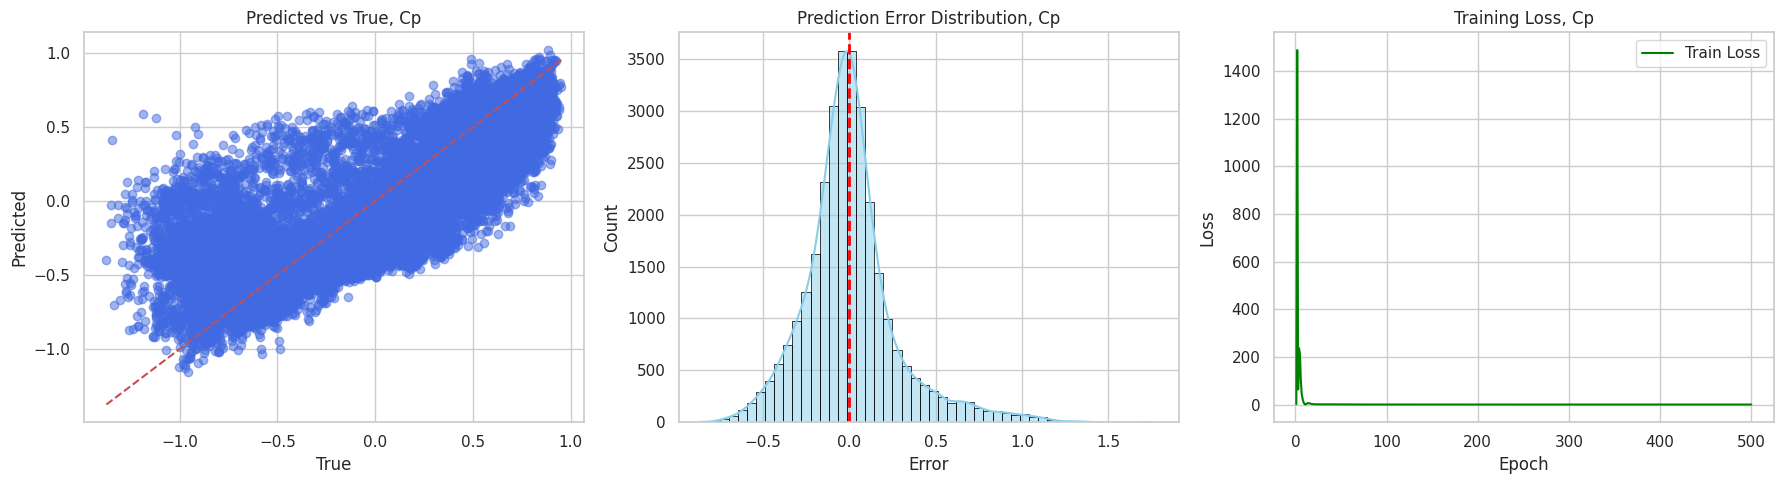

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 2/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 126.22it/s]

Epoch [10/500], Loss: 9.5623
Epoch [20/500], Loss: 13.7515


Epochs:   5%|▌         | 26/500 [00:00<00:03, 120.64it/s]

Epoch [30/500], Loss: 1.1645


Epochs:  10%|█         | 52/500 [00:00<00:03, 124.74it/s]

Epoch [40/500], Loss: 0.2582
Epoch [50/500], Loss: 0.2543


Epochs:  13%|█▎        | 65/500 [00:00<00:03, 126.32it/s]

Epoch [60/500], Loss: 0.2300


Epochs:  16%|█▌        | 78/500 [00:00<00:03, 127.12it/s]

Epoch [70/500], Loss: 0.2168
Epoch [80/500], Loss: 0.2094


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 127.57it/s]

Epoch [90/500], Loss: 0.2004


Epochs:  21%|██        | 104/500 [00:00<00:03, 127.90it/s]

Epoch [100/500], Loss: 0.1887
Epoch [110/500], Loss: 0.1787


Epochs:  23%|██▎       | 117/500 [00:00<00:02, 128.06it/s]

Epoch [120/500], Loss: 0.1673


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 128.47it/s]

Epoch [130/500], Loss: 0.1495
Epoch [140/500], Loss: 0.1294
Epoch [150/500], Loss: 0.1070


Epochs:  34%|███▍      | 169/500 [00:01<00:02, 128.33it/s]

Epoch [160/500], Loss: 0.1015
Epoch [170/500], Loss: 0.0950


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 128.26it/s]

Epoch [180/500], Loss: 0.0921


Epochs:  39%|███▉      | 195/500 [00:01<00:02, 128.26it/s]

Epoch [190/500], Loss: 0.0902
Epoch [200/500], Loss: 0.0886


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 128.39it/s]

Epoch [210/500], Loss: 0.0871


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 128.49it/s]

Epoch [220/500], Loss: 0.0855
Epoch [230/500], Loss: 0.0839
Epoch [240/500], Loss: 0.0823


Epochs:  52%|█████▏    | 260/500 [00:02<00:01, 128.40it/s]

Epoch [250/500], Loss: 0.0811
Epoch [260/500], Loss: 0.0850


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 128.64it/s]

Epoch [270/500], Loss: 0.0803


Epochs:  57%|█████▋    | 286/500 [00:02<00:01, 128.77it/s]

Epoch [280/500], Loss: 0.0792
Epoch [290/500], Loss: 0.0786


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 128.83it/s]

Epoch [300/500], Loss: 0.0779


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 128.70it/s]

Epoch [310/500], Loss: 0.0774
Epoch [320/500], Loss: 0.0773
Epoch [330/500], Loss: 0.0789


Epochs:  70%|███████   | 351/500 [00:02<00:01, 128.43it/s]

Epoch [340/500], Loss: 0.0771
Epoch [350/500], Loss: 0.0760


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 128.28it/s]

Epoch [360/500], Loss: 0.0755


Epochs:  75%|███████▌  | 377/500 [00:02<00:00, 128.22it/s]

Epoch [370/500], Loss: 0.0750
Epoch [380/500], Loss: 0.0744


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 128.42it/s]

Epoch [390/500], Loss: 0.0740


Epochs:  81%|████████  | 403/500 [00:03<00:00, 128.33it/s]

Epoch [400/500], Loss: 0.0740
Epoch [410/500], Loss: 0.0739


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 128.48it/s]

Epoch [420/500], Loss: 0.0736


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 128.56it/s]

Epoch [430/500], Loss: 0.0730
Epoch [440/500], Loss: 0.0725


Epochs:  91%|█████████ | 455/500 [00:03<00:00, 128.53it/s]

Epoch [450/500], Loss: 0.0720


Epochs:  94%|█████████▎| 468/500 [00:03<00:00, 128.69it/s]

Epoch [460/500], Loss: 0.0716
Epoch [470/500], Loss: 0.0712


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 128.68it/s]

Epoch [480/500], Loss: 0.0827


Epochs: 100%|██████████| 500/500 [00:03<00:00, 128.03it/s]

Epoch [490/500], Loss: 0.0740
Epoch [500/500], Loss: 0.0702
📈 Evaluation metrics on test set:
MSE: 0.0701
MAE: 0.1822
R2: 0.7175



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


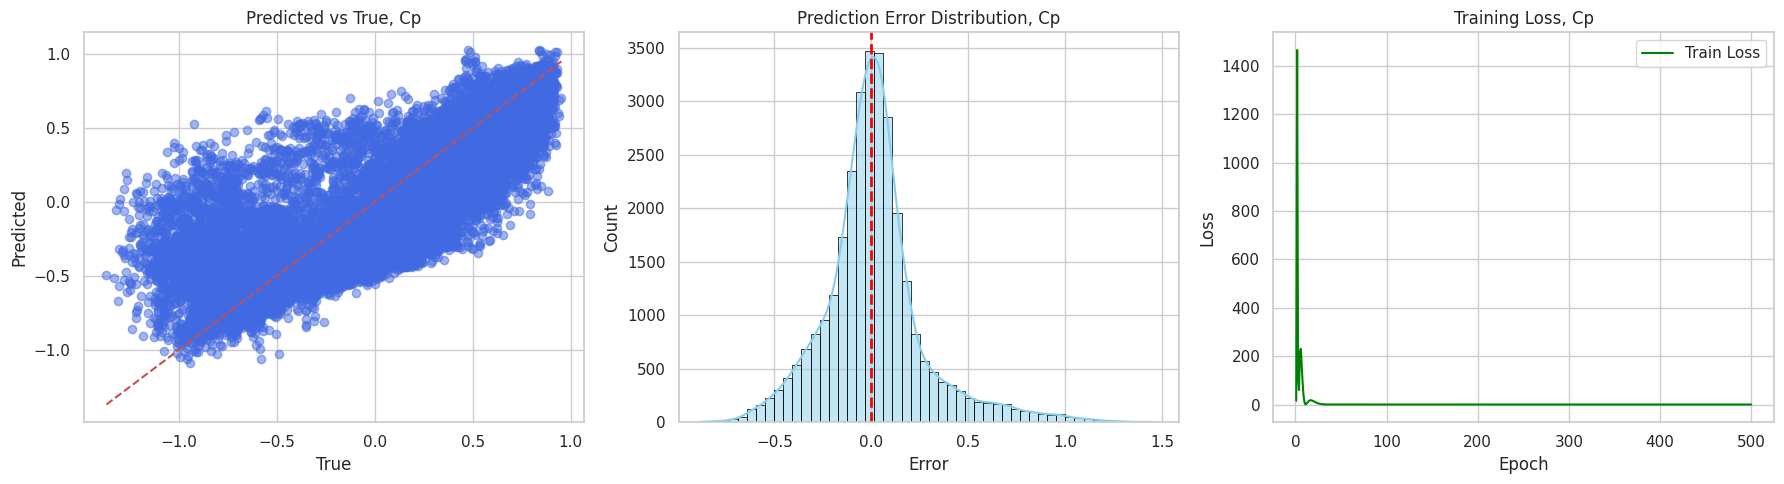

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 3/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 22/500 [00:00<00:04, 100.06it/s]

Epoch [10/500], Loss: 31.7649
Epoch [20/500], Loss: 1.8380
Epoch [30/500], Loss: 1.0561


Epochs:  12%|█▏        | 61/500 [00:00<00:03, 120.46it/s]

Epoch [40/500], Loss: 0.2408
Epoch [50/500], Loss: 0.2390
Epoch [60/500], Loss: 0.2331


Epochs:  17%|█▋        | 87/500 [00:00<00:03, 124.32it/s]

Epoch [70/500], Loss: 0.2238
Epoch [80/500], Loss: 0.2190
Epoch [90/500], Loss: 0.2163


Epochs:  23%|██▎       | 113/500 [00:00<00:03, 125.84it/s]

Epoch [100/500], Loss: 0.2142
Epoch [110/500], Loss: 0.2123
Epoch [120/500], Loss: 0.2106


Epochs:  30%|███       | 152/500 [00:01<00:02, 127.12it/s]

Epoch [130/500], Loss: 0.2090
Epoch [140/500], Loss: 0.2071
Epoch [150/500], Loss: 0.2051


Epochs:  36%|███▌      | 178/500 [00:01<00:02, 127.29it/s]

Epoch [160/500], Loss: 0.2027
Epoch [170/500], Loss: 0.1924
Epoch [180/500], Loss: 0.1683


Epochs:  41%|████      | 204/500 [00:01<00:02, 127.55it/s]

Epoch [190/500], Loss: 0.1567
Epoch [200/500], Loss: 0.1493
Epoch [210/500], Loss: 0.1421


Epochs:  49%|████▊     | 243/500 [00:01<00:02, 127.71it/s]

Epoch [220/500], Loss: 0.1320
Epoch [230/500], Loss: 0.1222
Epoch [240/500], Loss: 0.1159


Epochs:  54%|█████▍    | 269/500 [00:02<00:01, 127.52it/s]

Epoch [250/500], Loss: 0.1110
Epoch [260/500], Loss: 0.1073
Epoch [270/500], Loss: 0.1050


Epochs:  59%|█████▉    | 295/500 [00:02<00:01, 127.35it/s]

Epoch [280/500], Loss: 0.1031
Epoch [290/500], Loss: 0.1017
Epoch [300/500], Loss: 0.1006


Epochs:  67%|██████▋   | 334/500 [00:02<00:01, 127.46it/s]

Epoch [310/500], Loss: 0.0992
Epoch [320/500], Loss: 0.0983
Epoch [330/500], Loss: 0.0977


Epochs:  72%|███████▏  | 360/500 [00:02<00:01, 127.18it/s]

Epoch [340/500], Loss: 0.0958
Epoch [350/500], Loss: 0.0950
Epoch [360/500], Loss: 0.0942


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 127.06it/s]

Epoch [370/500], Loss: 0.0944
Epoch [380/500], Loss: 0.0929
Epoch [390/500], Loss: 0.0919


Epochs:  85%|████████▌ | 425/500 [00:03<00:00, 127.46it/s]

Epoch [400/500], Loss: 0.0913
Epoch [410/500], Loss: 0.0906
Epoch [420/500], Loss: 0.0899


Epochs:  90%|█████████ | 451/500 [00:03<00:00, 127.19it/s]

Epoch [430/500], Loss: 0.0893
Epoch [440/500], Loss: 0.0886
Epoch [450/500], Loss: 0.0878


Epochs:  95%|█████████▌| 477/500 [00:03<00:00, 127.14it/s]

Epoch [460/500], Loss: 0.0870
Epoch [470/500], Loss: 0.0862
Epoch [480/500], Loss: 0.0858


Epochs: 100%|██████████| 500/500 [00:03<00:00, 125.80it/s]


Epoch [490/500], Loss: 0.0851
Epoch [500/500], Loss: 0.0841
📈 Evaluation metrics on test set:
MSE: 0.0820
MAE: 0.2052
R2: 0.6631


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


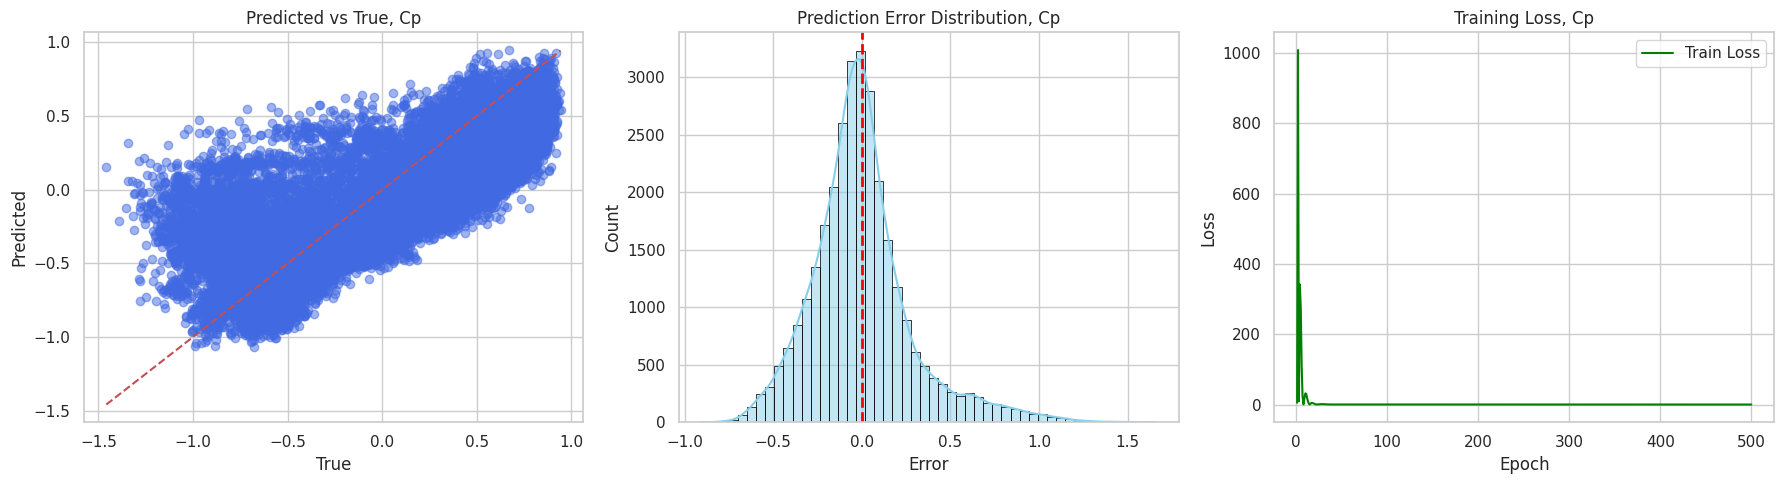

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 4/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   6%|▌         | 28/500 [00:00<00:03, 128.54it/s]

Epoch [10/500], Loss: 0.3029
Epoch [20/500], Loss: 4.4992
Epoch [30/500], Loss: 0.3033


Epochs:  11%|█         | 54/500 [00:00<00:03, 127.90it/s]

Epoch [40/500], Loss: 0.4611
Epoch [50/500], Loss: 0.3893
Epoch [60/500], Loss: 0.2774


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 127.67it/s]

Epoch [70/500], Loss: 0.2670
Epoch [80/500], Loss: 0.2468
Epoch [90/500], Loss: 0.2034


Epochs:  24%|██▍       | 119/500 [00:00<00:02, 127.72it/s]

Epoch [100/500], Loss: 0.1901
Epoch [110/500], Loss: 0.1720
Epoch [120/500], Loss: 0.1534


Epochs:  29%|██▉       | 145/500 [00:01<00:02, 127.28it/s]

Epoch [130/500], Loss: 0.1378
Epoch [140/500], Loss: 0.1661
Epoch [150/500], Loss: 0.1470


Epochs:  37%|███▋      | 184/500 [00:01<00:02, 127.67it/s]

Epoch [160/500], Loss: 0.1357
Epoch [170/500], Loss: 0.1222
Epoch [180/500], Loss: 0.1158


Epochs:  42%|████▏     | 210/500 [00:01<00:02, 127.21it/s]

Epoch [190/500], Loss: 0.1093
Epoch [200/500], Loss: 0.1033
Epoch [210/500], Loss: 0.0983


Epochs:  47%|████▋     | 236/500 [00:01<00:02, 127.33it/s]

Epoch [220/500], Loss: 0.0946
Epoch [230/500], Loss: 0.0920
Epoch [240/500], Loss: 0.0902


Epochs:  55%|█████▌    | 275/500 [00:02<00:01, 126.68it/s]

Epoch [250/500], Loss: 0.0890
Epoch [260/500], Loss: 0.0879
Epoch [270/500], Loss: 0.0870


Epochs:  60%|██████    | 301/500 [00:02<00:01, 126.79it/s]

Epoch [280/500], Loss: 0.0861
Epoch [290/500], Loss: 0.0853
Epoch [300/500], Loss: 0.0846


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 126.94it/s]

Epoch [310/500], Loss: 0.0839
Epoch [320/500], Loss: 0.0832
Epoch [330/500], Loss: 0.0825


Epochs:  71%|███████   | 353/500 [00:02<00:01, 127.12it/s]

Epoch [340/500], Loss: 0.0819
Epoch [350/500], Loss: 0.0814
Epoch [360/500], Loss: 0.0812


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 127.09it/s]

Epoch [370/500], Loss: 0.0803
Epoch [380/500], Loss: 0.0798
Epoch [390/500], Loss: 0.0793


Epochs:  84%|████████▎ | 418/500 [00:03<00:00, 126.77it/s]

Epoch [400/500], Loss: 0.0787
Epoch [410/500], Loss: 0.0783
Epoch [420/500], Loss: 0.0778


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 127.02it/s]

Epoch [430/500], Loss: 0.0773
Epoch [440/500], Loss: 0.0767
Epoch [450/500], Loss: 0.0761


Epochs:  97%|█████████▋| 483/500 [00:03<00:00, 127.13it/s]

Epoch [460/500], Loss: 0.0754
Epoch [470/500], Loss: 0.0751
Epoch [480/500], Loss: 0.0743


Epochs: 100%|██████████| 500/500 [00:03<00:00, 127.23it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0739
Epoch [500/500], Loss: 0.0733
📈 Evaluation metrics on test set:
MSE: 0.0730
MAE: 0.1890
R2: 0.7050


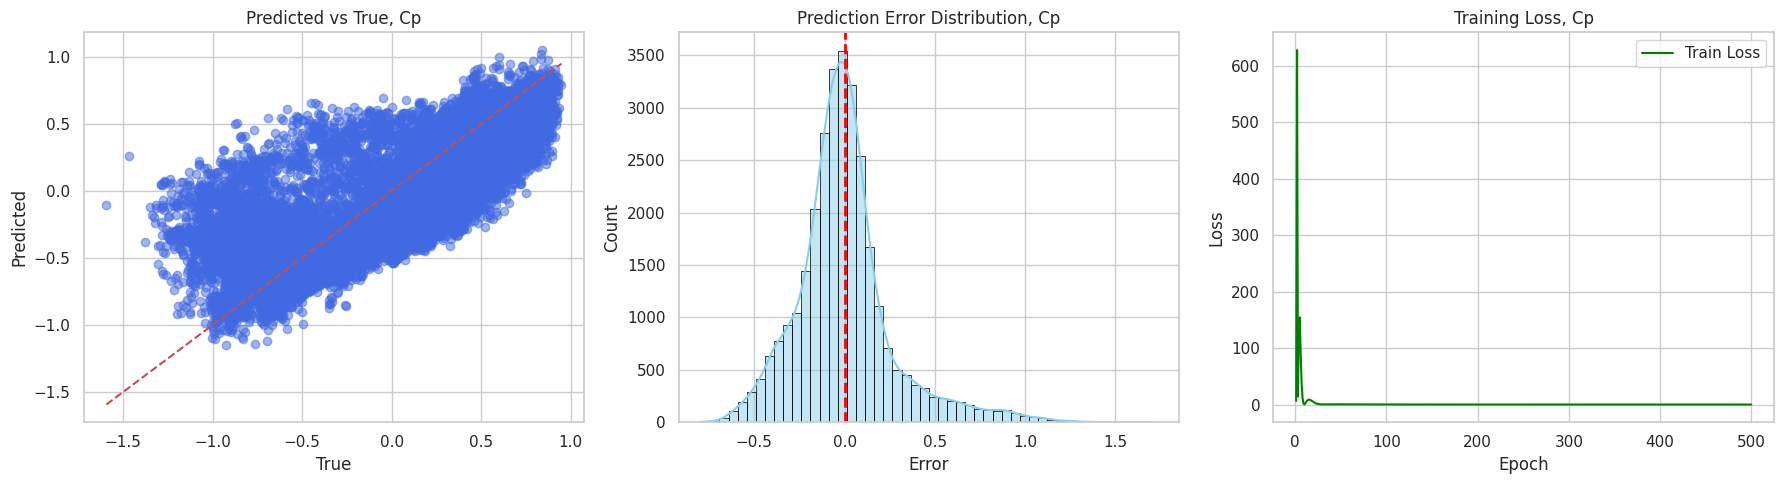

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 5/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 27/500 [00:00<00:03, 127.25it/s]

Epoch [10/500], Loss: 7.6843
Epoch [20/500], Loss: 0.2806
Epoch [30/500], Loss: 0.4257


Epochs:  11%|█         | 53/500 [00:00<00:03, 127.35it/s]

Epoch [40/500], Loss: 0.2572
Epoch [50/500], Loss: 0.2647
Epoch [60/500], Loss: 0.2302


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 127.19it/s]

Epoch [70/500], Loss: 0.2042
Epoch [80/500], Loss: 0.1933
Epoch [90/500], Loss: 0.1858


Epochs:  24%|██▎       | 118/500 [00:00<00:02, 127.38it/s]

Epoch [100/500], Loss: 0.1793
Epoch [110/500], Loss: 0.1723
Epoch [120/500], Loss: 0.1483


Epochs:  29%|██▉       | 144/500 [00:01<00:02, 127.42it/s]

Epoch [130/500], Loss: 0.1298
Epoch [140/500], Loss: 0.1181
Epoch [150/500], Loss: 0.1092


Epochs:  37%|███▋      | 183/500 [00:01<00:02, 127.27it/s]

Epoch [160/500], Loss: 0.1029
Epoch [170/500], Loss: 0.0978
Epoch [180/500], Loss: 0.0946


Epochs:  42%|████▏     | 209/500 [00:01<00:02, 127.04it/s]

Epoch [190/500], Loss: 0.0922
Epoch [200/500], Loss: 0.0903
Epoch [210/500], Loss: 0.0904


Epochs:  47%|████▋     | 235/500 [00:01<00:02, 127.08it/s]

Epoch [220/500], Loss: 0.0874
Epoch [230/500], Loss: 0.0866
Epoch [240/500], Loss: 0.0855


Epochs:  55%|█████▍    | 274/500 [00:02<00:01, 127.22it/s]

Epoch [250/500], Loss: 0.0844
Epoch [260/500], Loss: 0.0833
Epoch [270/500], Loss: 0.0821


Epochs:  60%|██████    | 300/500 [00:02<00:01, 127.44it/s]

Epoch [280/500], Loss: 0.0853
Epoch [290/500], Loss: 0.0807
Epoch [300/500], Loss: 0.0793


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 127.38it/s]

Epoch [310/500], Loss: 0.0783
Epoch [320/500], Loss: 0.0771
Epoch [330/500], Loss: 0.0762


Epochs:  73%|███████▎  | 365/500 [00:02<00:01, 127.20it/s]

Epoch [340/500], Loss: 0.0754
Epoch [350/500], Loss: 0.0747
Epoch [360/500], Loss: 0.0744


Epochs:  78%|███████▊  | 391/500 [00:03<00:00, 126.82it/s]

Epoch [370/500], Loss: 0.0736
Epoch [380/500], Loss: 0.0732
Epoch [390/500], Loss: 0.0727


Epochs:  83%|████████▎ | 417/500 [00:03<00:00, 126.60it/s]

Epoch [400/500], Loss: 0.0724
Epoch [410/500], Loss: 0.0715
Epoch [420/500], Loss: 0.0747


Epochs:  89%|████████▊ | 443/500 [00:03<00:00, 126.69it/s]

Epoch [430/500], Loss: 0.0712
Epoch [440/500], Loss: 0.0701
Epoch [450/500], Loss: 0.0694


Epochs:  96%|█████████▋| 482/500 [00:03<00:00, 126.96it/s]

Epoch [460/500], Loss: 0.0688
Epoch [470/500], Loss: 0.0680
Epoch [480/500], Loss: 0.0734


Epochs: 100%|██████████| 500/500 [00:03<00:00, 127.12it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0674
Epoch [500/500], Loss: 0.0671
📈 Evaluation metrics on test set:
MSE: 0.0662
MAE: 0.1767
R2: 0.7328


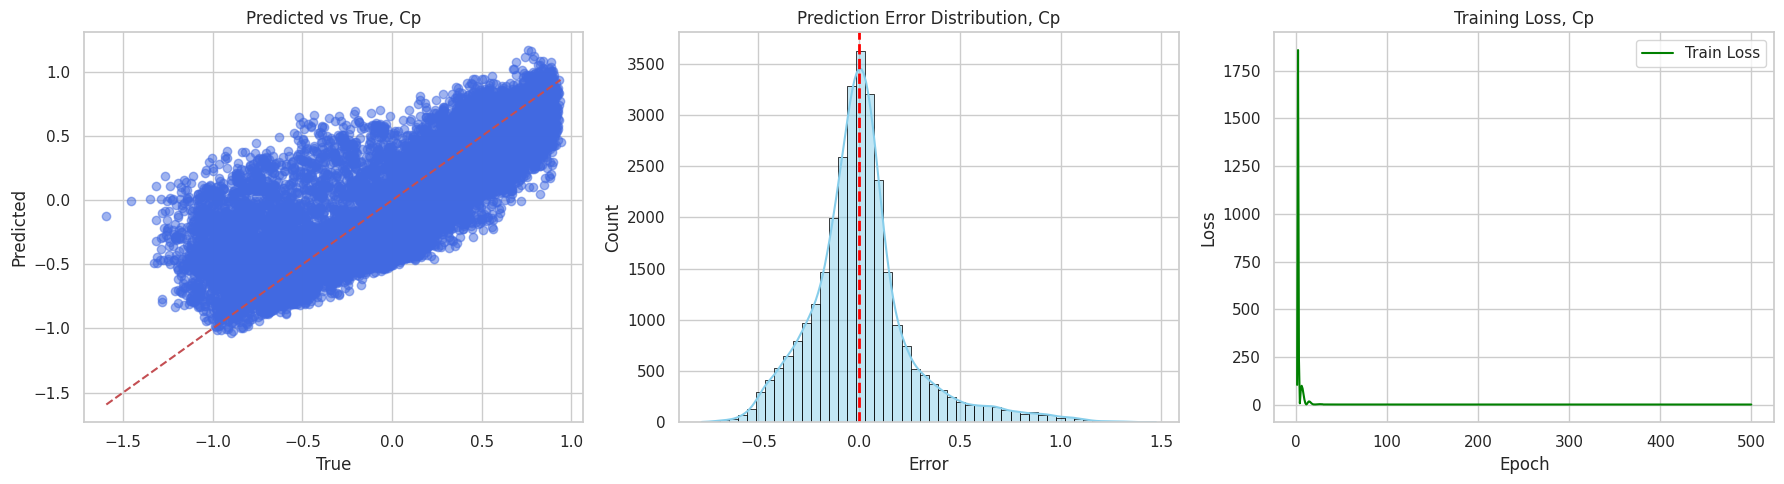

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 6/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   6%|▌         | 28/500 [00:00<00:03, 128.84it/s]

Epoch [10/500], Loss: 25.1916
Epoch [20/500], Loss: 0.2928
Epoch [30/500], Loss: 0.9204


Epochs:  11%|█         | 54/500 [00:00<00:03, 127.74it/s]

Epoch [40/500], Loss: 0.2822
Epoch [50/500], Loss: 0.3063
Epoch [60/500], Loss: 0.2214


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 127.40it/s]

Epoch [70/500], Loss: 0.2115
Epoch [80/500], Loss: 0.1994
Epoch [90/500], Loss: 0.1938


Epochs:  24%|██▍       | 119/500 [00:00<00:02, 127.48it/s]

Epoch [100/500], Loss: 0.1893
Epoch [110/500], Loss: 0.1837
Epoch [120/500], Loss: 0.1777


Epochs:  29%|██▉       | 145/500 [00:01<00:02, 127.26it/s]

Epoch [130/500], Loss: 0.1704
Epoch [140/500], Loss: 0.1628
Epoch [150/500], Loss: 0.1550


Epochs:  37%|███▋      | 184/500 [00:01<00:02, 127.35it/s]

Epoch [160/500], Loss: 0.1470
Epoch [170/500], Loss: 0.1390
Epoch [180/500], Loss: 0.1316


Epochs:  42%|████▏     | 210/500 [00:01<00:02, 127.37it/s]

Epoch [190/500], Loss: 0.1249
Epoch [200/500], Loss: 0.1182
Epoch [210/500], Loss: 0.1124


Epochs:  47%|████▋     | 236/500 [00:01<00:02, 127.01it/s]

Epoch [220/500], Loss: 0.1070
Epoch [230/500], Loss: 0.1023
Epoch [240/500], Loss: 0.0976


Epochs:  55%|█████▌    | 275/500 [00:02<00:01, 127.16it/s]

Epoch [250/500], Loss: 0.0938
Epoch [260/500], Loss: 0.0905
Epoch [270/500], Loss: 0.0875


Epochs:  60%|██████    | 301/500 [00:02<00:01, 127.20it/s]

Epoch [280/500], Loss: 0.0861
Epoch [290/500], Loss: 0.0835
Epoch [300/500], Loss: 0.0819


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 127.11it/s]

Epoch [310/500], Loss: 0.0807
Epoch [320/500], Loss: 0.0792
Epoch [330/500], Loss: 0.0787


Epochs:  71%|███████   | 353/500 [00:02<00:01, 127.18it/s]

Epoch [340/500], Loss: 0.0774
Epoch [350/500], Loss: 0.0767
Epoch [360/500], Loss: 0.0756


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 127.10it/s]

Epoch [370/500], Loss: 0.0748
Epoch [380/500], Loss: 0.0741
Epoch [390/500], Loss: 0.0736


Epochs:  84%|████████▎ | 418/500 [00:03<00:00, 127.23it/s]

Epoch [400/500], Loss: 0.0729
Epoch [410/500], Loss: 0.0727
Epoch [420/500], Loss: 0.0721


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 126.78it/s]

Epoch [430/500], Loss: 0.0715
Epoch [440/500], Loss: 0.0710
Epoch [450/500], Loss: 0.0712


Epochs:  97%|█████████▋| 483/500 [00:03<00:00, 126.81it/s]

Epoch [460/500], Loss: 0.0708
Epoch [470/500], Loss: 0.0702
Epoch [480/500], Loss: 0.0698


Epochs: 100%|██████████| 500/500 [00:03<00:00, 127.21it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0692
Epoch [500/500], Loss: 0.0689
📈 Evaluation metrics on test set:
MSE: 0.0678
MAE: 0.1816
R2: 0.7236


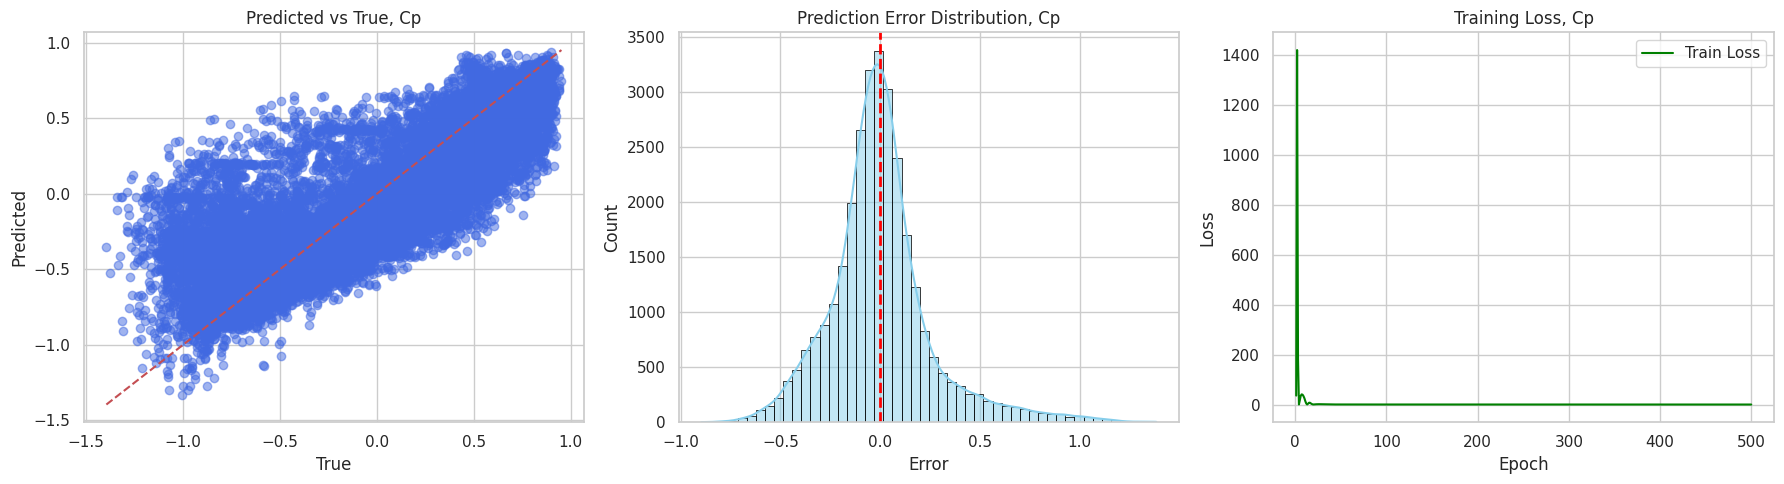

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 7/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 126.46it/s]

Epoch [10/500], Loss: 11.4579
Epoch [20/500], Loss: 4.2968
Epoch [30/500], Loss: 0.8805


Epochs:  13%|█▎        | 65/500 [00:00<00:03, 126.06it/s]

Epoch [40/500], Loss: 0.7163
Epoch [50/500], Loss: 0.6639
Epoch [60/500], Loss: 0.3149


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 126.14it/s]

Epoch [70/500], Loss: 0.2403
Epoch [80/500], Loss: 0.2475
Epoch [90/500], Loss: 0.2398


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 125.83it/s]

Epoch [100/500], Loss: 0.2323
Epoch [110/500], Loss: 0.2288
Epoch [120/500], Loss: 0.2266


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 125.75it/s]

Epoch [130/500], Loss: 0.2244
Epoch [140/500], Loss: 0.2221
Epoch [150/500], Loss: 0.2197


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 125.52it/s]

Epoch [160/500], Loss: 0.1920
Epoch [170/500], Loss: 0.1729
Epoch [180/500], Loss: 0.1619


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 125.64it/s]

Epoch [190/500], Loss: 0.1554
Epoch [200/500], Loss: 0.1519
Epoch [210/500], Loss: 0.1469


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 125.79it/s]

Epoch [220/500], Loss: 0.1422
Epoch [230/500], Loss: 0.1381
Epoch [240/500], Loss: 0.1340


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 125.64it/s]

Epoch [250/500], Loss: 0.1299
Epoch [260/500], Loss: 0.1262
Epoch [270/500], Loss: 0.1228


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 125.71it/s]

Epoch [280/500], Loss: 0.1201
Epoch [290/500], Loss: 0.1176
Epoch [300/500], Loss: 0.1155


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 125.60it/s]

Epoch [310/500], Loss: 0.2457
Epoch [320/500], Loss: 0.1253
Epoch [330/500], Loss: 0.1196


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 125.33it/s]

Epoch [340/500], Loss: 0.1173
Epoch [350/500], Loss: 0.1145
Epoch [360/500], Loss: 0.1130


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 125.44it/s]

Epoch [370/500], Loss: 0.1117
Epoch [380/500], Loss: 0.1107
Epoch [390/500], Loss: 0.1097


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 125.51it/s]

Epoch [400/500], Loss: 0.1086
Epoch [410/500], Loss: 0.1075
Epoch [420/500], Loss: 0.1065


Epochs:  91%|█████████ | 455/500 [00:03<00:00, 125.62it/s]

Epoch [430/500], Loss: 0.1058
Epoch [440/500], Loss: 0.1051
Epoch [450/500], Loss: 0.1044


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 125.61it/s]

Epoch [460/500], Loss: 0.1037
Epoch [470/500], Loss: 0.1031
Epoch [480/500], Loss: 0.1024


Epochs: 100%|██████████| 500/500 [00:03<00:00, 125.67it/s]


Epoch [490/500], Loss: 0.1016
Epoch [500/500], Loss: 0.1007
📈 Evaluation metrics on test set:
MSE: 0.0994
MAE: 0.2281
R2: 0.5974


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


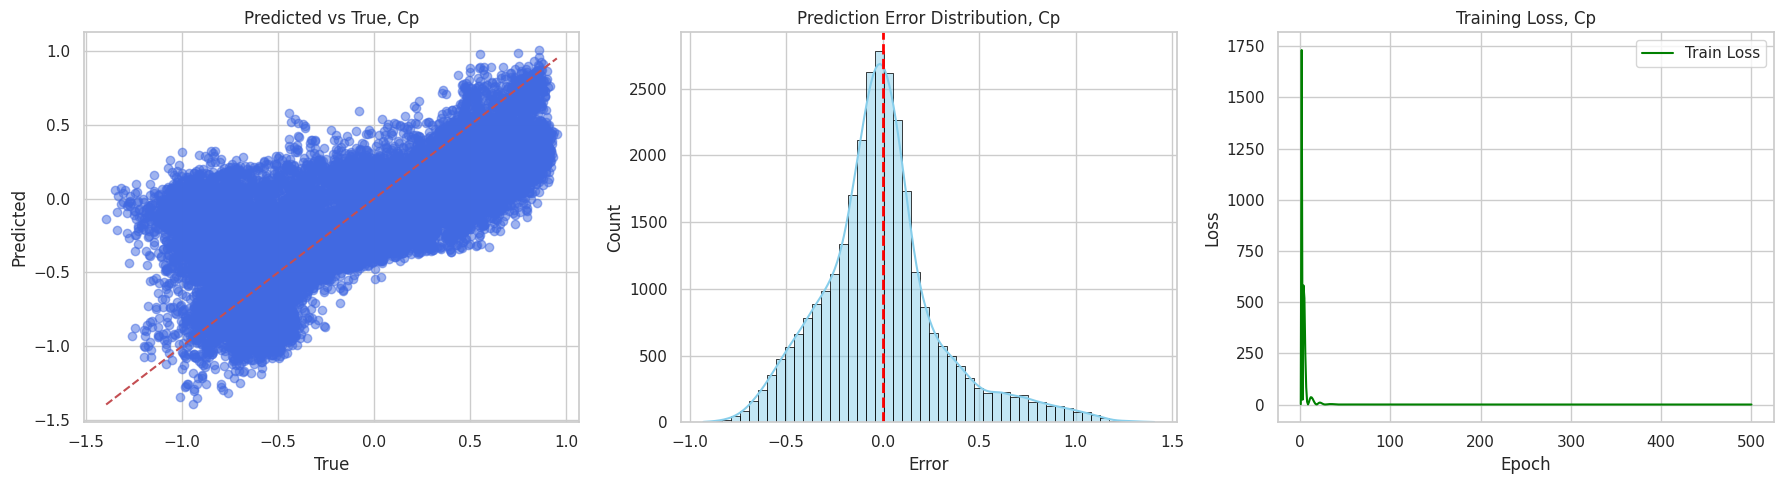

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 8/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   6%|▌         | 28/500 [00:00<00:03, 127.28it/s]

Epoch [10/500], Loss: 8.2203
Epoch [20/500], Loss: 1.9941
Epoch [30/500], Loss: 0.4155


Epochs:  11%|█         | 54/500 [00:00<00:03, 126.54it/s]

Epoch [40/500], Loss: 0.2638
Epoch [50/500], Loss: 0.2687
Epoch [60/500], Loss: 0.2626


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 126.55it/s]

Epoch [70/500], Loss: 0.2528
Epoch [80/500], Loss: 0.2340
Epoch [90/500], Loss: 0.2207


Epochs:  24%|██▍       | 119/500 [00:00<00:03, 126.16it/s]

Epoch [100/500], Loss: 0.2064
Epoch [110/500], Loss: 0.1956
Epoch [120/500], Loss: 0.1855


Epochs:  29%|██▉       | 145/500 [00:01<00:02, 126.13it/s]

Epoch [130/500], Loss: 0.1721
Epoch [140/500], Loss: 0.1577
Epoch [150/500], Loss: 0.1469


Epochs:  37%|███▋      | 184/500 [00:01<00:02, 126.07it/s]

Epoch [160/500], Loss: 0.1358
Epoch [170/500], Loss: 0.1350
Epoch [180/500], Loss: 0.1396


Epochs:  42%|████▏     | 210/500 [00:01<00:02, 126.04it/s]

Epoch [190/500], Loss: 0.1177
Epoch [200/500], Loss: 0.1086
Epoch [210/500], Loss: 0.0973


Epochs:  47%|████▋     | 236/500 [00:01<00:02, 125.82it/s]

Epoch [220/500], Loss: 0.0956
Epoch [230/500], Loss: 0.1558
Epoch [240/500], Loss: 0.1509


Epochs:  55%|█████▌    | 275/500 [00:02<00:01, 125.69it/s]

Epoch [250/500], Loss: 0.1464
Epoch [260/500], Loss: 0.1441
Epoch [270/500], Loss: 0.1415


Epochs:  60%|██████    | 301/500 [00:02<00:01, 125.48it/s]

Epoch [280/500], Loss: 0.1381
Epoch [290/500], Loss: 0.1357
Epoch [300/500], Loss: 0.1325


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 125.98it/s]

Epoch [310/500], Loss: 0.1283
Epoch [320/500], Loss: 0.1256
Epoch [330/500], Loss: 0.1197


Epochs:  71%|███████   | 353/500 [00:02<00:01, 125.78it/s]

Epoch [340/500], Loss: 0.1301
Epoch [350/500], Loss: 0.1362
Epoch [360/500], Loss: 0.1279


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 125.55it/s]

Epoch [370/500], Loss: 0.1224
Epoch [380/500], Loss: 0.1180
Epoch [390/500], Loss: 0.1020


Epochs:  84%|████████▎ | 418/500 [00:03<00:00, 125.23it/s]

Epoch [400/500], Loss: 0.0957
Epoch [410/500], Loss: 0.0867
Epoch [420/500], Loss: 0.0854


Epochs:  89%|████████▉ | 444/500 [00:03<00:00, 125.26it/s]

Epoch [430/500], Loss: 0.0846
Epoch [440/500], Loss: 0.0868
Epoch [450/500], Loss: 0.0833


Epochs:  97%|█████████▋| 483/500 [00:03<00:00, 125.26it/s]

Epoch [460/500], Loss: 0.0817
Epoch [470/500], Loss: 0.0830
Epoch [480/500], Loss: 0.0813


Epochs: 100%|██████████| 500/500 [00:03<00:00, 125.86it/s]


Epoch [490/500], Loss: 0.0815
Epoch [500/500], Loss: 0.0808
📈 Evaluation metrics on test set:
MSE: 0.0802
MAE: 0.1941
R2: 0.6790


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


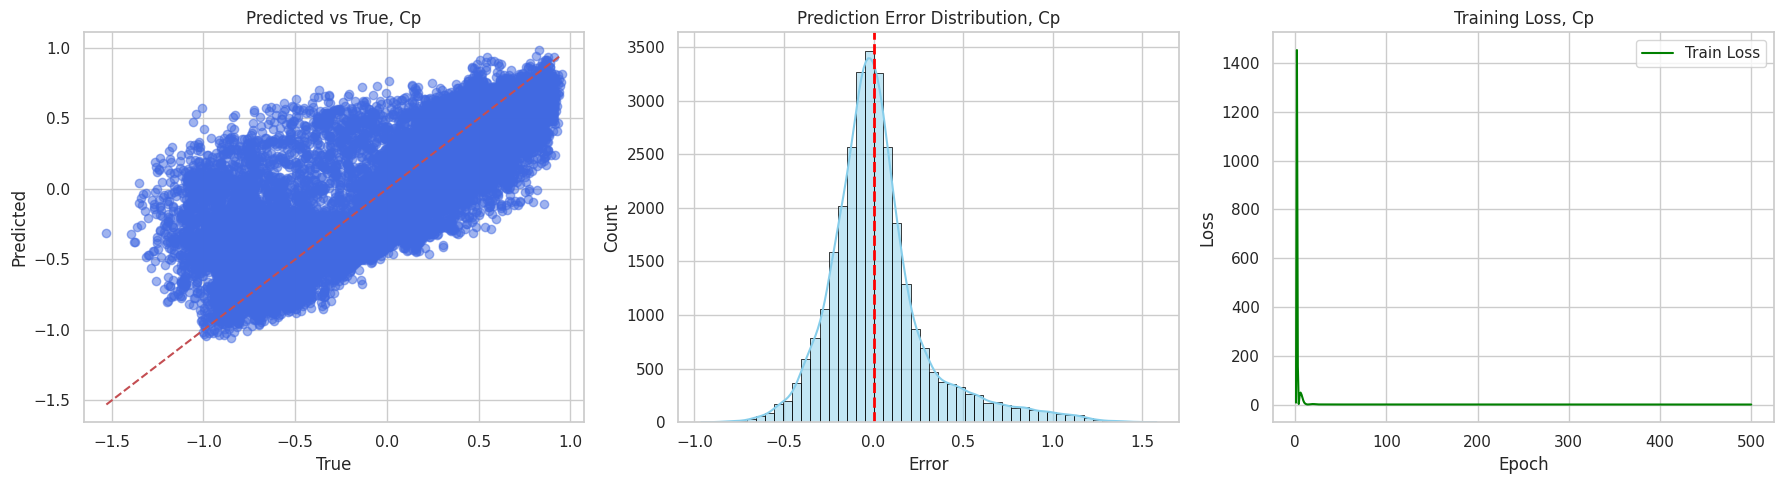

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 9/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 99.08it/s]

Epoch [10/500], Loss: 33.9932
Epoch [20/500], Loss: 0.6750
Epoch [30/500], Loss: 0.8309


Epochs:  12%|█▏        | 58/500 [00:00<00:03, 116.36it/s]

Epoch [40/500], Loss: 0.3329
Epoch [50/500], Loss: 0.2198
Epoch [60/500], Loss: 0.2100


Epochs:  17%|█▋        | 84/500 [00:00<00:03, 121.66it/s]

Epoch [70/500], Loss: 0.1926
Epoch [80/500], Loss: 0.1873
Epoch [90/500], Loss: 0.1791


Epochs:  25%|██▍       | 123/500 [00:01<00:03, 124.21it/s]

Epoch [100/500], Loss: 0.1706
Epoch [110/500], Loss: 0.1612
Epoch [120/500], Loss: 0.1501


Epochs:  30%|██▉       | 149/500 [00:01<00:02, 125.06it/s]

Epoch [130/500], Loss: 0.1345
Epoch [140/500], Loss: 0.1217
Epoch [150/500], Loss: 0.1164


Epochs:  35%|███▌      | 175/500 [00:01<00:02, 125.15it/s]

Epoch [160/500], Loss: 0.1137
Epoch [170/500], Loss: 0.1135
Epoch [180/500], Loss: 0.1105


Epochs:  43%|████▎     | 214/500 [00:01<00:02, 125.19it/s]

Epoch [190/500], Loss: 0.1084
Epoch [200/500], Loss: 0.1073
Epoch [210/500], Loss: 0.1052


Epochs:  48%|████▊     | 240/500 [00:01<00:02, 125.28it/s]

Epoch [220/500], Loss: 0.1017
Epoch [230/500], Loss: 0.1032
Epoch [240/500], Loss: 0.0968


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 125.12it/s]

Epoch [250/500], Loss: 0.0935
Epoch [260/500], Loss: 0.0908
Epoch [270/500], Loss: 0.0888


Epochs:  61%|██████    | 305/500 [00:02<00:01, 125.27it/s]

Epoch [280/500], Loss: 0.0867
Epoch [290/500], Loss: 0.0941
Epoch [300/500], Loss: 0.0857


Epochs:  66%|██████▌   | 331/500 [00:02<00:01, 125.07it/s]

Epoch [310/500], Loss: 0.0844
Epoch [320/500], Loss: 0.0830
Epoch [330/500], Loss: 0.0855


Epochs:  71%|███████▏  | 357/500 [00:02<00:01, 125.01it/s]

Epoch [340/500], Loss: 0.0817
Epoch [350/500], Loss: 0.0827
Epoch [360/500], Loss: 0.0808


Epochs:  77%|███████▋  | 383/500 [00:03<00:00, 125.19it/s]

Epoch [370/500], Loss: 0.0806
Epoch [380/500], Loss: 0.0802
Epoch [390/500], Loss: 0.0795


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 124.37it/s]

Epoch [400/500], Loss: 0.0777
Epoch [410/500], Loss: 0.0769
Epoch [420/500], Loss: 0.0757


Epochs:  90%|████████▉ | 448/500 [00:03<00:00, 124.13it/s]

Epoch [430/500], Loss: 0.0756
Epoch [440/500], Loss: 0.0756
Epoch [450/500], Loss: 0.0770


Epochs:  95%|█████████▍| 474/500 [00:03<00:00, 124.11it/s]

Epoch [460/500], Loss: 0.0741
Epoch [470/500], Loss: 0.0731
Epoch [480/500], Loss: 0.0719


Epochs: 100%|██████████| 500/500 [00:04<00:00, 123.01it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0732
Epoch [500/500], Loss: 0.0730
📈 Evaluation metrics on test set:
MSE: 0.0709
MAE: 0.1870
R2: 0.7129


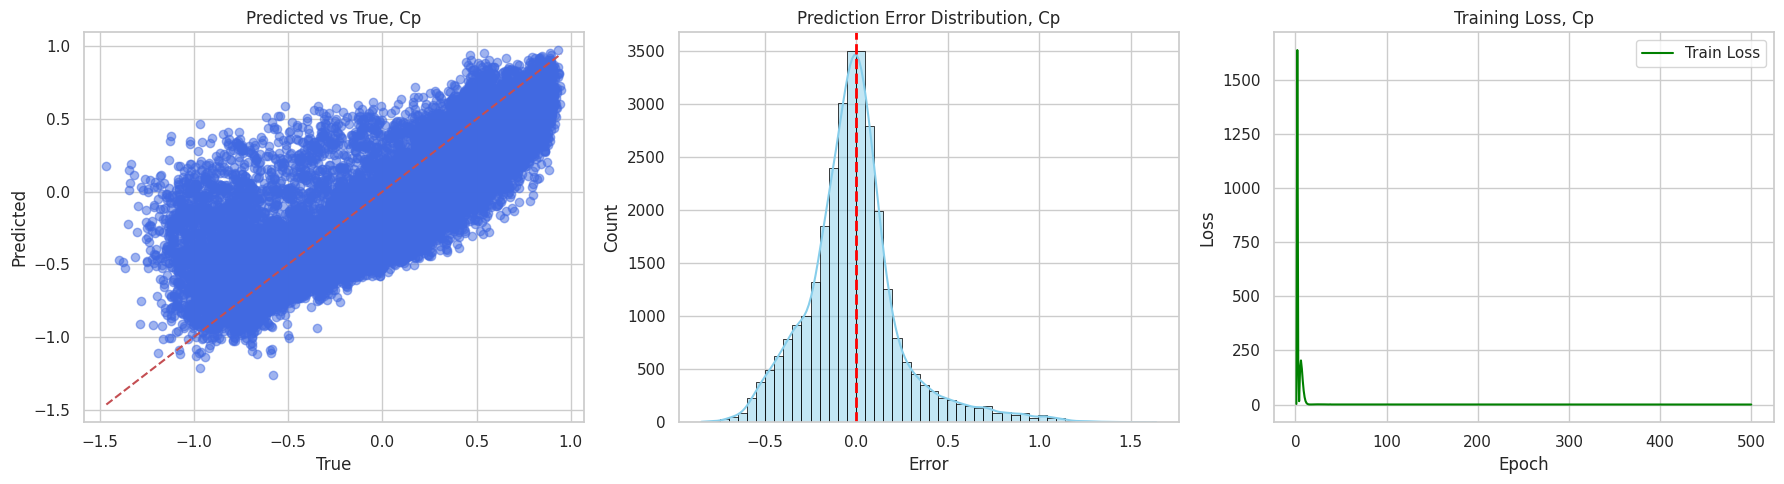

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 10/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 124.57it/s]

Epoch [10/500], Loss: 58.7455
Epoch [20/500], Loss: 0.2628
Epoch [30/500], Loss: 2.5735


Epochs:  10%|█         | 52/500 [00:00<00:03, 123.95it/s]

Epoch [40/500], Loss: 1.1255
Epoch [50/500], Loss: 0.4871
Epoch [60/500], Loss: 0.3103


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 124.08it/s]

Epoch [70/500], Loss: 0.2598
Epoch [80/500], Loss: 0.2394
Epoch [90/500], Loss: 0.2293


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 124.70it/s]

Epoch [100/500], Loss: 0.2238
Epoch [110/500], Loss: 0.2205
Epoch [120/500], Loss: 0.2185


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 124.46it/s]

Epoch [130/500], Loss: 0.2171
Epoch [140/500], Loss: 0.2160
Epoch [150/500], Loss: 0.2149


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 124.22it/s]

Epoch [160/500], Loss: 0.2140
Epoch [170/500], Loss: 0.2132
Epoch [180/500], Loss: 0.2124


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 124.61it/s]

Epoch [190/500], Loss: 0.2117
Epoch [200/500], Loss: 0.2109
Epoch [210/500], Loss: 0.2080


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 124.45it/s]

Epoch [220/500], Loss: 0.1992
Epoch [230/500], Loss: 0.1892
Epoch [240/500], Loss: 0.1824


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 123.91it/s]

Epoch [250/500], Loss: 0.1534
Epoch [260/500], Loss: 0.1336
Epoch [270/500], Loss: 0.1202


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 123.51it/s]

Epoch [280/500], Loss: 0.1106
Epoch [290/500], Loss: 0.1035
Epoch [300/500], Loss: 0.0984


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 123.78it/s]

Epoch [310/500], Loss: 0.0948
Epoch [320/500], Loss: 0.0921
Epoch [330/500], Loss: 0.0893


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 124.43it/s]

Epoch [340/500], Loss: 0.0870
Epoch [350/500], Loss: 0.0846
Epoch [360/500], Loss: 0.0833


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 123.91it/s]

Epoch [370/500], Loss: 0.0807
Epoch [380/500], Loss: 0.0790
Epoch [390/500], Loss: 0.0775


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 123.85it/s]

Epoch [400/500], Loss: 0.0779
Epoch [410/500], Loss: 0.0755
Epoch [420/500], Loss: 0.0746


Epochs:  91%|█████████ | 455/500 [00:03<00:00, 123.84it/s]

Epoch [430/500], Loss: 0.0736
Epoch [440/500], Loss: 0.0726
Epoch [450/500], Loss: 0.0717


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 124.03it/s]

Epoch [460/500], Loss: 0.0725
Epoch [470/500], Loss: 0.0707
Epoch [480/500], Loss: 0.0696


Epochs: 100%|██████████| 500/500 [00:04<00:00, 124.07it/s]


Epoch [490/500], Loss: 0.0690
Epoch [500/500], Loss: 0.0684
📈 Evaluation metrics on test set:
MSE: 0.0685
MAE: 0.1833
R2: 0.7218


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


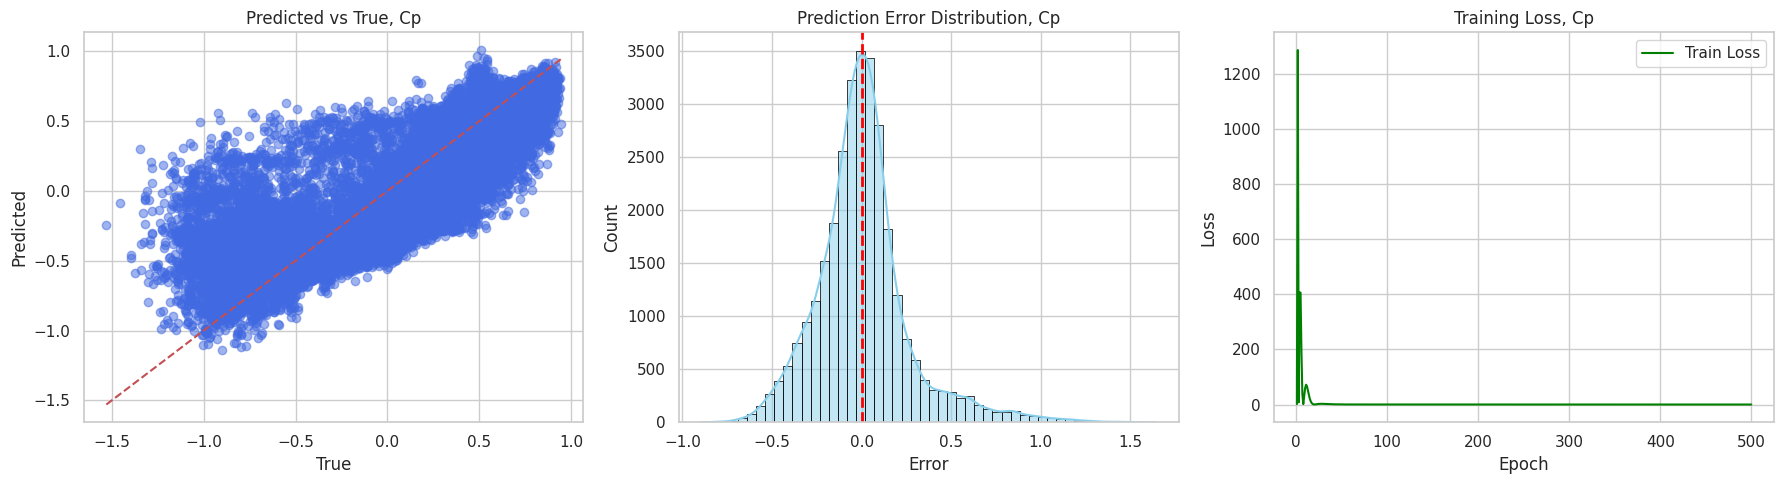

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 11/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 124.40it/s]

Epoch [10/500], Loss: 0.3261
Epoch [20/500], Loss: 3.5525
Epoch [30/500], Loss: 0.3846


Epochs:  13%|█▎        | 65/500 [00:00<00:03, 124.52it/s]

Epoch [40/500], Loss: 0.2680
Epoch [50/500], Loss: 0.2247
Epoch [60/500], Loss: 0.2202


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 123.97it/s]

Epoch [70/500], Loss: 0.2137
Epoch [80/500], Loss: 0.2077
Epoch [90/500], Loss: 0.2013


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 124.17it/s]

Epoch [100/500], Loss: 0.2133
Epoch [110/500], Loss: 0.1972
Epoch [120/500], Loss: 0.1829


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 124.21it/s]

Epoch [130/500], Loss: 0.1636
Epoch [140/500], Loss: 0.1502
Epoch [150/500], Loss: 0.1404


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 124.08it/s]

Epoch [160/500], Loss: 0.1343
Epoch [170/500], Loss: 0.1295
Epoch [180/500], Loss: 0.1238


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 123.61it/s]

Epoch [190/500], Loss: 0.1173
Epoch [200/500], Loss: 0.1135
Epoch [210/500], Loss: 0.1077


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 123.85it/s]

Epoch [220/500], Loss: 0.1035
Epoch [230/500], Loss: 0.1013
Epoch [240/500], Loss: 0.0997


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 123.91it/s]

Epoch [250/500], Loss: 0.0974
Epoch [260/500], Loss: 0.0986
Epoch [270/500], Loss: 0.0929


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 123.47it/s]

Epoch [280/500], Loss: 0.0905
Epoch [290/500], Loss: 0.0871
Epoch [300/500], Loss: 0.0870


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 123.59it/s]

Epoch [310/500], Loss: 0.0839
Epoch [320/500], Loss: 0.0944
Epoch [330/500], Loss: 0.0822


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 123.97it/s]

Epoch [340/500], Loss: 0.0826
Epoch [350/500], Loss: 0.0809
Epoch [360/500], Loss: 0.0807


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 124.21it/s]

Epoch [370/500], Loss: 0.1000
Epoch [380/500], Loss: 0.0864
Epoch [390/500], Loss: 0.0795


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 124.37it/s]

Epoch [400/500], Loss: 0.0799
Epoch [410/500], Loss: 0.0788
Epoch [420/500], Loss: 0.0781


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 123.94it/s]

Epoch [430/500], Loss: 0.0774
Epoch [440/500], Loss: 0.0767
Epoch [450/500], Loss: 0.0805


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 123.64it/s]

Epoch [460/500], Loss: 0.0835
Epoch [470/500], Loss: 0.0773
Epoch [480/500], Loss: 0.0759


Epochs: 100%|██████████| 500/500 [00:04<00:00, 123.95it/s]


Epoch [490/500], Loss: 0.0758
Epoch [500/500], Loss: 0.0751
📈 Evaluation metrics on test set:
MSE: 0.0758
MAE: 0.1939
R2: 0.6927


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


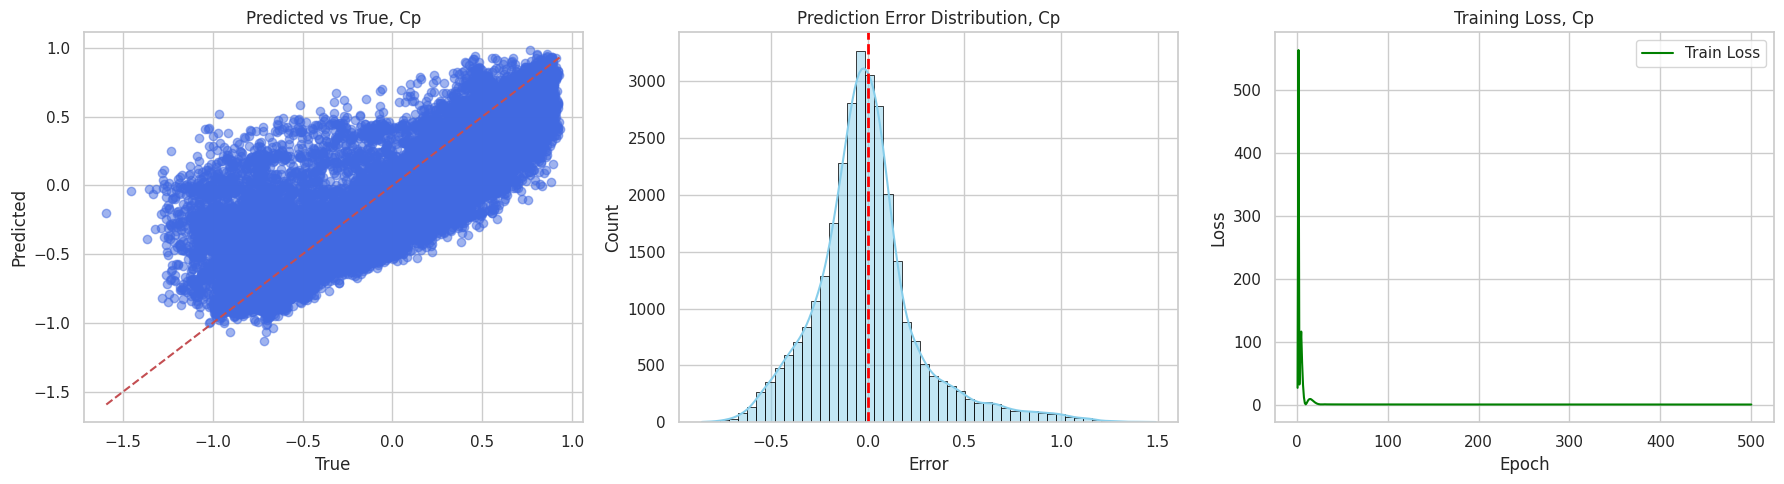

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 12/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▍         | 24/500 [00:00<00:04, 110.33it/s]

Epoch [10/500], Loss: 1.3659
Epoch [20/500], Loss: 2.6042
Epoch [30/500], Loss: 2.6901


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 119.50it/s]

Epoch [40/500], Loss: 0.5267
Epoch [50/500], Loss: 0.2871
Epoch [60/500], Loss: 0.2602


Epochs:  18%|█▊        | 88/500 [00:00<00:03, 121.63it/s]

Epoch [70/500], Loss: 0.2186
Epoch [80/500], Loss: 0.2129
Epoch [90/500], Loss: 0.2052


Epochs:  23%|██▎       | 114/500 [00:00<00:03, 122.13it/s]

Epoch [100/500], Loss: 0.1855
Epoch [110/500], Loss: 0.1658
Epoch [120/500], Loss: 0.1542


Epochs:  31%|███       | 153/500 [00:01<00:02, 122.46it/s]

Epoch [130/500], Loss: 0.1444
Epoch [140/500], Loss: 0.1366
Epoch [150/500], Loss: 0.1536


Epochs:  36%|███▌      | 179/500 [00:01<00:02, 122.25it/s]

Epoch [160/500], Loss: 0.1419
Epoch [170/500], Loss: 0.1367
Epoch [180/500], Loss: 0.1296


Epochs:  41%|████      | 205/500 [00:01<00:02, 122.58it/s]

Epoch [190/500], Loss: 0.1232
Epoch [200/500], Loss: 0.1175
Epoch [210/500], Loss: 0.1132


Epochs:  49%|████▉     | 244/500 [00:02<00:02, 123.03it/s]

Epoch [220/500], Loss: 0.1102
Epoch [230/500], Loss: 0.1079
Epoch [240/500], Loss: 0.1063


Epochs:  54%|█████▍    | 270/500 [00:02<00:01, 122.86it/s]

Epoch [250/500], Loss: 0.1051
Epoch [260/500], Loss: 0.1044
Epoch [270/500], Loss: 0.1036


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 123.09it/s]

Epoch [280/500], Loss: 0.1023
Epoch [290/500], Loss: 0.0990
Epoch [300/500], Loss: 0.0967


Epochs:  64%|██████▍   | 322/500 [00:02<00:01, 123.41it/s]

Epoch [310/500], Loss: 0.0897
Epoch [320/500], Loss: 0.0877
Epoch [330/500], Loss: 0.1138


Epochs:  72%|███████▏  | 361/500 [00:02<00:01, 122.52it/s]

Epoch [340/500], Loss: 0.1020
Epoch [350/500], Loss: 0.0915
Epoch [360/500], Loss: 0.0898


Epochs:  77%|███████▋  | 387/500 [00:03<00:00, 123.07it/s]

Epoch [370/500], Loss: 0.0878
Epoch [380/500], Loss: 0.0864
Epoch [390/500], Loss: 0.0854


Epochs:  83%|████████▎ | 413/500 [00:03<00:00, 123.13it/s]

Epoch [400/500], Loss: 0.0846
Epoch [410/500], Loss: 0.0837
Epoch [420/500], Loss: 0.0830


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 123.00it/s]

Epoch [430/500], Loss: 0.0822
Epoch [440/500], Loss: 0.0815
Epoch [450/500], Loss: 0.0809


Epochs:  96%|█████████▌| 478/500 [00:03<00:00, 122.66it/s]

Epoch [460/500], Loss: 0.0802
Epoch [470/500], Loss: 0.0796
Epoch [480/500], Loss: 0.0790


Epochs: 100%|██████████| 500/500 [00:04<00:00, 122.19it/s]


Epoch [490/500], Loss: 0.0786
Epoch [500/500], Loss: 0.0778
📈 Evaluation metrics on test set:
MSE: 0.0782
MAE: 0.1987
R2: 0.6841


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


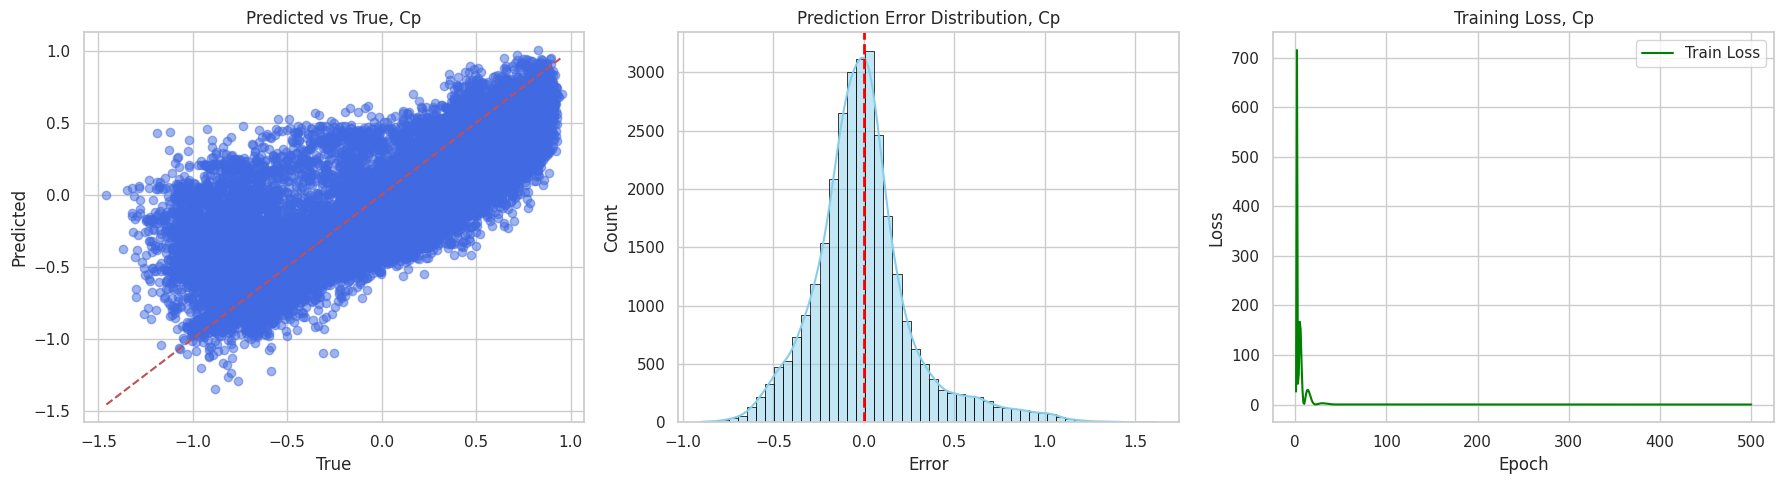

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 13/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 123.37it/s]

Epoch [10/500], Loss: 18.9247
Epoch [20/500], Loss: 10.9620
Epoch [30/500], Loss: 0.4087


Epochs:  10%|█         | 52/500 [00:00<00:03, 122.81it/s]

Epoch [40/500], Loss: 0.2557
Epoch [50/500], Loss: 0.2718
Epoch [60/500], Loss: 0.2590


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 122.90it/s]

Epoch [70/500], Loss: 0.2210
Epoch [80/500], Loss: 0.2332
Epoch [90/500], Loss: 0.2066


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 122.81it/s]

Epoch [100/500], Loss: 0.1873
Epoch [110/500], Loss: 0.1585
Epoch [120/500], Loss: 0.1417


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 122.37it/s]

Epoch [130/500], Loss: 0.1331
Epoch [140/500], Loss: 0.1239
Epoch [150/500], Loss: 0.1174


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 122.86it/s]

Epoch [160/500], Loss: 0.1107
Epoch [170/500], Loss: 0.1223
Epoch [180/500], Loss: 0.1012


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 123.54it/s]

Epoch [190/500], Loss: 0.0987
Epoch [200/500], Loss: 0.0951
Epoch [210/500], Loss: 0.0935


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 122.97it/s]

Epoch [220/500], Loss: 0.0901
Epoch [230/500], Loss: 0.0913
Epoch [240/500], Loss: 0.0870


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 123.06it/s]

Epoch [250/500], Loss: 0.0953
Epoch [260/500], Loss: 0.0866
Epoch [270/500], Loss: 0.0831


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 122.84it/s]

Epoch [280/500], Loss: 0.0827
Epoch [290/500], Loss: 0.0810
Epoch [300/500], Loss: 0.0798


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 122.99it/s]

Epoch [310/500], Loss: 0.0828
Epoch [320/500], Loss: 0.0940
Epoch [330/500], Loss: 0.0784


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 123.36it/s]

Epoch [340/500], Loss: 0.0777
Epoch [350/500], Loss: 0.0770
Epoch [360/500], Loss: 0.0765


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 123.29it/s]

Epoch [370/500], Loss: 0.0755
Epoch [380/500], Loss: 0.0748
Epoch [390/500], Loss: 0.0742


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 123.24it/s]

Epoch [400/500], Loss: 0.0735
Epoch [410/500], Loss: 0.0729
Epoch [420/500], Loss: 0.0725


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 122.87it/s]

Epoch [430/500], Loss: 0.0729
Epoch [440/500], Loss: 0.0719
Epoch [450/500], Loss: 0.0708


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 122.65it/s]

Epoch [460/500], Loss: 0.0704
Epoch [470/500], Loss: 0.0697
Epoch [480/500], Loss: 0.0705


Epochs: 100%|██████████| 500/500 [00:04<00:00, 122.95it/s]


Epoch [490/500], Loss: 0.0702
Epoch [500/500], Loss: 0.0683
📈 Evaluation metrics on test set:
MSE: 0.0673
MAE: 0.1825
R2: 0.7268


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


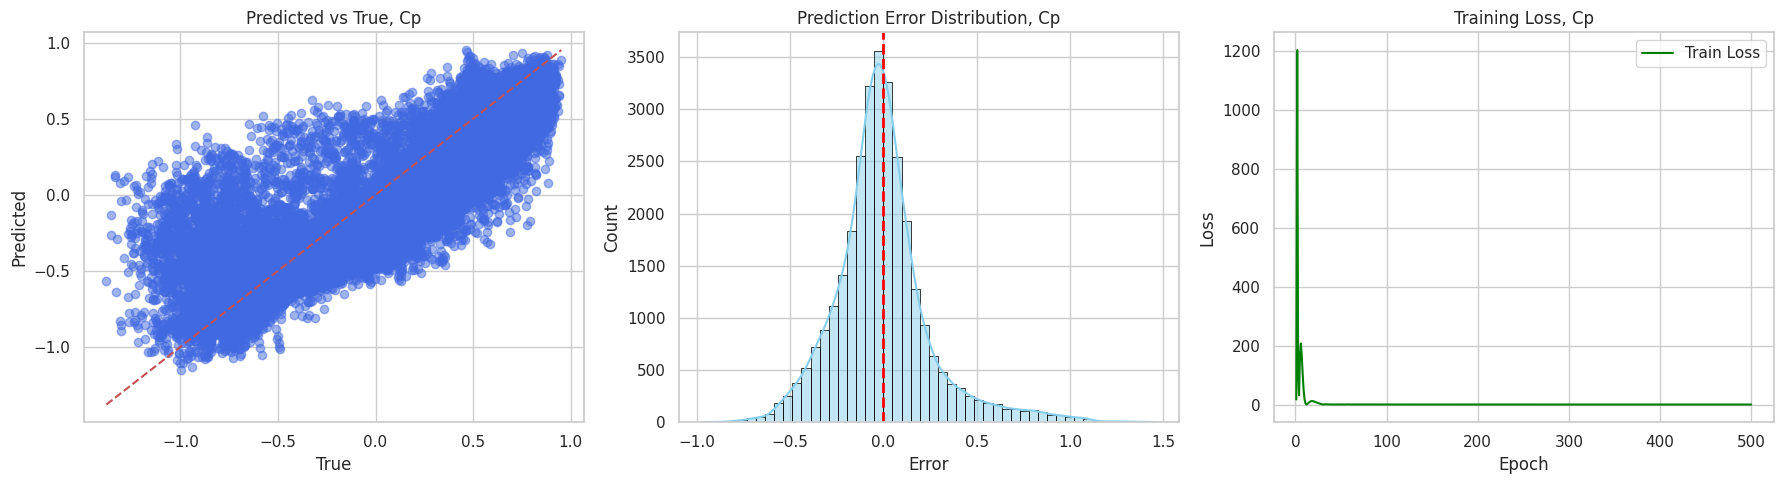

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 14/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 123.96it/s]

Epoch [10/500], Loss: 0.2483
Epoch [20/500], Loss: 1.6273
Epoch [30/500], Loss: 0.7339


Epochs:  10%|█         | 52/500 [00:00<00:03, 123.08it/s]

Epoch [40/500], Loss: 0.2494
Epoch [50/500], Loss: 0.2186
Epoch [60/500], Loss: 0.2116


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 122.80it/s]

Epoch [70/500], Loss: 0.2025
Epoch [80/500], Loss: 0.1998
Epoch [90/500], Loss: 0.1908


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 122.85it/s]

Epoch [100/500], Loss: 0.1665
Epoch [110/500], Loss: 0.1404
Epoch [120/500], Loss: 0.1311


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 122.38it/s]

Epoch [130/500], Loss: 0.1218
Epoch [140/500], Loss: 0.1141
Epoch [150/500], Loss: 0.1085


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 122.72it/s]

Epoch [160/500], Loss: 0.1043
Epoch [170/500], Loss: 0.1009
Epoch [180/500], Loss: 0.0996


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 122.55it/s]

Epoch [190/500], Loss: 0.0969
Epoch [200/500], Loss: 0.0946
Epoch [210/500], Loss: 0.0930


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 122.94it/s]

Epoch [220/500], Loss: 0.0915
Epoch [230/500], Loss: 0.0900
Epoch [240/500], Loss: 0.0884


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 122.98it/s]

Epoch [250/500], Loss: 0.0872
Epoch [260/500], Loss: 0.0861
Epoch [270/500], Loss: 0.0845


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 122.24it/s]

Epoch [280/500], Loss: 0.0830
Epoch [290/500], Loss: 0.0817
Epoch [300/500], Loss: 0.0804


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 122.70it/s]

Epoch [310/500], Loss: 0.0801
Epoch [320/500], Loss: 0.0800
Epoch [330/500], Loss: 0.0779


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 122.86it/s]

Epoch [340/500], Loss: 0.0763
Epoch [350/500], Loss: 0.0757
Epoch [360/500], Loss: 0.0752


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 122.65it/s]

Epoch [370/500], Loss: 0.0744
Epoch [380/500], Loss: 0.0744
Epoch [390/500], Loss: 0.0745


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 121.92it/s]

Epoch [400/500], Loss: 0.0732
Epoch [410/500], Loss: 0.0727
Epoch [420/500], Loss: 0.0723


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 121.76it/s]

Epoch [430/500], Loss: 0.0719
Epoch [440/500], Loss: 0.0743
Epoch [450/500], Loss: 0.0751


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 122.41it/s]

Epoch [460/500], Loss: 0.0732
Epoch [470/500], Loss: 0.0725
Epoch [480/500], Loss: 0.0719


Epochs: 100%|██████████| 500/500 [00:04<00:00, 122.58it/s]


Epoch [490/500], Loss: 0.0714
Epoch [500/500], Loss: 0.0711
📈 Evaluation metrics on test set:
MSE: 0.0727
MAE: 0.1886
R2: 0.7069


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


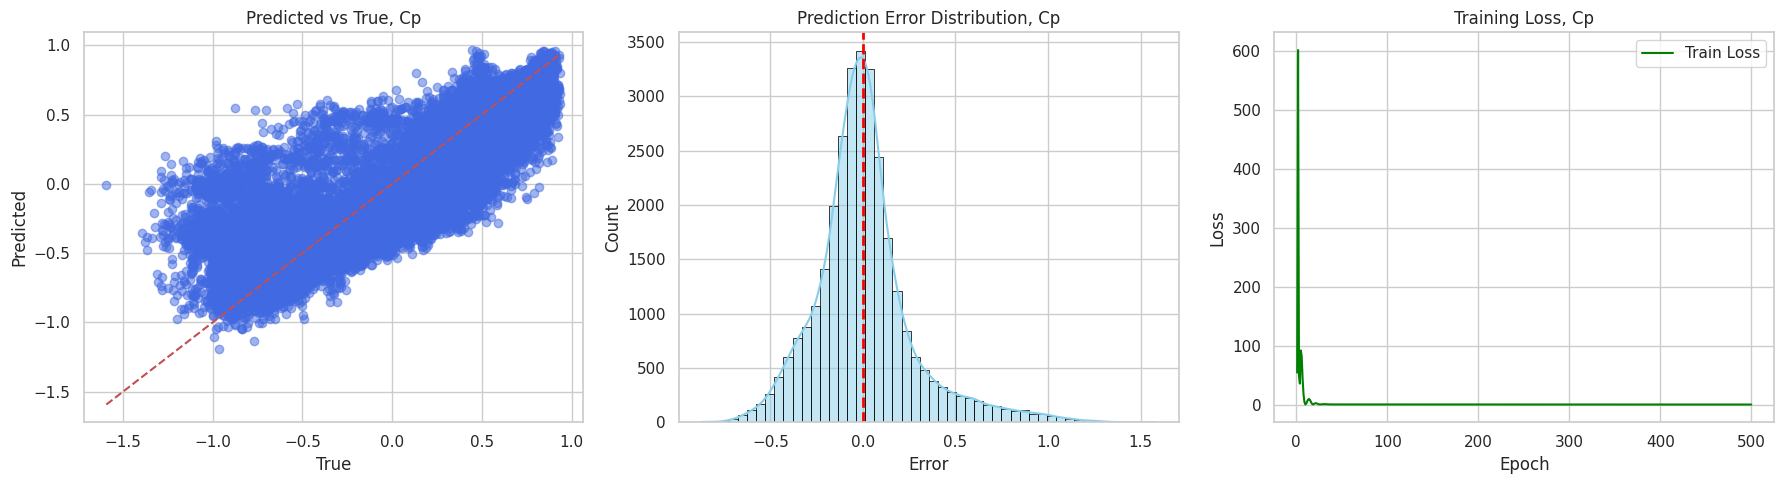

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 15/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 124.40it/s]

Epoch [10/500], Loss: 20.7264
Epoch [20/500], Loss: 2.1774
Epoch [30/500], Loss: 0.2492


Epochs:  13%|█▎        | 65/500 [00:00<00:03, 123.55it/s]

Epoch [40/500], Loss: 0.2453
Epoch [50/500], Loss: 0.2414
Epoch [60/500], Loss: 0.2391


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 123.58it/s]

Epoch [70/500], Loss: 0.2365
Epoch [80/500], Loss: 0.2338
Epoch [90/500], Loss: 0.2307


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 124.13it/s]

Epoch [100/500], Loss: 0.2254
Epoch [110/500], Loss: 0.2156
Epoch [120/500], Loss: 0.2007


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 123.42it/s]

Epoch [130/500], Loss: 0.1894
Epoch [140/500], Loss: 0.1721
Epoch [150/500], Loss: 0.1508


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 123.27it/s]

Epoch [160/500], Loss: 0.1305
Epoch [170/500], Loss: 0.1153
Epoch [180/500], Loss: 0.1057


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 123.46it/s]

Epoch [190/500], Loss: 0.0999
Epoch [200/500], Loss: 0.0966
Epoch [210/500], Loss: 0.0941


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 123.34it/s]

Epoch [220/500], Loss: 0.0922
Epoch [230/500], Loss: 0.0904
Epoch [240/500], Loss: 0.0889


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 122.74it/s]

Epoch [250/500], Loss: 0.0876
Epoch [260/500], Loss: 0.0874
Epoch [270/500], Loss: 0.0836


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 122.51it/s]

Epoch [280/500], Loss: 0.0817
Epoch [290/500], Loss: 0.0804
Epoch [300/500], Loss: 0.0791


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 122.45it/s]

Epoch [310/500], Loss: 0.0781
Epoch [320/500], Loss: 0.0771
Epoch [330/500], Loss: 0.0762


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 122.47it/s]

Epoch [340/500], Loss: 0.0754
Epoch [350/500], Loss: 0.0748
Epoch [360/500], Loss: 0.0750


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 122.30it/s]

Epoch [370/500], Loss: 0.0738
Epoch [380/500], Loss: 0.0733
Epoch [390/500], Loss: 0.0728


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 121.94it/s]

Epoch [400/500], Loss: 0.0722
Epoch [410/500], Loss: 0.0718
Epoch [420/500], Loss: 0.0713


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 122.31it/s]

Epoch [430/500], Loss: 0.0719
Epoch [440/500], Loss: 0.0706
Epoch [450/500], Loss: 0.0723


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 122.30it/s]

Epoch [460/500], Loss: 0.0713
Epoch [470/500], Loss: 0.0704
Epoch [480/500], Loss: 0.0692


Epochs: 100%|██████████| 500/500 [00:04<00:00, 122.85it/s]


Epoch [490/500], Loss: 0.0681
Epoch [500/500], Loss: 0.0671
📈 Evaluation metrics on test set:
MSE: 0.0665
MAE: 0.1764
R2: 0.7286


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


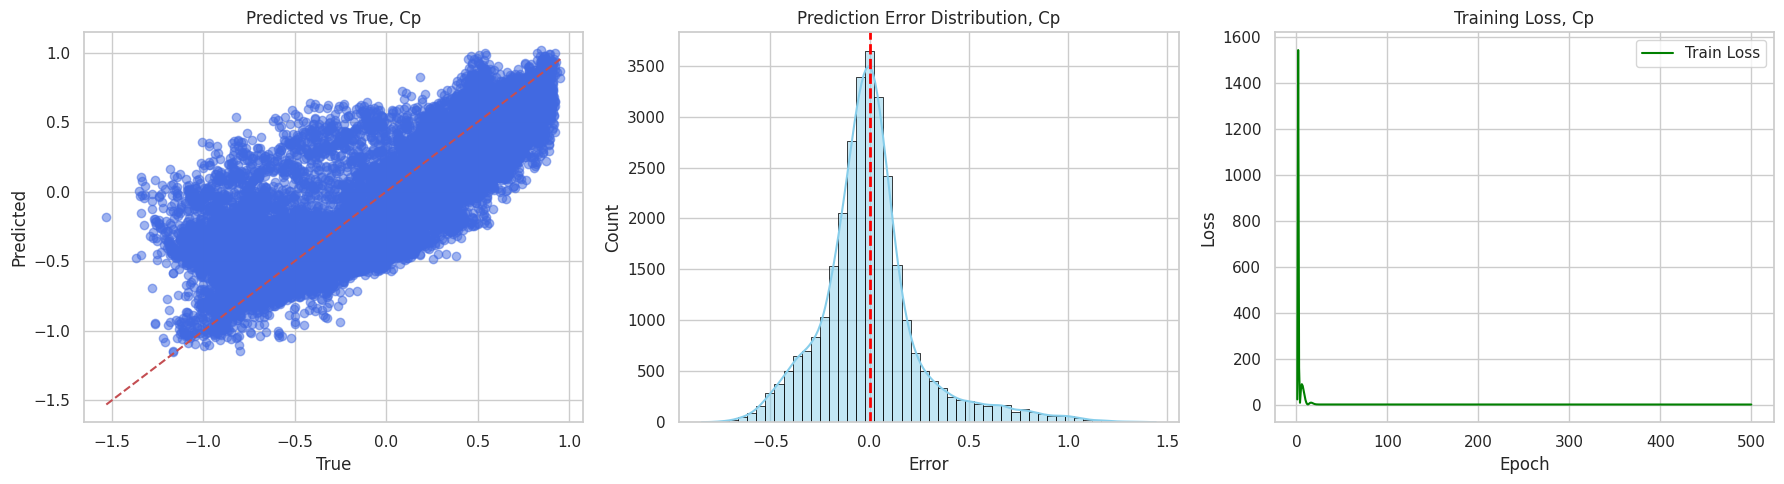

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 16/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 122.99it/s]

Epoch [10/500], Loss: 1.2409
Epoch [20/500], Loss: 6.3824
Epoch [30/500], Loss: 0.2945


Epochs:  10%|█         | 52/500 [00:00<00:03, 122.04it/s]

Epoch [40/500], Loss: 0.5216
Epoch [50/500], Loss: 0.2927
Epoch [60/500], Loss: 0.2440


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 121.82it/s]

Epoch [70/500], Loss: 0.2333
Epoch [80/500], Loss: 0.2322
Epoch [90/500], Loss: 0.2250


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 122.23it/s]

Epoch [100/500], Loss: 0.2207
Epoch [110/500], Loss: 0.2182
Epoch [120/500], Loss: 0.2161


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 122.27it/s]

Epoch [130/500], Loss: 0.2142
Epoch [140/500], Loss: 0.2125
Epoch [150/500], Loss: 0.2111


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 121.45it/s]

Epoch [160/500], Loss: 0.2097
Epoch [170/500], Loss: 0.2025
Epoch [180/500], Loss: 0.1814


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 121.34it/s]

Epoch [190/500], Loss: 0.1672
Epoch [200/500], Loss: 0.1523
Epoch [210/500], Loss: 0.1342


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 120.98it/s]

Epoch [220/500], Loss: 0.1252
Epoch [230/500], Loss: 0.1178
Epoch [240/500], Loss: 0.1131


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 121.47it/s]

Epoch [250/500], Loss: 0.1100
Epoch [260/500], Loss: 0.5281
Epoch [270/500], Loss: 0.1765


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 121.24it/s]

Epoch [280/500], Loss: 0.1266
Epoch [290/500], Loss: 0.1293
Epoch [300/500], Loss: 0.1216


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 120.98it/s]

Epoch [310/500], Loss: 0.1147
Epoch [320/500], Loss: 0.1112
Epoch [330/500], Loss: 0.1075


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 121.80it/s]

Epoch [340/500], Loss: 0.1049
Epoch [350/500], Loss: 0.1030
Epoch [360/500], Loss: 0.1015


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 121.49it/s]

Epoch [370/500], Loss: 0.1002
Epoch [380/500], Loss: 0.0990
Epoch [390/500], Loss: 0.0979


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 121.31it/s]

Epoch [400/500], Loss: 0.0969
Epoch [410/500], Loss: 0.0960
Epoch [420/500], Loss: 0.0951


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 121.60it/s]

Epoch [430/500], Loss: 0.0944
Epoch [440/500], Loss: 0.0934
Epoch [450/500], Loss: 0.0924


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 120.99it/s]

Epoch [460/500], Loss: 0.0913
Epoch [470/500], Loss: 0.0904
Epoch [480/500], Loss: 0.0896


Epochs: 100%|██████████| 500/500 [00:04<00:00, 121.52it/s]


Epoch [490/500], Loss: 0.0885
Epoch [500/500], Loss: 0.0873
📈 Evaluation metrics on test set:
MSE: 0.0893
MAE: 0.2140
R2: 0.6409


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


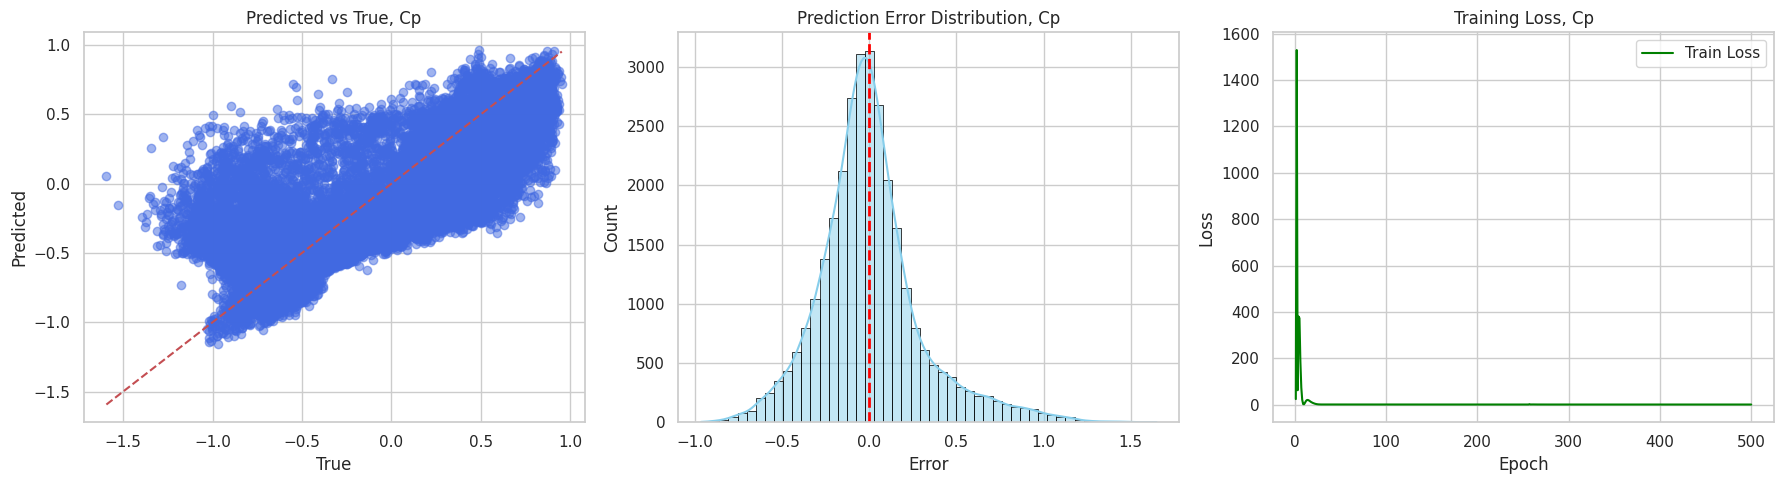

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 17/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 125.28it/s]

Epoch [10/500], Loss: 5.1275
Epoch [20/500], Loss: 0.5297


Epochs:   5%|▌         | 26/500 [00:00<00:03, 122.57it/s]

Epoch [30/500], Loss: 0.5452


Epochs:  10%|█         | 52/500 [00:00<00:03, 122.19it/s]

Epoch [40/500], Loss: 0.3881
Epoch [50/500], Loss: 0.2770
Epoch [60/500], Loss: 0.2177


Epochs:  16%|█▌        | 78/500 [00:00<00:03, 121.68it/s]

Epoch [70/500], Loss: 0.2025
Epoch [80/500], Loss: 0.1981


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 122.15it/s]

Epoch [90/500], Loss: 0.1949


Epochs:  21%|██        | 104/500 [00:00<00:03, 121.81it/s]

Epoch [100/500], Loss: 0.1804
Epoch [110/500], Loss: 0.1670


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 122.27it/s]

Epoch [120/500], Loss: 0.1437


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 122.19it/s]

Epoch [130/500], Loss: 0.1216
Epoch [140/500], Loss: 0.1108
Epoch [150/500], Loss: 0.1075


Epochs:  34%|███▍      | 169/500 [00:01<00:02, 121.89it/s]

Epoch [160/500], Loss: 0.1052
Epoch [170/500], Loss: 0.1027


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 122.05it/s]

Epoch [180/500], Loss: 0.0993


Epochs:  39%|███▉      | 195/500 [00:01<00:02, 121.62it/s]

Epoch [190/500], Loss: 0.0951
Epoch [200/500], Loss: 0.0918


Epochs:  42%|████▏     | 208/500 [00:01<00:02, 121.38it/s]

Epoch [210/500], Loss: 0.0881


Epochs:  47%|████▋     | 234/500 [00:01<00:02, 121.77it/s]

Epoch [220/500], Loss: 0.0857
Epoch [230/500], Loss: 0.0840
Epoch [240/500], Loss: 0.0827


Epochs:  52%|█████▏    | 260/500 [00:02<00:01, 121.34it/s]

Epoch [250/500], Loss: 0.0815
Epoch [260/500], Loss: 0.0805


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 121.87it/s]

Epoch [270/500], Loss: 0.0800


Epochs:  57%|█████▋    | 286/500 [00:02<00:01, 121.50it/s]

Epoch [280/500], Loss: 0.0785
Epoch [290/500], Loss: 0.0779


Epochs:  60%|█████▉    | 299/500 [00:02<00:01, 121.91it/s]

Epoch [300/500], Loss: 0.0772


Epochs:  62%|██████▏   | 312/500 [00:02<00:01, 121.59it/s]

Epoch [310/500], Loss: 0.0760
Epoch [320/500], Loss: 0.0757


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 121.48it/s]

Epoch [330/500], Loss: 0.0753


Epochs:  70%|███████   | 351/500 [00:02<00:01, 121.51it/s]

Epoch [340/500], Loss: 0.0741
Epoch [350/500], Loss: 0.0736


Epochs:  73%|███████▎  | 364/500 [00:02<00:01, 121.87it/s]

Epoch [360/500], Loss: 0.0731


Epochs:  75%|███████▌  | 377/500 [00:03<00:01, 121.70it/s]

Epoch [370/500], Loss: 0.0726
Epoch [380/500], Loss: 0.0721


Epochs:  78%|███████▊  | 390/500 [00:03<00:00, 121.64it/s]

Epoch [390/500], Loss: 0.0716


Epochs:  81%|████████  | 403/500 [00:03<00:00, 121.33it/s]

Epoch [400/500], Loss: 0.0711
Epoch [410/500], Loss: 0.0706


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 121.88it/s]

Epoch [420/500], Loss: 0.0701


Epochs:  88%|████████▊ | 442/500 [00:03<00:00, 121.44it/s]

Epoch [430/500], Loss: 0.0699
Epoch [440/500], Loss: 0.0691
Epoch [450/500], Loss: 0.0690


Epochs:  94%|█████████▎| 468/500 [00:03<00:00, 121.07it/s]

Epoch [460/500], Loss: 0.0684
Epoch [470/500], Loss: 0.0679


Epochs:  96%|█████████▌| 481/500 [00:03<00:00, 120.81it/s]

Epoch [480/500], Loss: 0.0675


Epochs: 100%|██████████| 500/500 [00:04<00:00, 121.65it/s]

Epoch [490/500], Loss: 0.0690
Epoch [500/500], Loss: 0.0670
📈 Evaluation metrics on test set:
MSE: 0.0665
MAE: 0.1794
R2: 0.7291



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


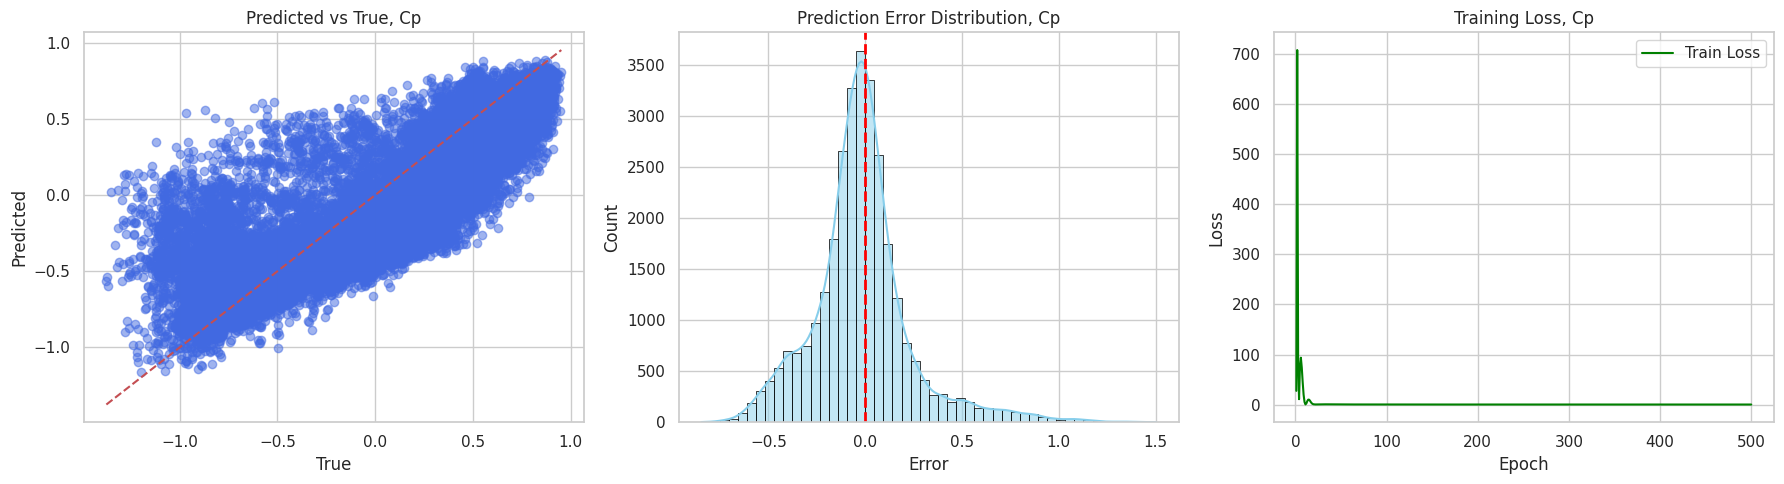

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 18/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 100.86it/s]

Epoch [10/500], Loss: 15.4620
Epoch [20/500], Loss: 0.2488
Epoch [30/500], Loss: 0.8153


Epochs:  12%|█▏        | 59/500 [00:00<00:03, 115.49it/s]

Epoch [40/500], Loss: 0.3301
Epoch [50/500], Loss: 0.2773
Epoch [60/500], Loss: 0.2210


Epochs:  17%|█▋        | 85/500 [00:00<00:03, 118.76it/s]

Epoch [70/500], Loss: 0.2153
Epoch [80/500], Loss: 0.2094
Epoch [90/500], Loss: 0.2064


Epochs:  25%|██▍       | 124/500 [00:01<00:03, 121.06it/s]

Epoch [100/500], Loss: 0.2033
Epoch [110/500], Loss: 0.2004
Epoch [120/500], Loss: 0.1972


Epochs:  30%|███       | 150/500 [00:01<00:02, 121.31it/s]

Epoch [130/500], Loss: 0.1845
Epoch [140/500], Loss: 0.1713
Epoch [150/500], Loss: 0.1628


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 121.10it/s]

Epoch [160/500], Loss: 0.1569
Epoch [170/500], Loss: 0.1515
Epoch [180/500], Loss: 0.1465


Epochs:  40%|████      | 202/500 [00:01<00:02, 120.69it/s]

Epoch [190/500], Loss: 0.1371
Epoch [200/500], Loss: 0.1253
Epoch [210/500], Loss: 0.1161


Epochs:  48%|████▊     | 241/500 [00:02<00:02, 121.43it/s]

Epoch [220/500], Loss: 0.1161
Epoch [230/500], Loss: 0.1092
Epoch [240/500], Loss: 0.1071


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 121.66it/s]

Epoch [250/500], Loss: 0.1058
Epoch [260/500], Loss: 0.1051
Epoch [270/500], Loss: 0.1031


Epochs:  59%|█████▊    | 293/500 [00:02<00:01, 120.88it/s]

Epoch [280/500], Loss: 0.1017
Epoch [290/500], Loss: 0.1009
Epoch [300/500], Loss: 0.0999


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 120.59it/s]

Epoch [310/500], Loss: 0.0989
Epoch [320/500], Loss: 0.0968
Epoch [330/500], Loss: 0.0932


Epochs:  72%|███████▏  | 358/500 [00:03<00:01, 120.52it/s]

Epoch [340/500], Loss: 0.0903
Epoch [350/500], Loss: 0.0855
Epoch [360/500], Loss: 0.0835


Epochs:  77%|███████▋  | 384/500 [00:03<00:00, 120.38it/s]

Epoch [370/500], Loss: 0.0822
Epoch [380/500], Loss: 0.0804
Epoch [390/500], Loss: 0.0821


Epochs:  85%|████████▍ | 423/500 [00:03<00:00, 120.57it/s]

Epoch [400/500], Loss: 0.0791
Epoch [410/500], Loss: 0.0780
Epoch [420/500], Loss: 0.0773


Epochs:  90%|████████▉ | 449/500 [00:03<00:00, 120.57it/s]

Epoch [430/500], Loss: 0.0767
Epoch [440/500], Loss: 0.0765
Epoch [450/500], Loss: 0.0763


Epochs:  95%|█████████▌| 475/500 [00:03<00:00, 120.17it/s]

Epoch [460/500], Loss: 0.0761
Epoch [470/500], Loss: 0.0757
Epoch [480/500], Loss: 0.0747


Epochs: 100%|██████████| 500/500 [00:04<00:00, 119.57it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0747
Epoch [500/500], Loss: 0.0745
📈 Evaluation metrics on test set:
MSE: 0.0745
MAE: 0.1877
R2: 0.7013


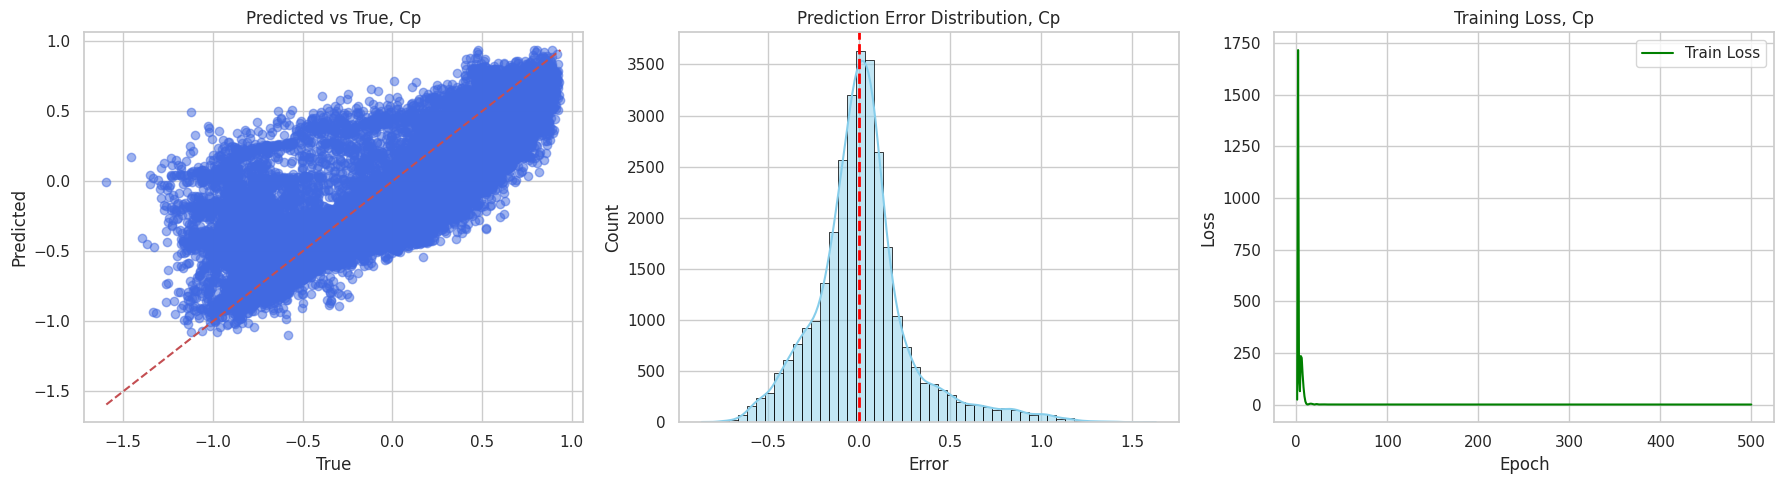

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 19/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 122.33it/s]

Epoch [10/500], Loss: 2.8493
Epoch [20/500], Loss: 0.5765
Epoch [30/500], Loss: 0.3383


Epochs:  10%|█         | 52/500 [00:00<00:03, 122.34it/s]

Epoch [40/500], Loss: 0.2104
Epoch [50/500], Loss: 0.2199
Epoch [60/500], Loss: 0.2154


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 121.21it/s]

Epoch [70/500], Loss: 0.2086
Epoch [80/500], Loss: 0.2015
Epoch [90/500], Loss: 0.1940


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 120.71it/s]

Epoch [100/500], Loss: 0.1855
Epoch [110/500], Loss: 0.1657
Epoch [120/500], Loss: 0.1473


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 120.38it/s]

Epoch [130/500], Loss: 0.1331
Epoch [140/500], Loss: 0.1243
Epoch [150/500], Loss: 0.1178


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 119.99it/s]

Epoch [160/500], Loss: 0.1132
Epoch [170/500], Loss: 0.1097
Epoch [180/500], Loss: 0.1068


Epochs:  41%|████▏     | 207/500 [00:01<00:02, 119.66it/s]

Epoch [190/500], Loss: 0.1040
Epoch [200/500], Loss: 0.1002
Epoch [210/500], Loss: 0.0948


Epochs:  49%|████▊     | 243/500 [00:02<00:02, 119.21it/s]

Epoch [220/500], Loss: 0.0892
Epoch [230/500], Loss: 0.0860
Epoch [240/500], Loss: 0.0839


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 119.11it/s]

Epoch [250/500], Loss: 0.0842
Epoch [260/500], Loss: 0.0827
Epoch [270/500], Loss: 0.0805


Epochs:  61%|██████    | 303/500 [00:02<00:01, 119.41it/s]

Epoch [280/500], Loss: 0.0798
Epoch [290/500], Loss: 0.0792
Epoch [300/500], Loss: 0.0800


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 119.50it/s]

Epoch [310/500], Loss: 0.0790
Epoch [320/500], Loss: 0.0781
Epoch [330/500], Loss: 0.0774


Epochs:  73%|███████▎  | 363/500 [00:03<00:01, 119.48it/s]

Epoch [340/500], Loss: 0.0849
Epoch [350/500], Loss: 0.0843
Epoch [360/500], Loss: 0.0812


Epochs:  78%|███████▊  | 388/500 [00:03<00:00, 120.03it/s]

Epoch [370/500], Loss: 0.0780
Epoch [380/500], Loss: 0.0764
Epoch [390/500], Loss: 0.0757


Epochs:  83%|████████▎ | 413/500 [00:03<00:00, 119.86it/s]

Epoch [400/500], Loss: 0.0755
Epoch [410/500], Loss: 0.0750
Epoch [420/500], Loss: 0.0746


Epochs:  90%|█████████ | 450/500 [00:03<00:00, 119.87it/s]

Epoch [430/500], Loss: 0.0742
Epoch [440/500], Loss: 0.0738
Epoch [450/500], Loss: 0.0733


Epochs:  95%|█████████▍| 474/500 [00:03<00:00, 119.70it/s]

Epoch [460/500], Loss: 0.0728
Epoch [470/500], Loss: 0.0724
Epoch [480/500], Loss: 0.0720


Epochs: 100%|██████████| 500/500 [00:04<00:00, 120.05it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0720
Epoch [500/500], Loss: 0.0714
📈 Evaluation metrics on test set:
MSE: 0.0715
MAE: 0.1872
R2: 0.7124


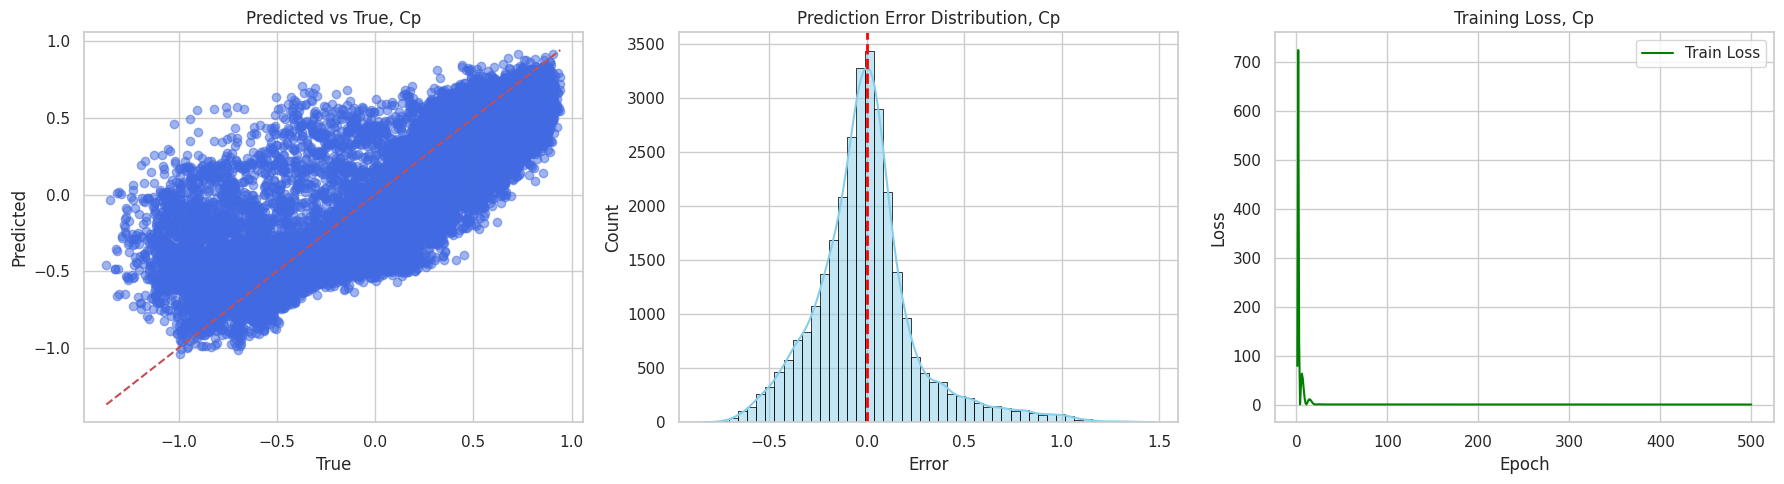

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 20/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 120.70it/s]

Epoch [10/500], Loss: 7.0332
Epoch [20/500], Loss: 0.9161
Epoch [30/500], Loss: 0.9790


Epochs:  10%|█         | 52/500 [00:00<00:03, 120.14it/s]

Epoch [40/500], Loss: 0.6432
Epoch [50/500], Loss: 0.3547
Epoch [60/500], Loss: 0.2731


Epochs:  18%|█▊        | 91/500 [00:00<00:03, 120.24it/s]

Epoch [70/500], Loss: 0.2586
Epoch [80/500], Loss: 0.2559
Epoch [90/500], Loss: 0.2537


Epochs:  23%|██▎       | 117/500 [00:00<00:03, 120.34it/s]

Epoch [100/500], Loss: 0.2510
Epoch [110/500], Loss: 0.2482
Epoch [120/500], Loss: 0.2456


Epochs:  29%|██▊       | 143/500 [00:01<00:02, 120.32it/s]

Epoch [130/500], Loss: 0.2414
Epoch [140/500], Loss: 0.2298
Epoch [150/500], Loss: 0.2128


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 120.07it/s]

Epoch [160/500], Loss: 0.1829
Epoch [170/500], Loss: 0.1441
Epoch [180/500], Loss: 0.1348


Epochs:  41%|████▏     | 207/500 [00:01<00:02, 119.84it/s]

Epoch [190/500], Loss: 0.1266
Epoch [200/500], Loss: 0.1219
Epoch [210/500], Loss: 0.1181


Epochs:  49%|████▊     | 243/500 [00:02<00:02, 119.46it/s]

Epoch [220/500], Loss: 0.1149
Epoch [230/500], Loss: 0.1120
Epoch [240/500], Loss: 0.1097


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 119.09it/s]

Epoch [250/500], Loss: 0.1065
Epoch [260/500], Loss: 0.1041
Epoch [270/500], Loss: 0.1023


Epochs:  61%|██████    | 303/500 [00:02<00:01, 119.19it/s]

Epoch [280/500], Loss: 0.1004
Epoch [290/500], Loss: 0.0974
Epoch [300/500], Loss: 0.0935


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 119.07it/s]

Epoch [310/500], Loss: 0.0901
Epoch [320/500], Loss: 0.0876
Epoch [330/500], Loss: 0.0854


Epochs:  73%|███████▎  | 363/500 [00:03<00:01, 119.02it/s]

Epoch [340/500], Loss: 0.0832
Epoch [350/500], Loss: 0.0816
Epoch [360/500], Loss: 0.0800


Epochs:  77%|███████▋  | 387/500 [00:03<00:00, 118.89it/s]

Epoch [370/500], Loss: 0.0779
Epoch [380/500], Loss: 0.0796
Epoch [390/500], Loss: 0.0769


Epochs:  85%|████████▍ | 423/500 [00:03<00:00, 118.86it/s]

Epoch [400/500], Loss: 0.0742
Epoch [410/500], Loss: 0.0733
Epoch [420/500], Loss: 0.0724


Epochs:  89%|████████▉ | 447/500 [00:03<00:00, 118.94it/s]

Epoch [430/500], Loss: 0.0715
Epoch [440/500], Loss: 0.0707
Epoch [450/500], Loss: 0.0709


Epochs:  97%|█████████▋| 483/500 [00:04<00:00, 118.73it/s]

Epoch [460/500], Loss: 0.0700
Epoch [470/500], Loss: 0.0693
Epoch [480/500], Loss: 0.0684


Epochs: 100%|██████████| 500/500 [00:04<00:00, 119.38it/s]


Epoch [490/500], Loss: 0.0679
Epoch [500/500], Loss: 0.0680
📈 Evaluation metrics on test set:
MSE: 0.0695
MAE: 0.1869
R2: 0.7221


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


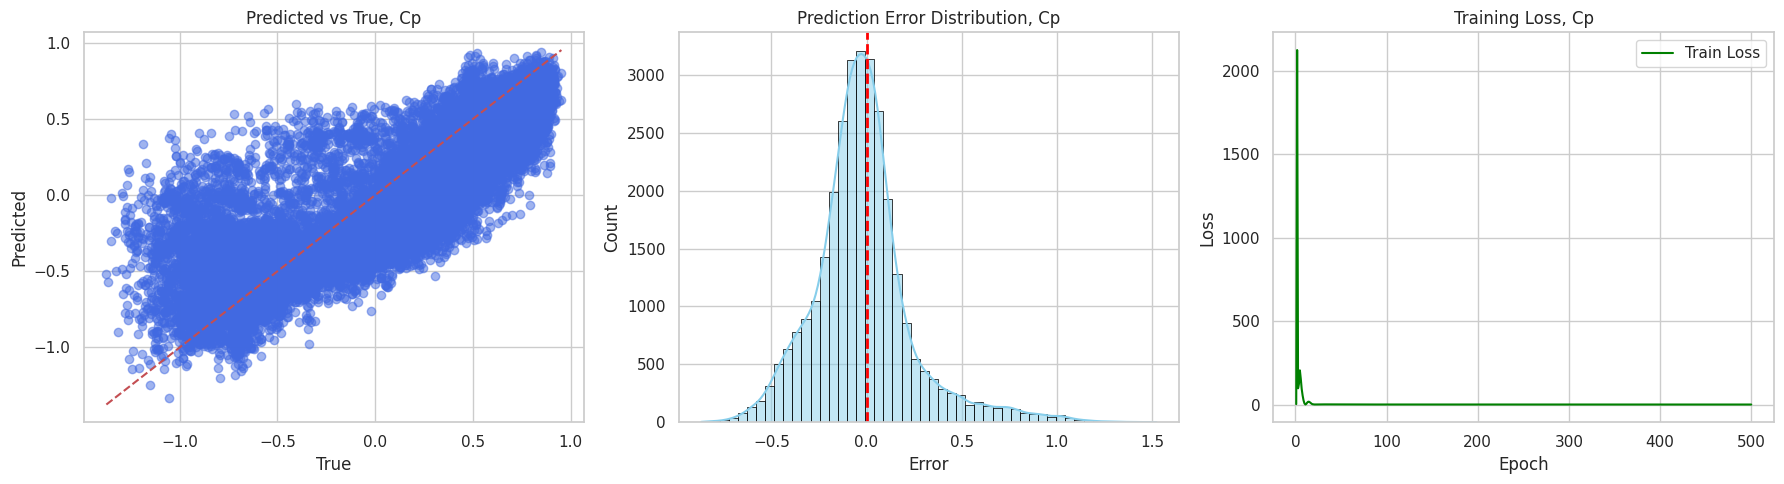

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 21/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 120.21it/s]

Epoch [10/500], Loss: 49.7501
Epoch [20/500], Loss: 15.3464
Epoch [30/500], Loss: 2.2126


Epochs:  13%|█▎        | 63/500 [00:00<00:03, 118.62it/s]

Epoch [40/500], Loss: 0.2599
Epoch [50/500], Loss: 0.2751
Epoch [60/500], Loss: 0.2739


Epochs:  17%|█▋        | 87/500 [00:00<00:03, 118.48it/s]

Epoch [70/500], Loss: 0.2470
Epoch [80/500], Loss: 0.2339
Epoch [90/500], Loss: 0.2256


Epochs:  25%|██▍       | 123/500 [00:01<00:03, 118.61it/s]

Epoch [100/500], Loss: 0.2188
Epoch [110/500], Loss: 0.2150
Epoch [120/500], Loss: 0.2124


Epochs:  29%|██▉       | 147/500 [00:01<00:02, 118.14it/s]

Epoch [130/500], Loss: 0.2101
Epoch [140/500], Loss: 0.2082
Epoch [150/500], Loss: 0.2064


Epochs:  37%|███▋      | 183/500 [00:01<00:02, 118.57it/s]

Epoch [160/500], Loss: 0.2049
Epoch [170/500], Loss: 0.2035
Epoch [180/500], Loss: 0.2019


Epochs:  41%|████▏     | 207/500 [00:01<00:02, 118.52it/s]

Epoch [190/500], Loss: 0.1785
Epoch [200/500], Loss: 0.1639
Epoch [210/500], Loss: 0.1530


Epochs:  49%|████▊     | 243/500 [00:02<00:02, 118.31it/s]

Epoch [220/500], Loss: 0.1440
Epoch [230/500], Loss: 0.1373
Epoch [240/500], Loss: 0.1320


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 117.89it/s]

Epoch [250/500], Loss: 0.1277
Epoch [260/500], Loss: 0.1242
Epoch [270/500], Loss: 0.1213


Epochs:  61%|██████    | 303/500 [00:02<00:01, 118.01it/s]

Epoch [280/500], Loss: 0.1188
Epoch [290/500], Loss: 0.1168
Epoch [300/500], Loss: 0.1152


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 118.04it/s]

Epoch [310/500], Loss: 0.1139
Epoch [320/500], Loss: 0.1127
Epoch [330/500], Loss: 0.1118


Epochs:  73%|███████▎  | 363/500 [00:03<00:01, 118.27it/s]

Epoch [340/500], Loss: 0.1103
Epoch [350/500], Loss: 0.1093
Epoch [360/500], Loss: 0.1084


Epochs:  77%|███████▋  | 387/500 [00:03<00:00, 118.10it/s]

Epoch [370/500], Loss: 0.1081
Epoch [380/500], Loss: 0.1071
Epoch [390/500], Loss: 0.1064


Epochs:  85%|████████▍ | 423/500 [00:03<00:00, 117.98it/s]

Epoch [400/500], Loss: 0.1056
Epoch [410/500], Loss: 0.1060
Epoch [420/500], Loss: 0.1127


Epochs:  89%|████████▉ | 447/500 [00:03<00:00, 118.17it/s]

Epoch [430/500], Loss: 0.1066
Epoch [440/500], Loss: 0.1048
Epoch [450/500], Loss: 0.1044


Epochs:  97%|█████████▋| 483/500 [00:04<00:00, 117.39it/s]

Epoch [460/500], Loss: 0.1038
Epoch [470/500], Loss: 0.1033
Epoch [480/500], Loss: 0.1028


Epochs: 100%|██████████| 500/500 [00:04<00:00, 118.17it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.1025
Epoch [500/500], Loss: 0.1022
📈 Evaluation metrics on test set:
MSE: 0.1031
MAE: 0.2319
R2: 0.5835


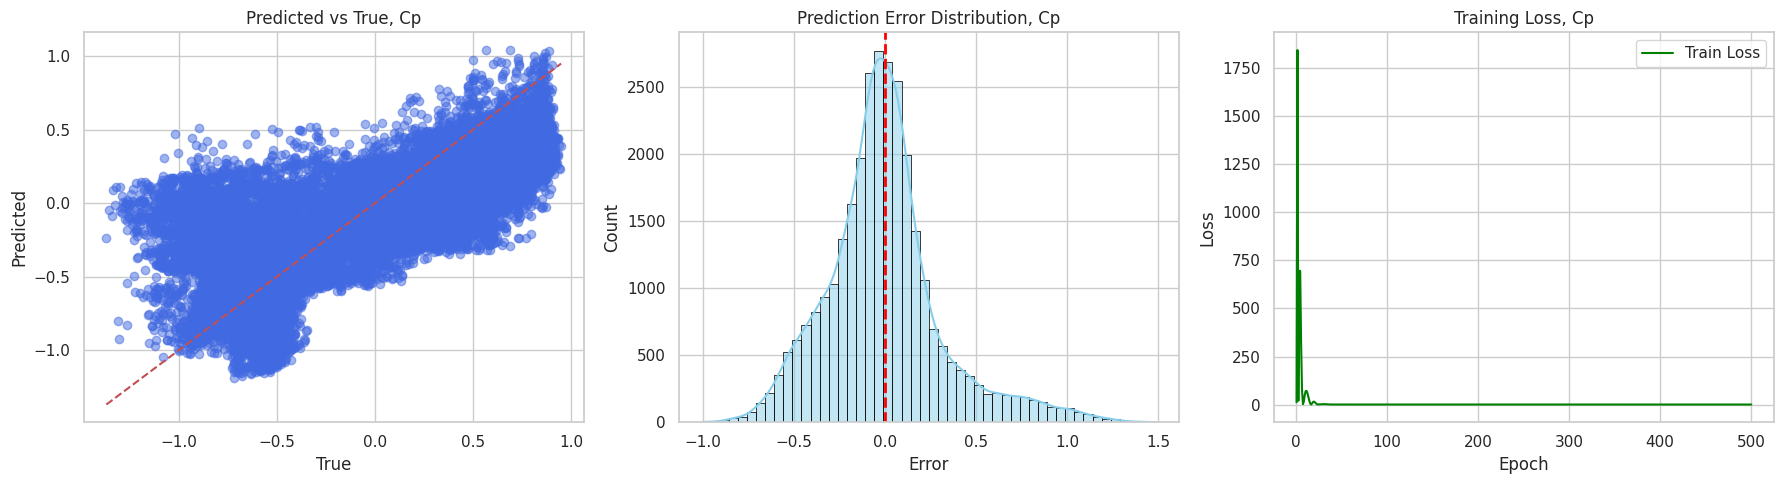

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 22/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 120.91it/s]

Epoch [10/500], Loss: 7.4855
Epoch [20/500], Loss: 0.3227
Epoch [30/500], Loss: 0.6174


Epochs:  13%|█▎        | 63/500 [00:00<00:03, 119.66it/s]

Epoch [40/500], Loss: 0.3250
Epoch [50/500], Loss: 0.2361
Epoch [60/500], Loss: 0.2304


Epochs:  17%|█▋        | 87/500 [00:00<00:03, 119.19it/s]

Epoch [70/500], Loss: 0.2075
Epoch [80/500], Loss: 0.1971
Epoch [90/500], Loss: 0.1909


Epochs:  25%|██▍       | 123/500 [00:01<00:03, 119.02it/s]

Epoch [100/500], Loss: 0.1859
Epoch [110/500], Loss: 0.1853
Epoch [120/500], Loss: 0.1790


Epochs:  29%|██▉       | 147/500 [00:01<00:02, 118.87it/s]

Epoch [130/500], Loss: 0.1884
Epoch [140/500], Loss: 0.2121
Epoch [150/500], Loss: 0.2081


Epochs:  37%|███▋      | 183/500 [00:01<00:02, 119.18it/s]

Epoch [160/500], Loss: 0.1776
Epoch [170/500], Loss: 0.1712
Epoch [180/500], Loss: 0.1667


Epochs:  41%|████▏     | 207/500 [00:01<00:02, 118.95it/s]

Epoch [190/500], Loss: 0.1624
Epoch [200/500], Loss: 0.1583
Epoch [210/500], Loss: 0.1539


Epochs:  49%|████▊     | 243/500 [00:02<00:02, 118.44it/s]

Epoch [220/500], Loss: 0.1477
Epoch [230/500], Loss: 0.1399
Epoch [240/500], Loss: 0.1307


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 118.53it/s]

Epoch [250/500], Loss: 0.1226
Epoch [260/500], Loss: 0.1143
Epoch [270/500], Loss: 0.1091


Epochs:  61%|██████    | 303/500 [00:02<00:01, 118.52it/s]

Epoch [280/500], Loss: 0.1060
Epoch [290/500], Loss: 0.1008
Epoch [300/500], Loss: 0.0978


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 118.98it/s]

Epoch [310/500], Loss: 0.0956
Epoch [320/500], Loss: 0.0941
Epoch [330/500], Loss: 0.0926


Epochs:  73%|███████▎  | 363/500 [00:03<00:01, 118.75it/s]

Epoch [340/500], Loss: 0.0912
Epoch [350/500], Loss: 0.0899
Epoch [360/500], Loss: 0.0887


Epochs:  77%|███████▋  | 387/500 [00:03<00:00, 118.53it/s]

Epoch [370/500], Loss: 0.0871
Epoch [380/500], Loss: 0.0859
Epoch [390/500], Loss: 0.0842


Epochs:  85%|████████▍ | 423/500 [00:03<00:00, 118.32it/s]

Epoch [400/500], Loss: 0.0830
Epoch [410/500], Loss: 0.0818
Epoch [420/500], Loss: 0.0811


Epochs:  89%|████████▉ | 447/500 [00:03<00:00, 118.30it/s]

Epoch [430/500], Loss: 0.0805
Epoch [440/500], Loss: 0.0795
Epoch [450/500], Loss: 0.0791


Epochs:  97%|█████████▋| 483/500 [00:04<00:00, 118.63it/s]

Epoch [460/500], Loss: 0.0786
Epoch [470/500], Loss: 0.0782
Epoch [480/500], Loss: 0.0778


Epochs: 100%|██████████| 500/500 [00:04<00:00, 118.80it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0777
Epoch [500/500], Loss: 0.0773
📈 Evaluation metrics on test set:
MSE: 0.0769
MAE: 0.1960
R2: 0.6909


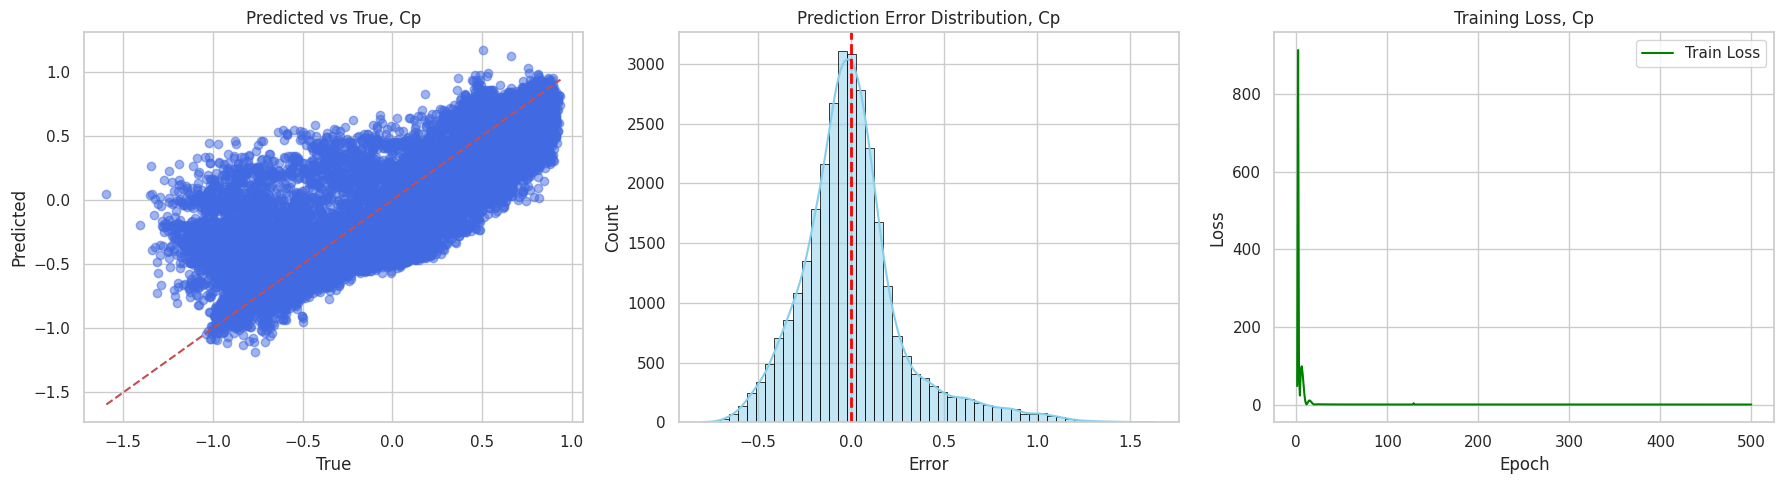

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 23/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 119.44it/s]

Epoch [10/500], Loss: 9.5358
Epoch [20/500], Loss: 0.2898
Epoch [30/500], Loss: 0.6212


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 118.62it/s]

Epoch [40/500], Loss: 0.3737
Epoch [50/500], Loss: 0.2687
Epoch [60/500], Loss: 0.2500


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 118.63it/s]

Epoch [70/500], Loss: 0.2434
Epoch [80/500], Loss: 0.2260
Epoch [90/500], Loss: 0.2162


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 118.37it/s]

Epoch [100/500], Loss: 0.2484
Epoch [110/500], Loss: 0.2119
Epoch [120/500], Loss: 0.2141


Epochs:  29%|██▉       | 146/500 [00:01<00:02, 118.09it/s]

Epoch [130/500], Loss: 0.2047
Epoch [140/500], Loss: 0.1786
Epoch [150/500], Loss: 0.1749


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.99it/s]

Epoch [160/500], Loss: 0.1665
Epoch [170/500], Loss: 0.1604
Epoch [180/500], Loss: 0.1554


Epochs:  41%|████      | 206/500 [00:01<00:02, 117.89it/s]

Epoch [190/500], Loss: 0.1499
Epoch [200/500], Loss: 0.1342
Epoch [210/500], Loss: 0.1252


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 118.16it/s]

Epoch [220/500], Loss: 0.1164
Epoch [230/500], Loss: 0.1129
Epoch [240/500], Loss: 0.1066


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 118.06it/s]

Epoch [250/500], Loss: 0.1010
Epoch [260/500], Loss: 0.1022
Epoch [270/500], Loss: 0.0976


Epochs:  60%|██████    | 302/500 [00:02<00:01, 118.00it/s]

Epoch [280/500], Loss: 0.0942
Epoch [290/500], Loss: 0.0921
Epoch [300/500], Loss: 0.0975


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 117.71it/s]

Epoch [310/500], Loss: 0.1042
Epoch [320/500], Loss: 0.0960
Epoch [330/500], Loss: 0.0853


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 117.75it/s]

Epoch [340/500], Loss: 0.0854
Epoch [350/500], Loss: 0.0829
Epoch [360/500], Loss: 0.0818


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 117.66it/s]

Epoch [370/500], Loss: 0.0806
Epoch [380/500], Loss: 0.0821
Epoch [390/500], Loss: 0.0991


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 117.51it/s]

Epoch [400/500], Loss: 0.0807
Epoch [410/500], Loss: 0.0796
Epoch [420/500], Loss: 0.0781


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 117.12it/s]

Epoch [430/500], Loss: 0.0773
Epoch [440/500], Loss: 0.0763
Epoch [450/500], Loss: 0.0761


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 117.12it/s]

Epoch [460/500], Loss: 0.0990
Epoch [470/500], Loss: 0.0788
Epoch [480/500], Loss: 0.0756


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.89it/s]


Epoch [490/500], Loss: 0.0745
Epoch [500/500], Loss: 0.0739
📈 Evaluation metrics on test set:
MSE: 0.0730
MAE: 0.1913
R2: 0.7041


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


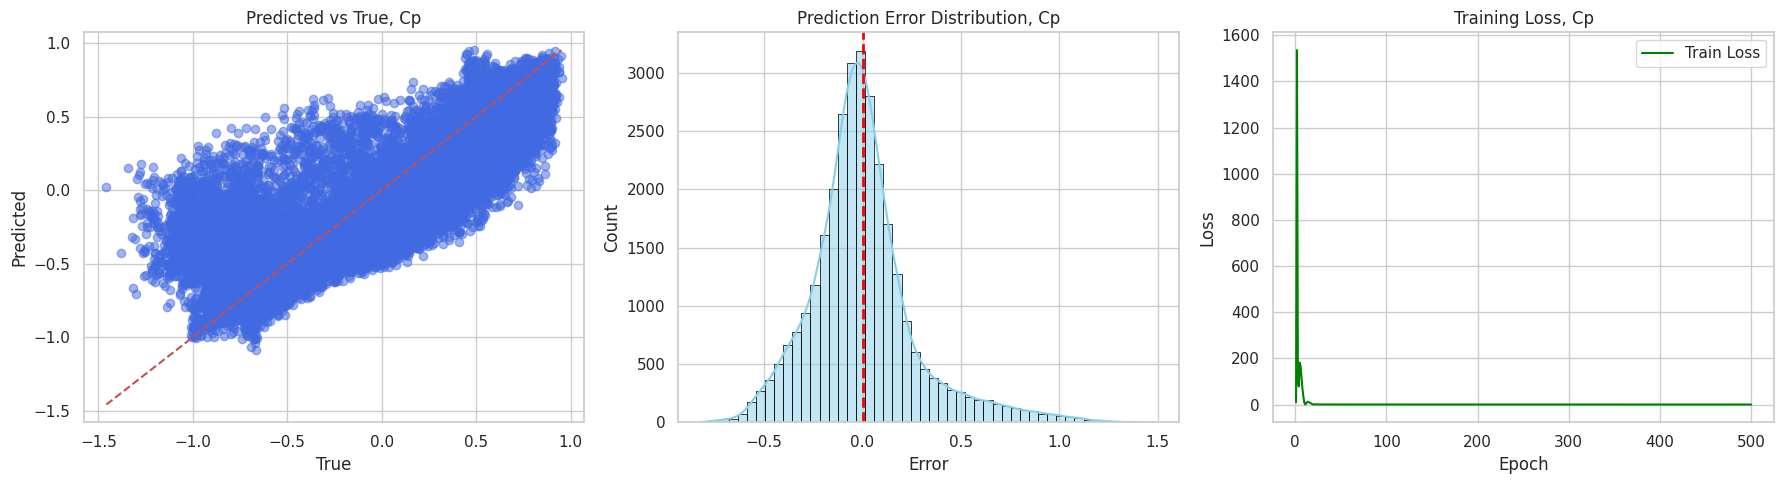

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 24/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   4%|▍         | 20/500 [00:00<00:05, 93.50it/s]

Epoch [10/500], Loss: 2.3076
Epoch [20/500], Loss: 0.4628
Epoch [30/500], Loss: 0.3623


Epochs:  11%|█         | 56/500 [00:00<00:03, 111.66it/s]

Epoch [40/500], Loss: 0.2382
Epoch [50/500], Loss: 0.2339
Epoch [60/500], Loss: 0.2314


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 115.69it/s]

Epoch [70/500], Loss: 0.2281
Epoch [80/500], Loss: 0.2225
Epoch [90/500], Loss: 0.2172


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 116.59it/s]

Epoch [100/500], Loss: 0.2116
Epoch [110/500], Loss: 0.2061
Epoch [120/500], Loss: 0.1990


Epochs:  30%|███       | 152/500 [00:01<00:02, 117.14it/s]

Epoch [130/500], Loss: 0.1913
Epoch [140/500], Loss: 0.1726
Epoch [150/500], Loss: 0.1534


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 117.18it/s]

Epoch [160/500], Loss: 0.1340
Epoch [170/500], Loss: 0.1212
Epoch [180/500], Loss: 0.1135


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 117.44it/s]

Epoch [190/500], Loss: 0.1087
Epoch [200/500], Loss: 0.1046
Epoch [210/500], Loss: 0.1009


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 117.62it/s]

Epoch [220/500], Loss: 0.0966
Epoch [230/500], Loss: 0.0939
Epoch [240/500], Loss: 0.0917


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 117.09it/s]

Epoch [250/500], Loss: 0.0901
Epoch [260/500], Loss: 0.0887
Epoch [270/500], Loss: 0.0876


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 116.81it/s]

Epoch [280/500], Loss: 0.0870
Epoch [290/500], Loss: 0.0853
Epoch [300/500], Loss: 0.0844


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 116.78it/s]

Epoch [310/500], Loss: 0.0840
Epoch [320/500], Loss: 0.0820
Epoch [330/500], Loss: 0.0804


Epochs:  71%|███████   | 356/500 [00:03<00:01, 116.73it/s]

Epoch [340/500], Loss: 0.0792
Epoch [350/500], Loss: 0.0782
Epoch [360/500], Loss: 0.0774


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 116.82it/s]

Epoch [370/500], Loss: 0.0763
Epoch [380/500], Loss: 0.0755
Epoch [390/500], Loss: 0.0747


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 116.66it/s]

Epoch [400/500], Loss: 0.0746
Epoch [410/500], Loss: 0.0734
Epoch [420/500], Loss: 0.0721


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 116.39it/s]

Epoch [430/500], Loss: 0.0714
Epoch [440/500], Loss: 0.0710
Epoch [450/500], Loss: 0.0704


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 116.50it/s]

Epoch [460/500], Loss: 0.0696
Epoch [470/500], Loss: 0.0693
Epoch [480/500], Loss: 0.0688


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.81it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0680
Epoch [500/500], Loss: 0.0672
📈 Evaluation metrics on test set:
MSE: 0.0678
MAE: 0.1847
R2: 0.7260


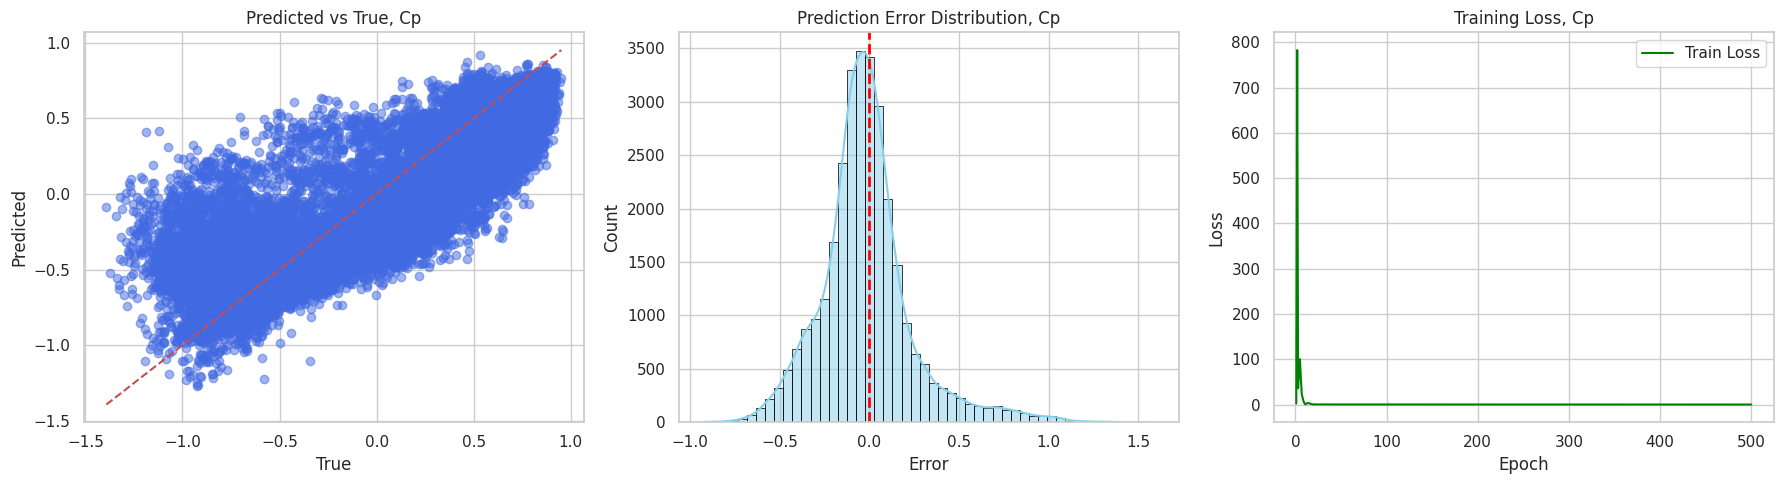

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 25/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 98.20it/s]

Epoch [10/500], Loss: 9.9401
Epoch [20/500], Loss: 1.0085
Epoch [30/500], Loss: 0.3359


Epochs:  11%|█▏        | 57/500 [00:00<00:03, 113.14it/s]

Epoch [40/500], Loss: 0.2496
Epoch [50/500], Loss: 0.2278
Epoch [60/500], Loss: 0.2160


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 115.76it/s]

Epoch [70/500], Loss: 0.2086
Epoch [80/500], Loss: 0.2036
Epoch [90/500], Loss: 0.1994


Epochs:  23%|██▎       | 117/500 [00:01<00:03, 116.35it/s]

Epoch [100/500], Loss: 0.1730
Epoch [110/500], Loss: 0.1506
Epoch [120/500], Loss: 0.1315


Epochs:  31%|███       | 153/500 [00:01<00:02, 116.77it/s]

Epoch [130/500], Loss: 0.1188
Epoch [140/500], Loss: 0.1090
Epoch [150/500], Loss: 0.1028


Epochs:  35%|███▌      | 177/500 [00:01<00:02, 117.04it/s]

Epoch [160/500], Loss: 0.1005
Epoch [170/500], Loss: 0.0972
Epoch [180/500], Loss: 0.0951


Epochs:  43%|████▎     | 213/500 [00:01<00:02, 116.81it/s]

Epoch [190/500], Loss: 0.0956
Epoch [200/500], Loss: 0.0926
Epoch [210/500], Loss: 0.0900


Epochs:  47%|████▋     | 237/500 [00:02<00:02, 117.20it/s]

Epoch [220/500], Loss: 0.0888
Epoch [230/500], Loss: 0.0877
Epoch [240/500], Loss: 0.0866


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 116.81it/s]

Epoch [250/500], Loss: 0.0858
Epoch [260/500], Loss: 0.0864
Epoch [270/500], Loss: 0.0842


Epochs:  59%|█████▉    | 297/500 [00:02<00:01, 116.61it/s]

Epoch [280/500], Loss: 0.0835
Epoch [290/500], Loss: 0.0826
Epoch [300/500], Loss: 0.0907


Epochs:  67%|██████▋   | 333/500 [00:02<00:01, 116.50it/s]

Epoch [310/500], Loss: 0.0816
Epoch [320/500], Loss: 0.0806
Epoch [330/500], Loss: 0.0801


Epochs:  71%|███████▏  | 357/500 [00:03<00:01, 116.47it/s]

Epoch [340/500], Loss: 0.0804
Epoch [350/500], Loss: 0.0794
Epoch [360/500], Loss: 0.0829


Epochs:  79%|███████▊  | 393/500 [00:03<00:00, 116.19it/s]

Epoch [370/500], Loss: 0.0919
Epoch [380/500], Loss: 0.1025
Epoch [390/500], Loss: 0.0875


Epochs:  83%|████████▎ | 417/500 [00:03<00:00, 116.13it/s]

Epoch [400/500], Loss: 0.0837
Epoch [410/500], Loss: 0.0828
Epoch [420/500], Loss: 0.0810


Epochs:  91%|█████████ | 453/500 [00:03<00:00, 116.71it/s]

Epoch [430/500], Loss: 0.0803
Epoch [440/500], Loss: 0.0796
Epoch [450/500], Loss: 0.0788


Epochs:  95%|█████████▌| 477/500 [00:04<00:00, 116.90it/s]

Epoch [460/500], Loss: 0.0781
Epoch [470/500], Loss: 0.0773
Epoch [480/500], Loss: 0.0765


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.74it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0759
Epoch [500/500], Loss: 0.0754
📈 Evaluation metrics on test set:
MSE: 0.0776
MAE: 0.1975
R2: 0.6853


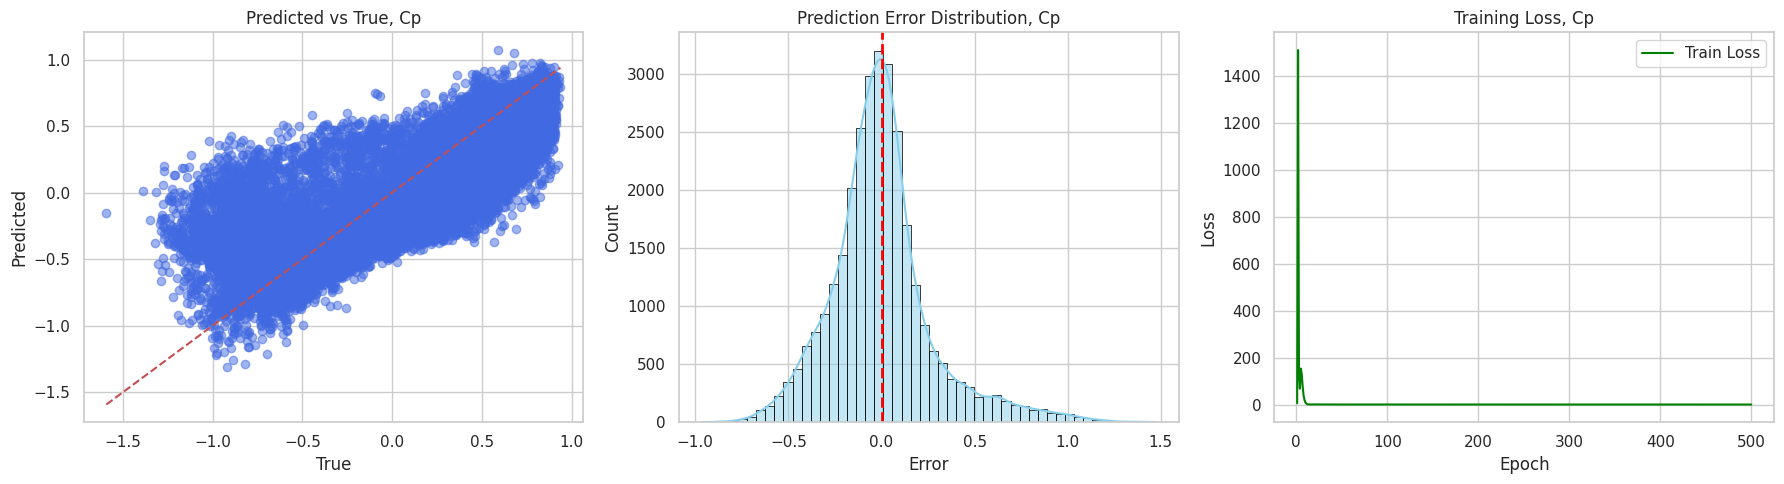

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 26/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 123.31it/s]

Epoch [10/500], Loss: 22.7096
Epoch [20/500], Loss: 1.8302


Epochs:   5%|▌         | 26/500 [00:00<00:03, 119.32it/s]

Epoch [30/500], Loss: 0.5860


Epochs:  10%|█         | 50/500 [00:00<00:03, 118.01it/s]

Epoch [40/500], Loss: 0.3634
Epoch [50/500], Loss: 0.2739


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 117.24it/s]

Epoch [60/500], Loss: 0.2521


Epochs:  15%|█▍        | 74/500 [00:00<00:03, 117.24it/s]

Epoch [70/500], Loss: 0.2401
Epoch [80/500], Loss: 0.2340


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.22it/s]

Epoch [90/500], Loss: 0.2167


Epochs:  22%|██▏       | 110/500 [00:00<00:03, 117.59it/s]

Epoch [100/500], Loss: 0.2071
Epoch [110/500], Loss: 0.1987


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.62it/s]

Epoch [120/500], Loss: 0.1917


Epochs:  27%|██▋       | 134/500 [00:01<00:03, 117.43it/s]

Epoch [130/500], Loss: 0.1885
Epoch [140/500], Loss: 0.1840


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.52it/s]

Epoch [150/500], Loss: 0.1796


Epochs:  34%|███▍      | 170/500 [00:01<00:02, 117.63it/s]

Epoch [160/500], Loss: 0.1737
Epoch [170/500], Loss: 0.1594


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.47it/s]

Epoch [180/500], Loss: 0.1332


Epochs:  39%|███▉      | 194/500 [00:01<00:02, 117.12it/s]

Epoch [190/500], Loss: 0.1206
Epoch [200/500], Loss: 0.1135


Epochs:  41%|████      | 206/500 [00:01<00:02, 116.87it/s]

Epoch [210/500], Loss: 0.1085


Epochs:  46%|████▌     | 230/500 [00:01<00:02, 116.81it/s]

Epoch [220/500], Loss: 0.1052
Epoch [230/500], Loss: 0.1022


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 116.80it/s]

Epoch [240/500], Loss: 0.0981


Epochs:  51%|█████     | 254/500 [00:02<00:02, 116.90it/s]

Epoch [250/500], Loss: 0.0940
Epoch [260/500], Loss: 0.0909


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 116.96it/s]

Epoch [270/500], Loss: 0.0880


Epochs:  58%|█████▊    | 290/500 [00:02<00:01, 116.55it/s]

Epoch [280/500], Loss: 0.0870
Epoch [290/500], Loss: 0.0846


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.38it/s]

Epoch [300/500], Loss: 0.0837


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 116.30it/s]

Epoch [310/500], Loss: 0.0822
Epoch [320/500], Loss: 0.0815


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.20it/s]

Epoch [330/500], Loss: 0.0800


Epochs:  70%|███████   | 350/500 [00:02<00:01, 116.29it/s]

Epoch [340/500], Loss: 0.0793
Epoch [350/500], Loss: 0.0786


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 116.19it/s]

Epoch [360/500], Loss: 0.0778


Epochs:  75%|███████▍  | 374/500 [00:03<00:01, 116.38it/s]

Epoch [370/500], Loss: 0.0772
Epoch [380/500], Loss: 0.0766


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 116.28it/s]

Epoch [390/500], Loss: 0.0768


Epochs:  82%|████████▏ | 410/500 [00:03<00:00, 116.14it/s]

Epoch [400/500], Loss: 0.0774
Epoch [410/500], Loss: 0.0793


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.16it/s]

Epoch [420/500], Loss: 0.0778


Epochs:  87%|████████▋ | 434/500 [00:03<00:00, 116.34it/s]

Epoch [430/500], Loss: 0.0753
Epoch [440/500], Loss: 0.0746


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 116.39it/s]

Epoch [450/500], Loss: 0.0741


Epochs:  94%|█████████▍| 470/500 [00:04<00:00, 116.40it/s]

Epoch [460/500], Loss: 0.0737
Epoch [470/500], Loss: 0.0733


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 116.23it/s]

Epoch [480/500], Loss: 0.0730


Epochs: 100%|██████████| 500/500 [00:04<00:00, 116.83it/s]

Epoch [490/500], Loss: 0.0735
Epoch [500/500], Loss: 0.0727
📈 Evaluation metrics on test set:
MSE: 0.0721
MAE: 0.1835
R2: 0.7105



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


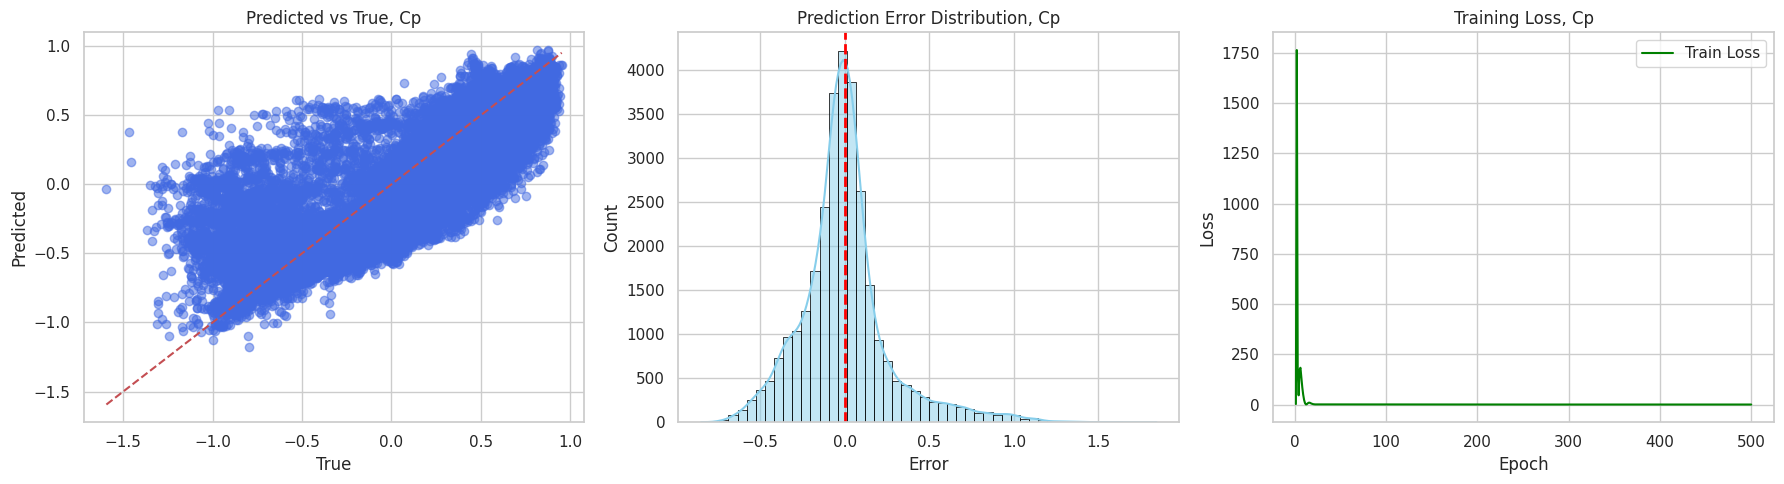

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 27/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:04, 121.52it/s]

Epoch [10/500], Loss: 0.3027
Epoch [20/500], Loss: 0.4208


Epochs:   5%|▌         | 26/500 [00:00<00:04, 115.43it/s]

Epoch [30/500], Loss: 0.3832


Epochs:  10%|█         | 50/500 [00:00<00:03, 114.92it/s]

Epoch [40/500], Loss: 0.2786
Epoch [50/500], Loss: 0.2221


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 114.71it/s]

Epoch [60/500], Loss: 0.2163


Epochs:  15%|█▍        | 74/500 [00:00<00:03, 114.50it/s]

Epoch [70/500], Loss: 0.2024
Epoch [80/500], Loss: 0.1811


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 115.08it/s]

Epoch [90/500], Loss: 0.1545


Epochs:  22%|██▏       | 110/500 [00:00<00:03, 114.97it/s]

Epoch [100/500], Loss: 0.1783
Epoch [110/500], Loss: 0.1626


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 115.07it/s]

Epoch [120/500], Loss: 0.1513


Epochs:  27%|██▋       | 134/500 [00:01<00:03, 114.93it/s]

Epoch [130/500], Loss: 0.1437
Epoch [140/500], Loss: 0.1386


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 114.62it/s]

Epoch [150/500], Loss: 0.1321


Epochs:  34%|███▍      | 170/500 [00:01<00:02, 114.77it/s]

Epoch [160/500], Loss: 0.1256
Epoch [170/500], Loss: 0.1196


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 114.82it/s]

Epoch [180/500], Loss: 0.1142


Epochs:  39%|███▉      | 194/500 [00:01<00:02, 114.75it/s]

Epoch [190/500], Loss: 0.1100
Epoch [200/500], Loss: 0.1071


Epochs:  41%|████      | 206/500 [00:01<00:02, 114.69it/s]

Epoch [210/500], Loss: 0.1050


Epochs:  46%|████▌     | 230/500 [00:02<00:02, 114.86it/s]

Epoch [220/500], Loss: 0.1035
Epoch [230/500], Loss: 0.1022


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 114.75it/s]

Epoch [240/500], Loss: 0.1011


Epochs:  51%|█████     | 254/500 [00:02<00:02, 114.49it/s]

Epoch [250/500], Loss: 0.0981
Epoch [260/500], Loss: 0.0935


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 114.74it/s]

Epoch [270/500], Loss: 0.0912


Epochs:  58%|█████▊    | 290/500 [00:02<00:01, 114.40it/s]

Epoch [280/500], Loss: 0.0892
Epoch [290/500], Loss: 0.0878


Epochs:  60%|██████    | 302/500 [00:02<00:01, 114.52it/s]

Epoch [300/500], Loss: 0.0868


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 114.45it/s]

Epoch [310/500], Loss: 0.0852
Epoch [320/500], Loss: 0.0842


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 114.40it/s]

Epoch [330/500], Loss: 0.0833


Epochs:  70%|███████   | 350/500 [00:03<00:01, 114.46it/s]

Epoch [340/500], Loss: 0.0825
Epoch [350/500], Loss: 0.0822


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 114.52it/s]

Epoch [360/500], Loss: 0.0816


Epochs:  75%|███████▍  | 374/500 [00:03<00:01, 114.41it/s]

Epoch [370/500], Loss: 0.0810
Epoch [380/500], Loss: 0.0807


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 114.43it/s]

Epoch [390/500], Loss: 0.0791


Epochs:  82%|████████▏ | 410/500 [00:03<00:00, 114.45it/s]

Epoch [400/500], Loss: 0.0785
Epoch [410/500], Loss: 0.0784


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 114.38it/s]

Epoch [420/500], Loss: 0.0773


Epochs:  87%|████████▋ | 434/500 [00:03<00:00, 114.19it/s]

Epoch [430/500], Loss: 0.0771
Epoch [440/500], Loss: 0.0763


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 114.36it/s]

Epoch [450/500], Loss: 0.0776


Epochs:  94%|█████████▍| 470/500 [00:04<00:00, 114.33it/s]

Epoch [460/500], Loss: 0.0755
Epoch [470/500], Loss: 0.0746


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 114.23it/s]

Epoch [480/500], Loss: 0.0736


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.59it/s]

Epoch [490/500], Loss: 0.0738
Epoch [500/500], Loss: 0.0726
📈 Evaluation metrics on test set:
MSE: 0.0749
MAE: 0.1930
R2: 0.7009



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


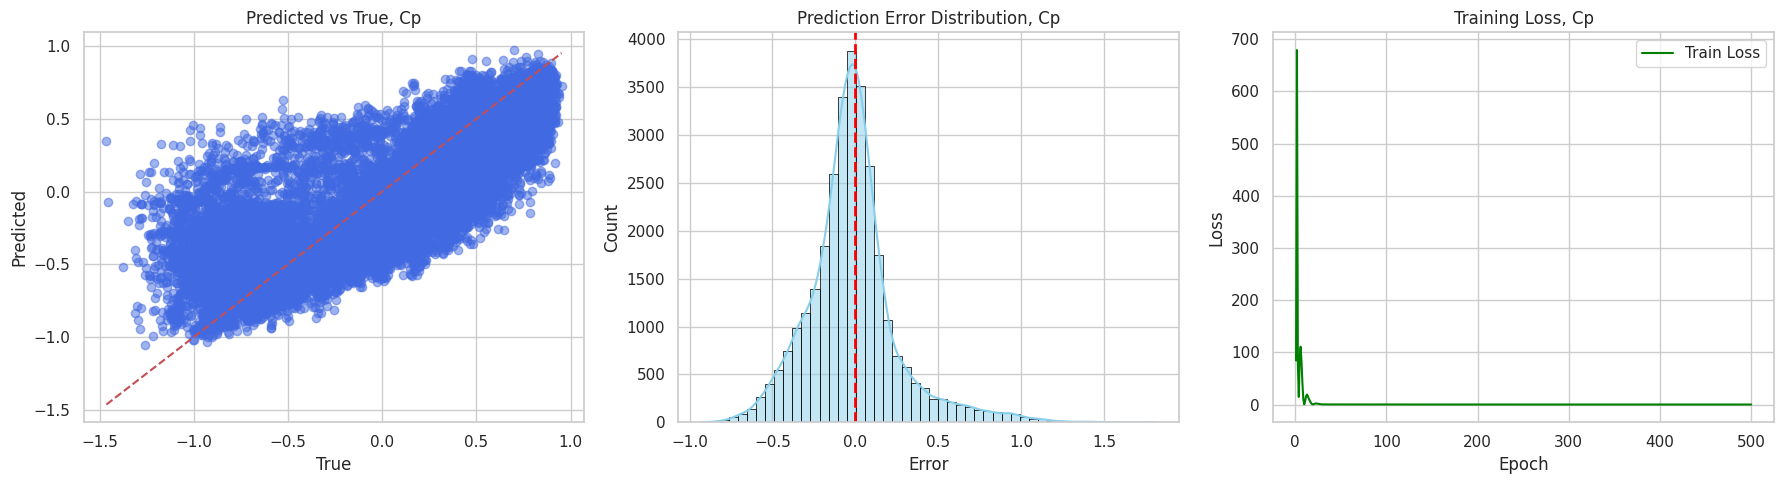

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 28/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   2%|▏         | 10/500 [00:00<00:05, 92.40it/s]

Epoch [10/500], Loss: 0.7494


Epochs:   4%|▍         | 20/500 [00:00<00:05, 92.13it/s]

Epoch [20/500], Loss: 2.2953
Epoch [30/500], Loss: 0.5608


Epochs:   6%|▋         | 32/500 [00:00<00:04, 101.23it/s]

Epoch [40/500], Loss: 0.3333


Epochs:  11%|█         | 56/500 [00:00<00:04, 109.29it/s]

Epoch [50/500], Loss: 0.2792
Epoch [60/500], Loss: 0.2287


Epochs:  14%|█▎        | 68/500 [00:00<00:03, 111.31it/s]

Epoch [70/500], Loss: 0.2190


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 113.39it/s]

Epoch [80/500], Loss: 0.2052
Epoch [90/500], Loss: 0.1959
Epoch [100/500], Loss: 0.1884


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 113.81it/s]

Epoch [110/500], Loss: 0.1827
Epoch [120/500], Loss: 0.1770


Epochs:  26%|██▌       | 128/500 [00:01<00:03, 114.24it/s]

Epoch [130/500], Loss: 0.1705


Epochs:  30%|███       | 152/500 [00:01<00:03, 114.69it/s]

Epoch [140/500], Loss: 0.1503
Epoch [150/500], Loss: 0.1341
Epoch [160/500], Loss: 0.1764


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 114.59it/s]

Epoch [170/500], Loss: 0.1446
Epoch [180/500], Loss: 0.1250


Epochs:  38%|███▊      | 188/500 [00:01<00:02, 114.72it/s]

Epoch [190/500], Loss: 0.1167


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 114.80it/s]

Epoch [200/500], Loss: 0.1121
Epoch [210/500], Loss: 0.1085
Epoch [220/500], Loss: 0.1052


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 114.69it/s]

Epoch [230/500], Loss: 0.1021
Epoch [240/500], Loss: 0.0993


Epochs:  50%|████▉     | 248/500 [00:02<00:02, 114.57it/s]

Epoch [250/500], Loss: 0.0966


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 114.76it/s]

Epoch [260/500], Loss: 0.0940
Epoch [270/500], Loss: 0.0916
Epoch [280/500], Loss: 0.0894


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 114.67it/s]

Epoch [290/500], Loss: 0.0880
Epoch [300/500], Loss: 0.0870


Epochs:  62%|██████▏   | 308/500 [00:02<00:01, 114.65it/s]

Epoch [310/500], Loss: 0.0852


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 114.57it/s]

Epoch [320/500], Loss: 0.0838
Epoch [330/500], Loss: 0.0824
Epoch [340/500], Loss: 0.0811


Epochs:  71%|███████   | 356/500 [00:03<00:01, 114.26it/s]

Epoch [350/500], Loss: 0.0798
Epoch [360/500], Loss: 0.0786


Epochs:  74%|███████▎  | 368/500 [00:03<00:01, 114.14it/s]

Epoch [370/500], Loss: 0.0775


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 114.18it/s]

Epoch [380/500], Loss: 0.0773
Epoch [390/500], Loss: 0.0758
Epoch [400/500], Loss: 0.0742


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 114.26it/s]

Epoch [410/500], Loss: 0.0731
Epoch [420/500], Loss: 0.0720


Epochs:  86%|████████▌ | 428/500 [00:03<00:00, 114.24it/s]

Epoch [430/500], Loss: 0.0709


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 114.14it/s]

Epoch [440/500], Loss: 0.0705
Epoch [450/500], Loss: 0.0691
Epoch [460/500], Loss: 0.0701


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 114.10it/s]

Epoch [470/500], Loss: 0.0684
Epoch [480/500], Loss: 0.0671


Epochs:  98%|█████████▊| 488/500 [00:04<00:00, 114.32it/s]

Epoch [490/500], Loss: 0.0659


Epochs: 100%|██████████| 500/500 [00:04<00:00, 113.37it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0647
📈 Evaluation metrics on test set:
MSE: 0.0630
MAE: 0.1735
R2: 0.7453


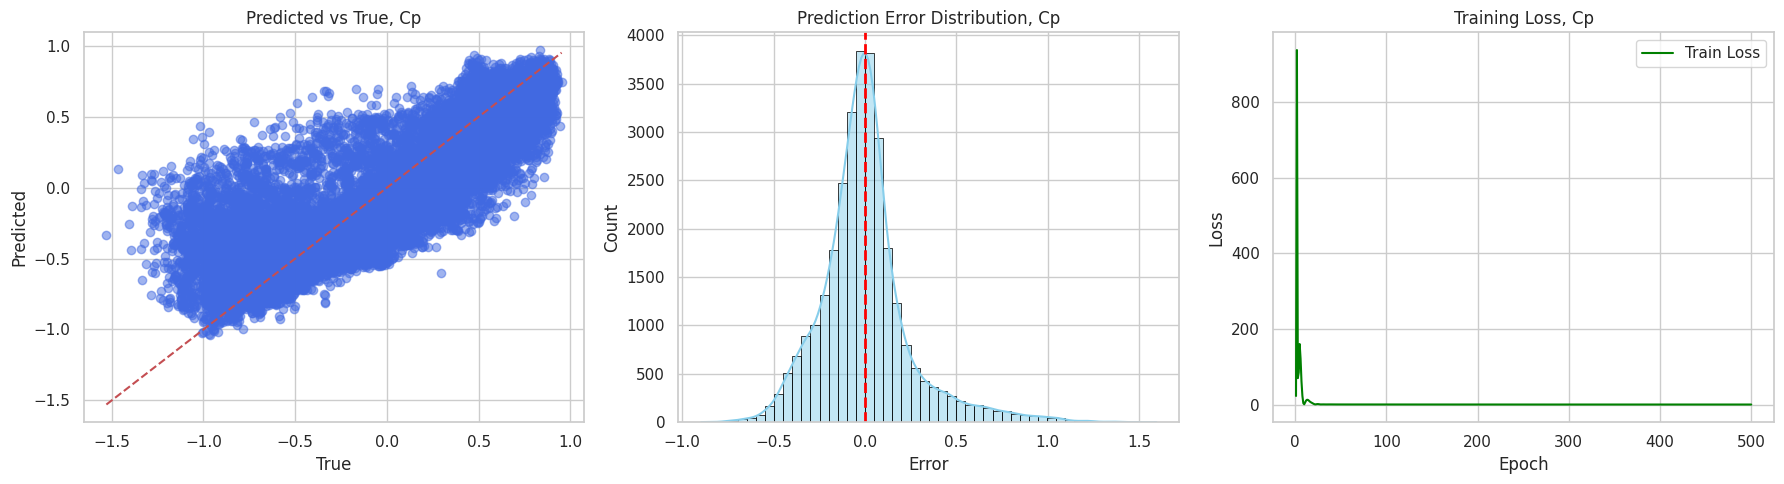

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 29/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 117.58it/s]

Epoch [10/500], Loss: 16.5213
Epoch [20/500], Loss: 4.3882
Epoch [30/500], Loss: 0.3007


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 116.31it/s]

Epoch [40/500], Loss: 0.2541
Epoch [50/500], Loss: 0.2341
Epoch [60/500], Loss: 0.2219


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 116.01it/s]

Epoch [70/500], Loss: 0.2108
Epoch [80/500], Loss: 0.2012
Epoch [90/500], Loss: 0.1953


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 115.30it/s]

Epoch [100/500], Loss: 0.1876
Epoch [110/500], Loss: 0.1763
Epoch [120/500], Loss: 0.1619


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 115.25it/s]

Epoch [130/500], Loss: 0.1451
Epoch [140/500], Loss: 0.1266
Epoch [150/500], Loss: 0.1146


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 115.49it/s]

Epoch [160/500], Loss: 0.1078
Epoch [170/500], Loss: 0.1037
Epoch [180/500], Loss: 0.1007


Epochs:  41%|████      | 206/500 [00:01<00:02, 115.18it/s]

Epoch [190/500], Loss: 0.0980
Epoch [200/500], Loss: 0.0952
Epoch [210/500], Loss: 0.0929


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 115.42it/s]

Epoch [220/500], Loss: 0.0907
Epoch [230/500], Loss: 0.0893
Epoch [240/500], Loss: 0.0872


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 115.09it/s]

Epoch [250/500], Loss: 0.0908
Epoch [260/500], Loss: 0.0834
Epoch [270/500], Loss: 0.0813


Epochs:  60%|██████    | 302/500 [00:02<00:01, 115.26it/s]

Epoch [280/500], Loss: 0.0799
Epoch [290/500], Loss: 0.0783
Epoch [300/500], Loss: 0.0768


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 115.31it/s]

Epoch [310/500], Loss: 0.0757
Epoch [320/500], Loss: 0.0746
Epoch [330/500], Loss: 0.0733


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 115.45it/s]

Epoch [340/500], Loss: 0.0730
Epoch [350/500], Loss: 0.0721
Epoch [360/500], Loss: 0.0706


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 115.60it/s]

Epoch [370/500], Loss: 0.0697
Epoch [380/500], Loss: 0.0687
Epoch [390/500], Loss: 0.0677


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 115.43it/s]

Epoch [400/500], Loss: 0.0670
Epoch [410/500], Loss: 0.0669
Epoch [420/500], Loss: 0.0660


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 115.74it/s]

Epoch [430/500], Loss: 0.0668
Epoch [440/500], Loss: 0.0646
Epoch [450/500], Loss: 0.0646


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 115.68it/s]

Epoch [460/500], Loss: 0.0640
Epoch [470/500], Loss: 0.0634
Epoch [480/500], Loss: 0.0626


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.54it/s]


Epoch [490/500], Loss: 0.0665
Epoch [500/500], Loss: 0.0622
📈 Evaluation metrics on test set:
MSE: 0.0641
MAE: 0.1823
R2: 0.7446


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 30/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 25/500 [00:00<00:04, 117.63it/s]

Epoch [10/500], Loss: 16.8117
Epoch [20/500], Loss: 0.6011
Epoch [30/500], Loss: 0.4174


Epochs:  12%|█▏        | 61/500 [00:00<00:03, 116.33it/s]

Epoch [40/500], Loss: 0.3091
Epoch [50/500], Loss: 0.2191
Epoch [60/500], Loss: 0.2250


Epochs:  17%|█▋        | 85/500 [00:00<00:03, 115.91it/s]

Epoch [70/500], Loss: 0.2129
Epoch [80/500], Loss: 0.2081
Epoch [90/500], Loss: 0.2034


Epochs:  24%|██▍       | 121/500 [00:01<00:03, 115.21it/s]

Epoch [100/500], Loss: 0.1983
Epoch [110/500], Loss: 0.1996
Epoch [120/500], Loss: 0.1939


Epochs:  29%|██▉       | 145/500 [00:01<00:03, 115.36it/s]

Epoch [130/500], Loss: 0.1893
Epoch [140/500], Loss: 0.1843
Epoch [150/500], Loss: 0.1909


Epochs:  36%|███▌      | 181/500 [00:01<00:02, 115.58it/s]

Epoch [160/500], Loss: 0.1715
Epoch [170/500], Loss: 0.1776
Epoch [180/500], Loss: 0.1563


Epochs:  41%|████      | 205/500 [00:01<00:02, 115.02it/s]

Epoch [190/500], Loss: 0.1277
Epoch [200/500], Loss: 0.1084
Epoch [210/500], Loss: 0.1100


Epochs:  48%|████▊     | 241/500 [00:02<00:02, 114.90it/s]

Epoch [220/500], Loss: 0.1004
Epoch [230/500], Loss: 0.0966
Epoch [240/500], Loss: 0.0926


Epochs:  53%|█████▎    | 265/500 [00:02<00:02, 115.03it/s]

Epoch [250/500], Loss: 0.0884
Epoch [260/500], Loss: 0.0851
Epoch [270/500], Loss: 0.0830


Epochs:  60%|██████    | 301/500 [00:02<00:01, 115.02it/s]

Epoch [280/500], Loss: 0.0828
Epoch [290/500], Loss: 0.0803
Epoch [300/500], Loss: 0.0792


Epochs:  65%|██████▌   | 325/500 [00:02<00:01, 115.22it/s]

Epoch [310/500], Loss: 0.0780
Epoch [320/500], Loss: 0.0771
Epoch [330/500], Loss: 0.0763


Epochs:  72%|███████▏  | 361/500 [00:03<00:01, 115.42it/s]

Epoch [340/500], Loss: 0.0822
Epoch [350/500], Loss: 0.0756
Epoch [360/500], Loss: 0.0751


Epochs:  77%|███████▋  | 385/500 [00:03<00:01, 114.99it/s]

Epoch [370/500], Loss: 0.0743
Epoch [380/500], Loss: 0.0738
Epoch [390/500], Loss: 0.0733


Epochs:  84%|████████▍ | 421/500 [00:03<00:00, 115.09it/s]

Epoch [400/500], Loss: 0.0730
Epoch [410/500], Loss: 0.0733
Epoch [420/500], Loss: 0.0727


Epochs:  89%|████████▉ | 445/500 [00:03<00:00, 115.26it/s]

Epoch [430/500], Loss: 0.0793
Epoch [440/500], Loss: 0.0753
Epoch [450/500], Loss: 0.0717


Epochs:  96%|█████████▌| 481/500 [00:04<00:00, 115.03it/s]

Epoch [460/500], Loss: 0.0715
Epoch [470/500], Loss: 0.0708
Epoch [480/500], Loss: 0.0706


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.32it/s]


Epoch [490/500], Loss: 0.0717
Epoch [500/500], Loss: 0.0727
📈 Evaluation metrics on test set:
MSE: 0.0733
MAE: 0.1918
R2: 0.7034


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 31/50
→ hidden_dim: 128, lr: 0.00750
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 121.94it/s]

Epoch [10/500], Loss: 18.7035
Epoch [20/500], Loss: 3.9753


Epochs:   5%|▌         | 26/500 [00:00<00:04, 116.59it/s]

Epoch [30/500], Loss: 0.6942


Epochs:  10%|█         | 50/500 [00:00<00:03, 114.89it/s]

Epoch [40/500], Loss: 0.2723
Epoch [50/500], Loss: 0.2343


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 114.93it/s]

Epoch [60/500], Loss: 0.2266


Epochs:  15%|█▍        | 74/500 [00:00<00:03, 114.43it/s]

Epoch [70/500], Loss: 0.2194
Epoch [80/500], Loss: 0.2161


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 114.73it/s]

Epoch [90/500], Loss: 0.2136


Epochs:  22%|██▏       | 110/500 [00:00<00:03, 114.51it/s]

Epoch [100/500], Loss: 0.2105
Epoch [110/500], Loss: 0.2054


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 114.65it/s]

Epoch [120/500], Loss: 0.1791


Epochs:  27%|██▋       | 134/500 [00:01<00:03, 114.62it/s]

Epoch [130/500], Loss: 0.1599
Epoch [140/500], Loss: 0.1391


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 114.55it/s]

Epoch [150/500], Loss: 0.1233


Epochs:  34%|███▍      | 170/500 [00:01<00:02, 114.35it/s]

Epoch [160/500], Loss: 0.1188
Epoch [170/500], Loss: 0.1137


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 114.53it/s]

Epoch [180/500], Loss: 0.1091


Epochs:  39%|███▉      | 194/500 [00:01<00:02, 114.41it/s]

Epoch [190/500], Loss: 0.1059
Epoch [200/500], Loss: 0.1035


Epochs:  41%|████      | 206/500 [00:01<00:02, 114.51it/s]

Epoch [210/500], Loss: 0.1016


Epochs:  46%|████▌     | 230/500 [00:02<00:02, 114.63it/s]

Epoch [220/500], Loss: 0.0999
Epoch [230/500], Loss: 0.0983


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 114.87it/s]

Epoch [240/500], Loss: 0.0969


Epochs:  51%|█████     | 254/500 [00:02<00:02, 114.68it/s]

Epoch [250/500], Loss: 0.0955
Epoch [260/500], Loss: 0.0943


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 114.61it/s]

Epoch [270/500], Loss: 0.0925


Epochs:  58%|█████▊    | 290/500 [00:02<00:01, 114.67it/s]

Epoch [280/500], Loss: 0.0911
Epoch [290/500], Loss: 0.0899


Epochs:  60%|██████    | 302/500 [00:02<00:01, 114.62it/s]

Epoch [300/500], Loss: 0.0886


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 114.56it/s]

Epoch [310/500], Loss: 0.0860
Epoch [320/500], Loss: 0.0834


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 114.76it/s]

Epoch [330/500], Loss: 0.0807


Epochs:  70%|███████   | 350/500 [00:03<00:01, 114.90it/s]

Epoch [340/500], Loss: 0.0781
Epoch [350/500], Loss: 0.0764


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 114.88it/s]

Epoch [360/500], Loss: 0.0753


Epochs:  75%|███████▍  | 374/500 [00:03<00:01, 114.57it/s]

Epoch [370/500], Loss: 0.0748
Epoch [380/500], Loss: 0.0741


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 114.91it/s]

Epoch [390/500], Loss: 0.0744


Epochs:  82%|████████▏ | 410/500 [00:03<00:00, 114.75it/s]

Epoch [400/500], Loss: 0.0731
Epoch [410/500], Loss: 0.0724


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 114.98it/s]

Epoch [420/500], Loss: 0.0721


Epochs:  87%|████████▋ | 434/500 [00:03<00:00, 114.98it/s]

Epoch [430/500], Loss: 0.0722
Epoch [440/500], Loss: 0.0717


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 115.05it/s]

Epoch [450/500], Loss: 0.0712


Epochs:  94%|█████████▍| 470/500 [00:04<00:00, 114.67it/s]

Epoch [460/500], Loss: 0.0708
Epoch [470/500], Loss: 0.0704


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 114.60it/s]

Epoch [480/500], Loss: 0.0719


Epochs: 100%|██████████| 500/500 [00:04<00:00, 114.81it/s]

Epoch [490/500], Loss: 0.0700
Epoch [500/500], Loss: 0.0695
📈 Evaluation metrics on test set:
MSE: 0.0696
MAE: 0.1812
R2: 0.7193



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


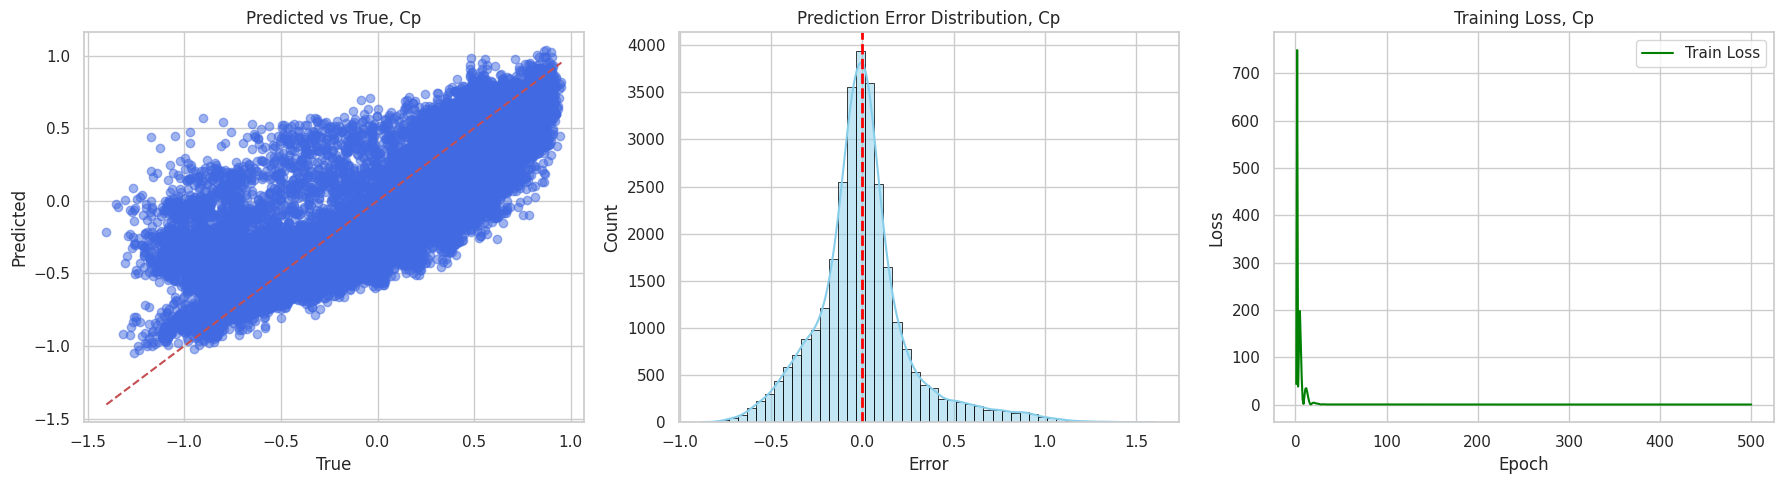

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 32/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 117.67it/s]

Epoch [10/500], Loss: 1.2544
Epoch [20/500], Loss: 11.8768
Epoch [30/500], Loss: 2.8127


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 116.09it/s]

Epoch [40/500], Loss: 1.3229
Epoch [50/500], Loss: 0.3892
Epoch [60/500], Loss: 0.4086


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 115.87it/s]

Epoch [70/500], Loss: 0.2451
Epoch [80/500], Loss: 0.2585
Epoch [90/500], Loss: 0.2363


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 115.79it/s]

Epoch [100/500], Loss: 0.2338
Epoch [110/500], Loss: 0.2283
Epoch [120/500], Loss: 0.2239


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 115.99it/s]

Epoch [130/500], Loss: 0.2164
Epoch [140/500], Loss: 0.2112
Epoch [150/500], Loss: 0.2066


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 116.29it/s]

Epoch [160/500], Loss: 0.1918
Epoch [170/500], Loss: 0.1637
Epoch [180/500], Loss: 0.1455


Epochs:  41%|████      | 206/500 [00:01<00:02, 116.21it/s]

Epoch [190/500], Loss: 0.1351
Epoch [200/500], Loss: 0.1269
Epoch [210/500], Loss: 0.1215


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 116.12it/s]

Epoch [220/500], Loss: 0.1174
Epoch [230/500], Loss: 0.1149
Epoch [240/500], Loss: 0.1131


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 115.98it/s]

Epoch [250/500], Loss: 0.1119
Epoch [260/500], Loss: 0.1108
Epoch [270/500], Loss: 0.1099


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.04it/s]

Epoch [280/500], Loss: 0.1092
Epoch [290/500], Loss: 0.1089
Epoch [300/500], Loss: 0.1080


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 115.87it/s]

Epoch [310/500], Loss: 0.1070
Epoch [320/500], Loss: 0.1056
Epoch [330/500], Loss: 0.1053


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 115.64it/s]

Epoch [340/500], Loss: 0.1034
Epoch [350/500], Loss: 0.1027
Epoch [360/500], Loss: 0.1020


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 115.85it/s]

Epoch [370/500], Loss: 0.1016
Epoch [380/500], Loss: 0.1010
Epoch [390/500], Loss: 0.1004


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 115.66it/s]

Epoch [400/500], Loss: 0.0996
Epoch [410/500], Loss: 0.0994
Epoch [420/500], Loss: 0.0986


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 115.43it/s]

Epoch [430/500], Loss: 0.0982
Epoch [440/500], Loss: 0.0977
Epoch [450/500], Loss: 0.0972


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 115.96it/s]

Epoch [460/500], Loss: 0.0971
Epoch [470/500], Loss: 0.0962
Epoch [480/500], Loss: 0.0958


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.98it/s]


Epoch [490/500], Loss: 0.0953
Epoch [500/500], Loss: 0.0947
📈 Evaluation metrics on test set:
MSE: 0.0942
MAE: 0.2212
R2: 0.6172


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


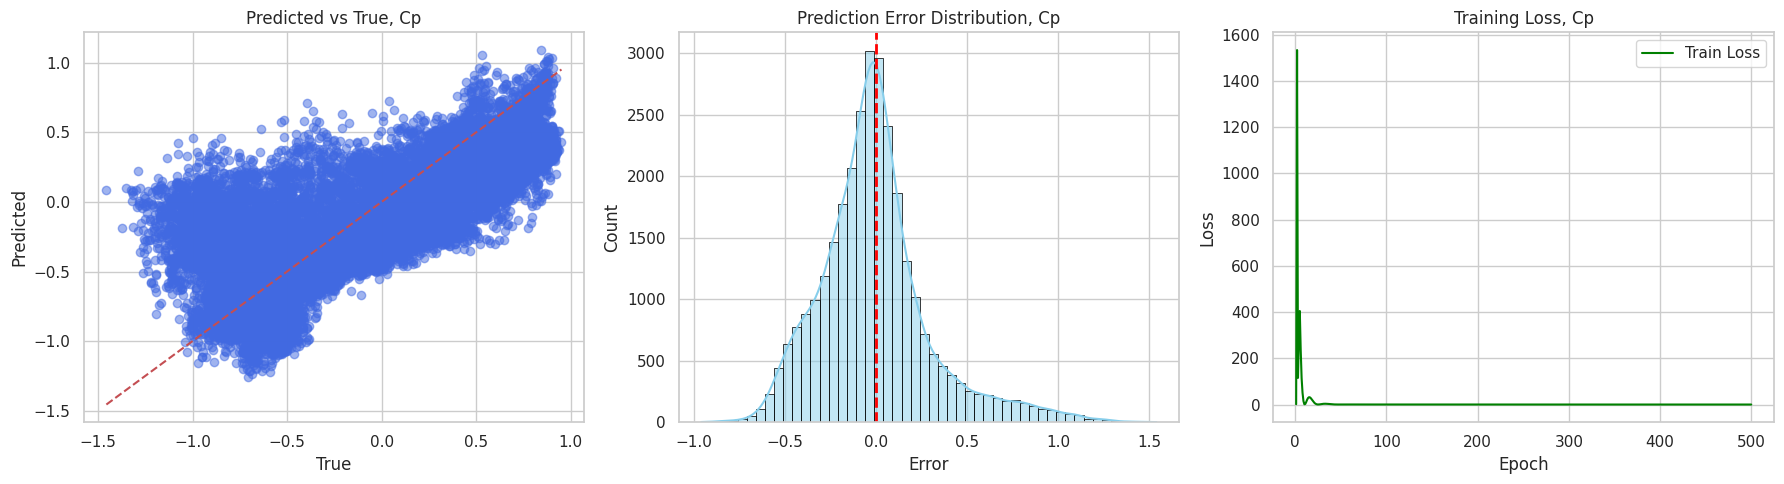

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 33/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 120.27it/s]

Epoch [10/500], Loss: 18.0780
Epoch [20/500], Loss: 0.2313
Epoch [30/500], Loss: 0.2351


Epochs:  13%|█▎        | 63/500 [00:00<00:03, 118.47it/s]

Epoch [40/500], Loss: 0.2361
Epoch [50/500], Loss: 0.2229
Epoch [60/500], Loss: 0.2214


Epochs:  17%|█▋        | 87/500 [00:00<00:03, 117.93it/s]

Epoch [70/500], Loss: 0.2176
Epoch [80/500], Loss: 0.2166
Epoch [90/500], Loss: 0.2140


Epochs:  25%|██▍       | 123/500 [00:01<00:03, 117.44it/s]

Epoch [100/500], Loss: 0.2100
Epoch [110/500], Loss: 0.2074
Epoch [120/500], Loss: 0.2044


Epochs:  29%|██▉       | 147/500 [00:01<00:03, 117.40it/s]

Epoch [130/500], Loss: 0.2025
Epoch [140/500], Loss: 0.1951
Epoch [150/500], Loss: 0.1805


Epochs:  37%|███▋      | 183/500 [00:01<00:02, 117.77it/s]

Epoch [160/500], Loss: 0.1583
Epoch [170/500], Loss: 0.1446
Epoch [180/500], Loss: 0.1341


Epochs:  41%|████▏     | 207/500 [00:01<00:02, 117.72it/s]

Epoch [190/500], Loss: 0.1236
Epoch [200/500], Loss: 0.1161
Epoch [210/500], Loss: 0.1094


Epochs:  49%|████▊     | 243/500 [00:02<00:02, 117.62it/s]

Epoch [220/500], Loss: 0.1038
Epoch [230/500], Loss: 0.0994
Epoch [240/500], Loss: 0.0957


Epochs:  53%|█████▎    | 267/500 [00:02<00:01, 117.56it/s]

Epoch [250/500], Loss: 0.0925
Epoch [260/500], Loss: 0.0899
Epoch [270/500], Loss: 0.0880


Epochs:  61%|██████    | 303/500 [00:02<00:01, 117.19it/s]

Epoch [280/500], Loss: 0.0862
Epoch [290/500], Loss: 0.0844
Epoch [300/500], Loss: 0.0831


Epochs:  65%|██████▌   | 327/500 [00:02<00:01, 117.19it/s]

Epoch [310/500], Loss: 0.0821
Epoch [320/500], Loss: 0.0820
Epoch [330/500], Loss: 0.0807


Epochs:  73%|███████▎  | 363/500 [00:03<00:01, 117.06it/s]

Epoch [340/500], Loss: 0.0798
Epoch [350/500], Loss: 0.0793
Epoch [360/500], Loss: 0.0788


Epochs:  77%|███████▋  | 387/500 [00:03<00:00, 116.76it/s]

Epoch [370/500], Loss: 0.0783
Epoch [380/500], Loss: 0.0801
Epoch [390/500], Loss: 0.0780


Epochs:  85%|████████▍ | 423/500 [00:03<00:00, 117.14it/s]

Epoch [400/500], Loss: 0.0774
Epoch [410/500], Loss: 0.0770
Epoch [420/500], Loss: 0.0768


Epochs:  89%|████████▉ | 447/500 [00:03<00:00, 116.93it/s]

Epoch [430/500], Loss: 0.0771
Epoch [440/500], Loss: 0.0763
Epoch [450/500], Loss: 0.0764


Epochs:  97%|█████████▋| 483/500 [00:04<00:00, 116.99it/s]

Epoch [460/500], Loss: 0.0758
Epoch [470/500], Loss: 0.0755
Epoch [480/500], Loss: 0.0751


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.47it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0752
Epoch [500/500], Loss: 0.0746
📈 Evaluation metrics on test set:
MSE: 0.0733
MAE: 0.1883
R2: 0.7058


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 34/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 117.69it/s]

Epoch [10/500], Loss: 1.1773
Epoch [20/500], Loss: 2.7057
Epoch [30/500], Loss: 0.3647


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 117.04it/s]

Epoch [40/500], Loss: 0.3232
Epoch [50/500], Loss: 0.2325
Epoch [60/500], Loss: 0.2144


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 116.97it/s]

Epoch [70/500], Loss: 0.2097
Epoch [80/500], Loss: 0.2050
Epoch [90/500], Loss: 0.1998


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.08it/s]

Epoch [100/500], Loss: 0.1951
Epoch [110/500], Loss: 0.1886
Epoch [120/500], Loss: 0.1677


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 116.79it/s]

Epoch [130/500], Loss: 0.1537
Epoch [140/500], Loss: 0.1408
Epoch [150/500], Loss: 0.1294


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 116.45it/s]

Epoch [160/500], Loss: 0.1193
Epoch [170/500], Loss: 0.1133
Epoch [180/500], Loss: 0.1096


Epochs:  41%|████      | 206/500 [00:01<00:02, 116.68it/s]

Epoch [190/500], Loss: 0.1080
Epoch [200/500], Loss: 0.1049
Epoch [210/500], Loss: 0.1033


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 116.56it/s]

Epoch [220/500], Loss: 0.1020
Epoch [230/500], Loss: 0.1001
Epoch [240/500], Loss: 0.1033


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 116.57it/s]

Epoch [250/500], Loss: 0.0964
Epoch [260/500], Loss: 0.0951
Epoch [270/500], Loss: 0.0918


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.24it/s]

Epoch [280/500], Loss: 0.0890
Epoch [290/500], Loss: 0.0866
Epoch [300/500], Loss: 0.0850


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.68it/s]

Epoch [310/500], Loss: 0.0848
Epoch [320/500], Loss: 0.0838
Epoch [330/500], Loss: 0.0819


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 116.55it/s]

Epoch [340/500], Loss: 0.0810
Epoch [350/500], Loss: 0.0851
Epoch [360/500], Loss: 0.0826


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 116.71it/s]

Epoch [370/500], Loss: 0.0790
Epoch [380/500], Loss: 0.0781
Epoch [390/500], Loss: 0.0775


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.54it/s]

Epoch [400/500], Loss: 0.0780
Epoch [410/500], Loss: 0.0807
Epoch [420/500], Loss: 0.0774


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 116.40it/s]

Epoch [430/500], Loss: 0.0756
Epoch [440/500], Loss: 0.0742
Epoch [450/500], Loss: 0.0738


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 116.62it/s]

Epoch [460/500], Loss: 0.0846
Epoch [470/500], Loss: 0.0743
Epoch [480/500], Loss: 0.0716


Epochs: 100%|██████████| 500/500 [00:04<00:00, 116.69it/s]


Epoch [490/500], Loss: 0.0709
Epoch [500/500], Loss: 0.0701
📈 Evaluation metrics on test set:
MSE: 0.0714
MAE: 0.1876
R2: 0.7116


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


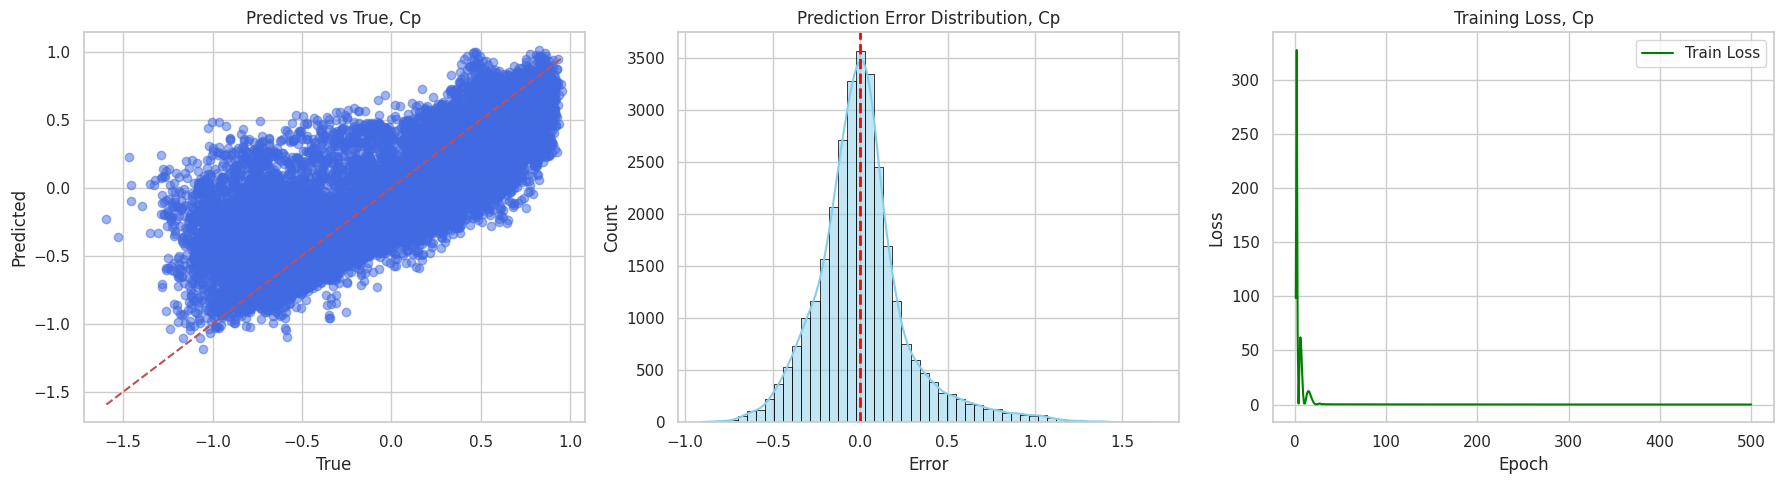

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 35/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 121.83it/s]

Epoch [10/500], Loss: 6.7648
Epoch [20/500], Loss: 1.2837


Epochs:   5%|▌         | 26/500 [00:00<00:03, 119.08it/s]

Epoch [30/500], Loss: 0.2764


Epochs:  10%|█         | 50/500 [00:00<00:03, 118.11it/s]

Epoch [40/500], Loss: 0.2614
Epoch [50/500], Loss: 0.2571


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 118.08it/s]

Epoch [60/500], Loss: 0.2535


Epochs:  15%|█▍        | 74/500 [00:00<00:03, 117.96it/s]

Epoch [70/500], Loss: 0.2489
Epoch [80/500], Loss: 0.2429


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.95it/s]

Epoch [90/500], Loss: 0.2337


Epochs:  22%|██▏       | 110/500 [00:00<00:03, 118.06it/s]

Epoch [100/500], Loss: 0.6468
Epoch [110/500], Loss: 0.2079


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.92it/s]

Epoch [120/500], Loss: 0.1980


Epochs:  27%|██▋       | 134/500 [00:01<00:03, 117.76it/s]

Epoch [130/500], Loss: 0.1753
Epoch [140/500], Loss: 0.1476


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.82it/s]

Epoch [150/500], Loss: 0.1275


Epochs:  34%|███▍      | 170/500 [00:01<00:02, 117.75it/s]

Epoch [160/500], Loss: 0.1173
Epoch [170/500], Loss: 0.1112


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.59it/s]

Epoch [180/500], Loss: 0.1054


Epochs:  39%|███▉      | 194/500 [00:01<00:02, 117.76it/s]

Epoch [190/500], Loss: 0.1017
Epoch [200/500], Loss: 0.0984


Epochs:  41%|████      | 206/500 [00:01<00:02, 117.57it/s]

Epoch [210/500], Loss: 0.0960


Epochs:  46%|████▌     | 230/500 [00:01<00:02, 117.92it/s]

Epoch [220/500], Loss: 0.0940
Epoch [230/500], Loss: 0.0923


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 117.83it/s]

Epoch [240/500], Loss: 0.0908


Epochs:  51%|█████     | 254/500 [00:02<00:02, 117.82it/s]

Epoch [250/500], Loss: 0.0895
Epoch [260/500], Loss: 0.0881


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 117.89it/s]

Epoch [270/500], Loss: 0.0867


Epochs:  58%|█████▊    | 290/500 [00:02<00:01, 117.84it/s]

Epoch [280/500], Loss: 0.0856
Epoch [290/500], Loss: 0.0850


Epochs:  60%|██████    | 302/500 [00:02<00:01, 117.79it/s]

Epoch [300/500], Loss: 0.0838


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 117.54it/s]

Epoch [310/500], Loss: 0.0830
Epoch [320/500], Loss: 0.0823


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 117.53it/s]

Epoch [330/500], Loss: 0.0819


Epochs:  70%|███████   | 350/500 [00:02<00:01, 117.49it/s]

Epoch [340/500], Loss: 0.0820
Epoch [350/500], Loss: 0.0813


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 117.56it/s]

Epoch [360/500], Loss: 0.0803


Epochs:  75%|███████▍  | 374/500 [00:03<00:01, 117.56it/s]

Epoch [370/500], Loss: 0.0799
Epoch [380/500], Loss: 0.0795


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 117.67it/s]

Epoch [390/500], Loss: 0.0791


Epochs:  82%|████████▏ | 410/500 [00:03<00:00, 117.48it/s]

Epoch [400/500], Loss: 0.0787
Epoch [410/500], Loss: 0.0783


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 117.49it/s]

Epoch [420/500], Loss: 0.0783


Epochs:  87%|████████▋ | 434/500 [00:03<00:00, 117.55it/s]

Epoch [430/500], Loss: 0.0795
Epoch [440/500], Loss: 0.0777


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 117.57it/s]

Epoch [450/500], Loss: 0.0770


Epochs:  94%|█████████▍| 470/500 [00:03<00:00, 117.65it/s]

Epoch [460/500], Loss: 0.0766
Epoch [470/500], Loss: 0.0762


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 117.65it/s]

Epoch [480/500], Loss: 0.0764


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.77it/s]

Epoch [490/500], Loss: 0.0758
Epoch [500/500], Loss: 0.0768
📈 Evaluation metrics on test set:
MSE: 0.0788
MAE: 0.1942
R2: 0.6847



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 36/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 121.91it/s]

Epoch [10/500], Loss: 38.4053
Epoch [20/500], Loss: 0.5228


Epochs:   5%|▌         | 26/500 [00:00<00:04, 118.48it/s]

Epoch [30/500], Loss: 0.2864


Epochs:  10%|█         | 50/500 [00:00<00:03, 118.40it/s]

Epoch [40/500], Loss: 0.2886
Epoch [50/500], Loss: 0.2755


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 118.16it/s]

Epoch [60/500], Loss: 0.2695


Epochs:  15%|█▍        | 74/500 [00:00<00:03, 117.85it/s]

Epoch [70/500], Loss: 0.2609
Epoch [80/500], Loss: 0.2538


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.92it/s]

Epoch [90/500], Loss: 0.2491


Epochs:  22%|██▏       | 110/500 [00:00<00:03, 118.18it/s]

Epoch [100/500], Loss: 0.2411
Epoch [110/500], Loss: 0.2311


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 118.34it/s]

Epoch [120/500], Loss: 0.2229


Epochs:  27%|██▋       | 134/500 [00:01<00:03, 118.29it/s]

Epoch [130/500], Loss: 0.2173
Epoch [140/500], Loss: 0.2114


Epochs:  29%|██▉       | 146/500 [00:01<00:02, 118.28it/s]

Epoch [150/500], Loss: 0.2215


Epochs:  34%|███▍      | 170/500 [00:01<00:02, 118.26it/s]

Epoch [160/500], Loss: 0.2237
Epoch [170/500], Loss: 0.2216


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 118.41it/s]

Epoch [180/500], Loss: 0.2177


Epochs:  39%|███▉      | 194/500 [00:01<00:02, 118.49it/s]

Epoch [190/500], Loss: 0.2140
Epoch [200/500], Loss: 0.2096


Epochs:  41%|████      | 206/500 [00:01<00:02, 118.61it/s]

Epoch [210/500], Loss: 0.2052


Epochs:  46%|████▌     | 230/500 [00:01<00:02, 117.90it/s]

Epoch [220/500], Loss: 0.2010
Epoch [230/500], Loss: 0.1941


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 117.49it/s]

Epoch [240/500], Loss: 0.1777


Epochs:  51%|█████     | 254/500 [00:02<00:02, 117.76it/s]

Epoch [250/500], Loss: 0.1607
Epoch [260/500], Loss: 0.1466


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 117.56it/s]

Epoch [270/500], Loss: 0.1348


Epochs:  58%|█████▊    | 290/500 [00:02<00:01, 117.37it/s]

Epoch [280/500], Loss: 0.1252
Epoch [290/500], Loss: 0.1184


Epochs:  60%|██████    | 302/500 [00:02<00:01, 117.40it/s]

Epoch [300/500], Loss: 0.1122


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 117.28it/s]

Epoch [310/500], Loss: 0.1064
Epoch [320/500], Loss: 0.1014


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 117.21it/s]

Epoch [330/500], Loss: 0.0969


Epochs:  70%|███████   | 350/500 [00:02<00:01, 116.86it/s]

Epoch [340/500], Loss: 0.0941
Epoch [350/500], Loss: 0.0920


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 116.70it/s]

Epoch [360/500], Loss: 0.0905


Epochs:  75%|███████▍  | 374/500 [00:03<00:01, 116.74it/s]

Epoch [370/500], Loss: 0.0894
Epoch [380/500], Loss: 0.0883


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 117.18it/s]

Epoch [390/500], Loss: 0.0874


Epochs:  82%|████████▏ | 410/500 [00:03<00:00, 117.24it/s]

Epoch [400/500], Loss: 0.0866
Epoch [410/500], Loss: 0.0861


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 117.12it/s]

Epoch [420/500], Loss: 0.0852


Epochs:  87%|████████▋ | 434/500 [00:03<00:00, 117.19it/s]

Epoch [430/500], Loss: 0.0841
Epoch [440/500], Loss: 0.0833


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 117.39it/s]

Epoch [450/500], Loss: 0.0826


Epochs:  94%|█████████▍| 470/500 [00:03<00:00, 117.47it/s]

Epoch [460/500], Loss: 0.0820
Epoch [470/500], Loss: 0.0814


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 117.29it/s]

Epoch [480/500], Loss: 0.0809


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.64it/s]

Epoch [490/500], Loss: 0.0805
Epoch [500/500], Loss: 0.0801
📈 Evaluation metrics on test set:
MSE: 0.0794
MAE: 0.1992
R2: 0.6770



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 37/50
→ hidden_dim: 128, lr: 0.00700
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep


Epochs:   3%|▎         | 13/500 [00:00<00:03, 123.94it/s]

Epoch [10/500], Loss: 0.2625
Epoch [20/500], Loss: 0.4058


Epochs:   5%|▌         | 26/500 [00:00<00:03, 119.43it/s]

Epoch [30/500], Loss: 0.2358


Epochs:  10%|█         | 50/500 [00:00<00:03, 118.28it/s]

Epoch [40/500], Loss: 0.2376
Epoch [50/500], Loss: 0.2156


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 117.99it/s]

Epoch [60/500], Loss: 0.2102


Epochs:  15%|█▍        | 74/500 [00:00<00:03, 117.96it/s]

Epoch [70/500], Loss: 0.2045
Epoch [80/500], Loss: 0.1985


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.77it/s]

Epoch [90/500], Loss: 0.1888


Epochs:  22%|██▏       | 110/500 [00:00<00:03, 117.41it/s]

Epoch [100/500], Loss: 0.1758
Epoch [110/500], Loss: 0.1602


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.32it/s]

Epoch [120/500], Loss: 0.1452


Epochs:  27%|██▋       | 134/500 [00:01<00:03, 117.40it/s]

Epoch [130/500], Loss: 0.1455
Epoch [140/500], Loss: 0.1396


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.31it/s]

Epoch [150/500], Loss: 0.1324


Epochs:  34%|███▍      | 170/500 [00:01<00:02, 117.12it/s]

Epoch [160/500], Loss: 0.1256
Epoch [170/500], Loss: 0.1229


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.25it/s]

Epoch [180/500], Loss: 0.1195


Epochs:  39%|███▉      | 194/500 [00:01<00:02, 117.18it/s]

Epoch [190/500], Loss: 0.1165
Epoch [200/500], Loss: 0.1138


Epochs:  41%|████      | 206/500 [00:01<00:02, 117.32it/s]

Epoch [210/500], Loss: 0.1114


Epochs:  46%|████▌     | 230/500 [00:01<00:02, 117.24it/s]

Epoch [220/500], Loss: 0.1092
Epoch [230/500], Loss: 0.1072


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 117.22it/s]

Epoch [240/500], Loss: 0.1054


Epochs:  51%|█████     | 254/500 [00:02<00:02, 117.14it/s]

Epoch [250/500], Loss: 0.1036
Epoch [260/500], Loss: 0.1018


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 117.10it/s]

Epoch [270/500], Loss: 0.1005


Epochs:  58%|█████▊    | 290/500 [00:02<00:01, 117.19it/s]

Epoch [280/500], Loss: 0.0993
Epoch [290/500], Loss: 0.0976


Epochs:  60%|██████    | 302/500 [00:02<00:01, 117.12it/s]

Epoch [300/500], Loss: 0.0985


Epochs:  63%|██████▎   | 314/500 [00:02<00:01, 116.96it/s]

Epoch [310/500], Loss: 0.0966
Epoch [320/500], Loss: 0.0953


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.72it/s]

Epoch [330/500], Loss: 0.0943


Epochs:  70%|███████   | 350/500 [00:02<00:01, 116.73it/s]

Epoch [340/500], Loss: 0.0931
Epoch [350/500], Loss: 0.0980


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 116.65it/s]

Epoch [360/500], Loss: 0.0934


Epochs:  75%|███████▍  | 374/500 [00:03<00:01, 116.65it/s]

Epoch [370/500], Loss: 0.0916
Epoch [380/500], Loss: 0.0879


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 117.18it/s]

Epoch [390/500], Loss: 0.0841


Epochs:  82%|████████▏ | 410/500 [00:03<00:00, 117.15it/s]

Epoch [400/500], Loss: 0.0825
Epoch [410/500], Loss: 0.0808


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 117.17it/s]

Epoch [420/500], Loss: 0.0804


Epochs:  87%|████████▋ | 434/500 [00:03<00:00, 117.48it/s]

Epoch [430/500], Loss: 0.0793
Epoch [440/500], Loss: 0.0782


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 117.37it/s]

Epoch [450/500], Loss: 0.0771


Epochs:  94%|█████████▍| 470/500 [00:04<00:00, 117.15it/s]

Epoch [460/500], Loss: 0.0762
Epoch [470/500], Loss: 0.0818


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 117.00it/s]

Epoch [480/500], Loss: 0.0843


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.27it/s]

Epoch [490/500], Loss: 0.0771
Epoch [500/500], Loss: 0.0748
📈 Evaluation metrics on test set:
MSE: 0.0769
MAE: 0.1977
R2: 0.6892



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_7e-03lr_64bs_500ep/loss_plot.png

🔁 Run 38/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 98.72it/s]

Epoch [10/500], Loss: 36.9337
Epoch [20/500], Loss: 0.2346
Epoch [30/500], Loss: 3.1157


Epochs:  11%|█         | 56/500 [00:00<00:04, 110.94it/s]

Epoch [40/500], Loss: 0.6792
Epoch [50/500], Loss: 0.2376
Epoch [60/500], Loss: 0.2959


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 115.44it/s]

Epoch [70/500], Loss: 0.2619
Epoch [80/500], Loss: 0.2275
Epoch [90/500], Loss: 0.2190


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 116.48it/s]

Epoch [100/500], Loss: 0.2128
Epoch [110/500], Loss: 0.2064
Epoch [120/500], Loss: 0.2034


Epochs:  30%|███       | 152/500 [00:01<00:02, 116.63it/s]

Epoch [130/500], Loss: 0.2000
Epoch [140/500], Loss: 0.1968
Epoch [150/500], Loss: 0.1943


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 116.83it/s]

Epoch [160/500], Loss: 0.1921
Epoch [170/500], Loss: 0.1856
Epoch [180/500], Loss: 0.1647


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 117.00it/s]

Epoch [190/500], Loss: 0.1511
Epoch [200/500], Loss: 0.1431
Epoch [210/500], Loss: 0.1376


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 117.06it/s]

Epoch [220/500], Loss: 0.1333
Epoch [230/500], Loss: 0.1294
Epoch [240/500], Loss: 0.1278


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 117.42it/s]

Epoch [250/500], Loss: 0.1230
Epoch [260/500], Loss: 0.1187
Epoch [270/500], Loss: 0.1151


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 117.15it/s]

Epoch [280/500], Loss: 0.1121
Epoch [290/500], Loss: 0.1092
Epoch [300/500], Loss: 0.1067


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 116.75it/s]

Epoch [310/500], Loss: 0.1044
Epoch [320/500], Loss: 0.1029
Epoch [330/500], Loss: 0.0997


Epochs:  71%|███████   | 356/500 [00:03<00:01, 116.84it/s]

Epoch [340/500], Loss: 0.0996
Epoch [350/500], Loss: 0.0965
Epoch [360/500], Loss: 0.0949


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 116.55it/s]

Epoch [370/500], Loss: 0.0933
Epoch [380/500], Loss: 0.0920
Epoch [390/500], Loss: 0.0947


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 116.54it/s]

Epoch [400/500], Loss: 0.0921
Epoch [410/500], Loss: 0.0906
Epoch [420/500], Loss: 0.0888


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 116.60it/s]

Epoch [430/500], Loss: 0.0873
Epoch [440/500], Loss: 0.0866
Epoch [450/500], Loss: 0.0891


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 116.39it/s]

Epoch [460/500], Loss: 0.0879
Epoch [470/500], Loss: 0.0829
Epoch [480/500], Loss: 0.0815


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.65it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0798
Epoch [500/500], Loss: 0.0786
📈 Evaluation metrics on test set:
MSE: 0.0778
MAE: 0.1976
R2: 0.6875


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 39/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 118.68it/s]

Epoch [10/500], Loss: 15.3507
Epoch [20/500], Loss: 3.4080
Epoch [30/500], Loss: 0.7038


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 117.63it/s]

Epoch [40/500], Loss: 0.6816
Epoch [50/500], Loss: 0.3268
Epoch [60/500], Loss: 0.2732


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.57it/s]

Epoch [70/500], Loss: 0.2756
Epoch [80/500], Loss: 0.2665
Epoch [90/500], Loss: 0.2647


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.28it/s]

Epoch [100/500], Loss: 0.2619
Epoch [110/500], Loss: 0.2602
Epoch [120/500], Loss: 0.2583


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.36it/s]

Epoch [130/500], Loss: 0.2560
Epoch [140/500], Loss: 0.2524
Epoch [150/500], Loss: 0.2481


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 118.08it/s]

Epoch [160/500], Loss: 0.2435
Epoch [170/500], Loss: 0.2385
Epoch [180/500], Loss: 0.2289


Epochs:  41%|████      | 206/500 [00:01<00:02, 117.55it/s]

Epoch [190/500], Loss: 0.2354
Epoch [200/500], Loss: 0.1853
Epoch [210/500], Loss: 0.1539


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 117.41it/s]

Epoch [220/500], Loss: 0.1460
Epoch [230/500], Loss: 0.1374
Epoch [240/500], Loss: 0.1314


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 117.24it/s]

Epoch [250/500], Loss: 0.1268
Epoch [260/500], Loss: 0.1236
Epoch [270/500], Loss: 0.1211


Epochs:  60%|██████    | 302/500 [00:02<00:01, 117.35it/s]

Epoch [280/500], Loss: 0.1191
Epoch [290/500], Loss: 0.1174
Epoch [300/500], Loss: 0.1156


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.85it/s]

Epoch [310/500], Loss: 0.1140
Epoch [320/500], Loss: 0.1126
Epoch [330/500], Loss: 0.1114


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 116.69it/s]

Epoch [340/500], Loss: 0.1101
Epoch [350/500], Loss: 0.1087
Epoch [360/500], Loss: 0.1080


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 116.86it/s]

Epoch [370/500], Loss: 0.1058
Epoch [380/500], Loss: 0.1046
Epoch [390/500], Loss: 0.1025


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.49it/s]

Epoch [400/500], Loss: 0.1010
Epoch [410/500], Loss: 0.0989
Epoch [420/500], Loss: 0.0968


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 116.63it/s]

Epoch [430/500], Loss: 0.0951
Epoch [440/500], Loss: 0.0936
Epoch [450/500], Loss: 0.0925


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 116.41it/s]

Epoch [460/500], Loss: 0.0913
Epoch [470/500], Loss: 0.0903
Epoch [480/500], Loss: 0.0893


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.17it/s]


Epoch [490/500], Loss: 0.0884
Epoch [500/500], Loss: 0.0875
📈 Evaluation metrics on test set:
MSE: 0.0870
MAE: 0.2125
R2: 0.6484


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


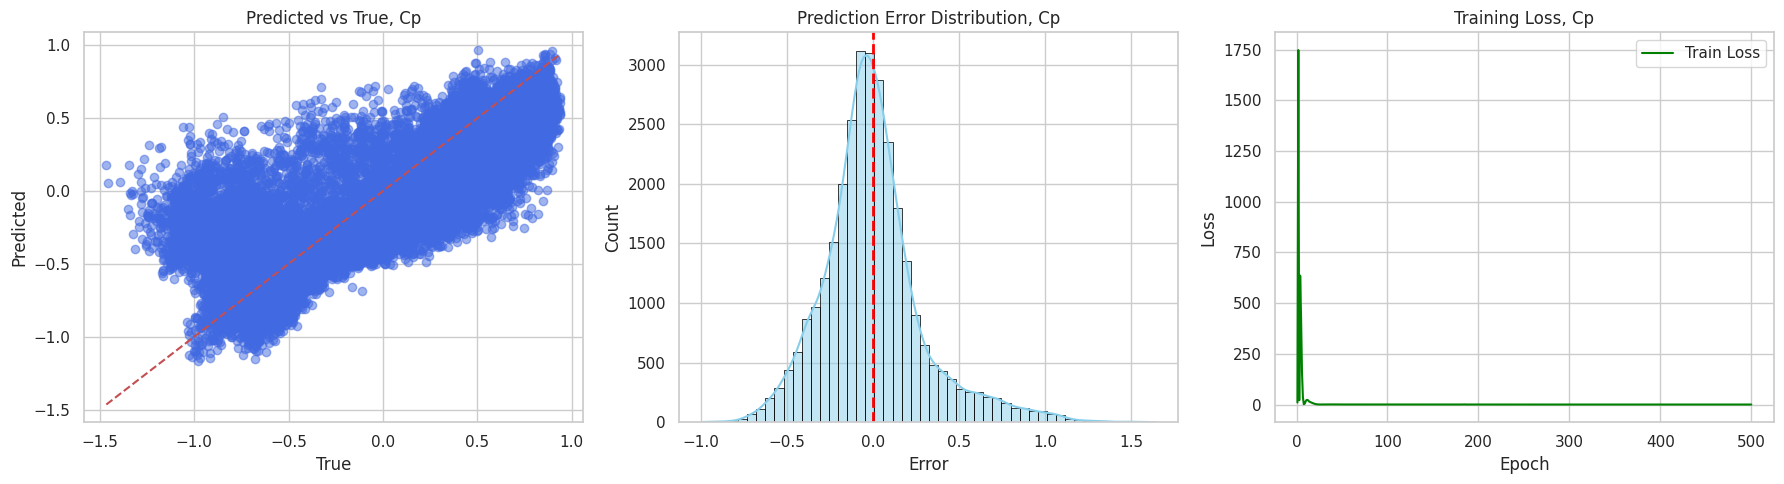

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 40/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 118.11it/s]

Epoch [10/500], Loss: 8.0503
Epoch [20/500], Loss: 1.3990
Epoch [30/500], Loss: 0.4072


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 117.45it/s]

Epoch [40/500], Loss: 0.3025
Epoch [50/500], Loss: 0.2679
Epoch [60/500], Loss: 0.2569


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.70it/s]

Epoch [70/500], Loss: 0.2526
Epoch [80/500], Loss: 0.2495
Epoch [90/500], Loss: 0.2454


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.28it/s]

Epoch [100/500], Loss: 0.2399
Epoch [110/500], Loss: 0.2331
Epoch [120/500], Loss: 0.2349


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.56it/s]

Epoch [130/500], Loss: 0.2324
Epoch [140/500], Loss: 0.2262
Epoch [150/500], Loss: 0.2174


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.61it/s]

Epoch [160/500], Loss: 0.2056
Epoch [170/500], Loss: 0.1944
Epoch [180/500], Loss: 0.1802


Epochs:  41%|████      | 206/500 [00:01<00:02, 117.59it/s]

Epoch [190/500], Loss: 0.1576
Epoch [200/500], Loss: 0.1384
Epoch [210/500], Loss: 0.1271


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 116.93it/s]

Epoch [220/500], Loss: 0.1218
Epoch [230/500], Loss: 0.1182
Epoch [240/500], Loss: 0.1415


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 116.75it/s]

Epoch [250/500], Loss: 0.1222
Epoch [260/500], Loss: 0.1141
Epoch [270/500], Loss: 0.1130


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.90it/s]

Epoch [280/500], Loss: 0.1109
Epoch [290/500], Loss: 0.1094
Epoch [300/500], Loss: 0.1079


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.86it/s]

Epoch [310/500], Loss: 0.1065
Epoch [320/500], Loss: 0.1051
Epoch [330/500], Loss: 0.1036


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 117.07it/s]

Epoch [340/500], Loss: 0.1023
Epoch [350/500], Loss: 0.1010
Epoch [360/500], Loss: 0.0998


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 116.89it/s]

Epoch [370/500], Loss: 0.0987
Epoch [380/500], Loss: 0.0978
Epoch [390/500], Loss: 0.0973


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.22it/s]

Epoch [400/500], Loss: 0.0958
Epoch [410/500], Loss: 0.0946
Epoch [420/500], Loss: 0.0932


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 116.37it/s]

Epoch [430/500], Loss: 0.0914
Epoch [440/500], Loss: 0.0893
Epoch [450/500], Loss: 0.0876


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 116.45it/s]

Epoch [460/500], Loss: 0.0855
Epoch [470/500], Loss: 0.0841
Epoch [480/500], Loss: 0.0829


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.02it/s]


Epoch [490/500], Loss: 0.0819
Epoch [500/500], Loss: 0.0811
📈 Evaluation metrics on test set:
MSE: 0.0824
MAE: 0.2006
R2: 0.6668


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


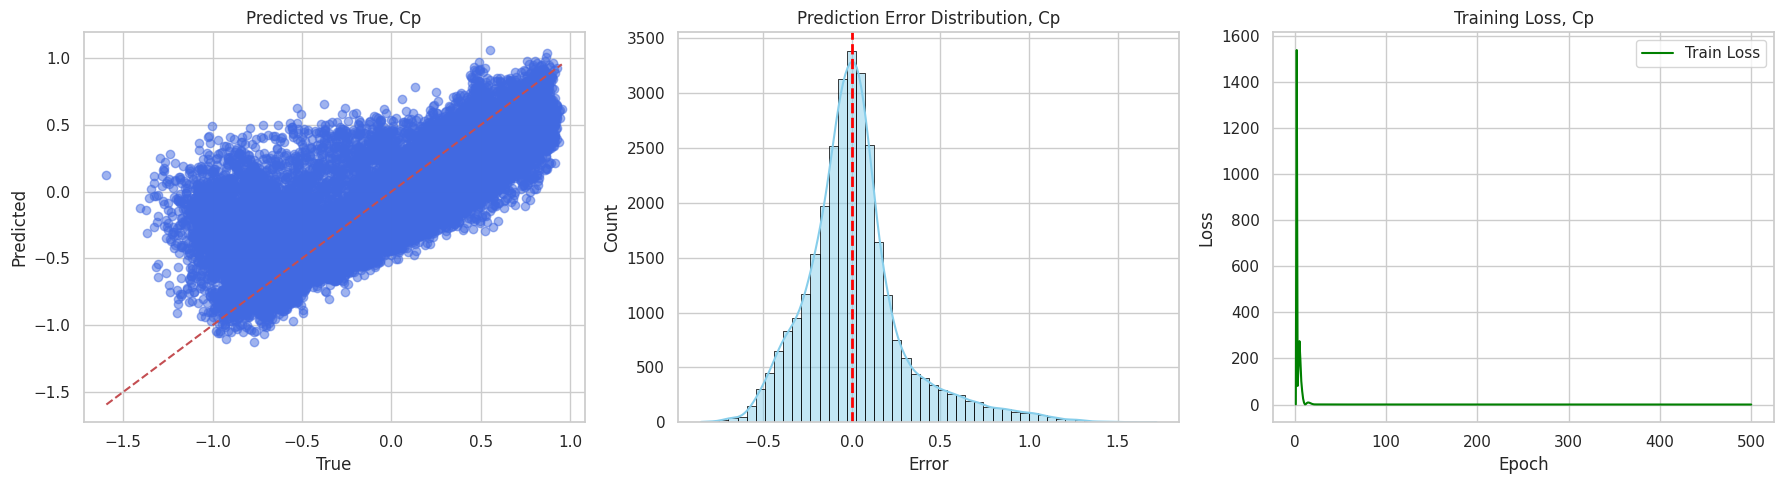

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 41/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 118.81it/s]

Epoch [10/500], Loss: 8.6961
Epoch [20/500], Loss: 2.8273
Epoch [30/500], Loss: 0.4431


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 117.34it/s]

Epoch [40/500], Loss: 0.2538
Epoch [50/500], Loss: 0.2414
Epoch [60/500], Loss: 0.2142


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.22it/s]

Epoch [70/500], Loss: 0.1970
Epoch [80/500], Loss: 0.1857
Epoch [90/500], Loss: 0.1775


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 116.86it/s]

Epoch [100/500], Loss: 0.1691
Epoch [110/500], Loss: 0.1607
Epoch [120/500], Loss: 0.1531


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.13it/s]

Epoch [130/500], Loss: 0.1459
Epoch [140/500], Loss: 0.1388
Epoch [150/500], Loss: 0.1307


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 116.79it/s]

Epoch [160/500], Loss: 0.1217
Epoch [170/500], Loss: 0.1273
Epoch [180/500], Loss: 0.1282


Epochs:  41%|████      | 206/500 [00:01<00:02, 116.47it/s]

Epoch [190/500], Loss: 0.1011
Epoch [200/500], Loss: 0.0976
Epoch [210/500], Loss: 0.0914


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 116.76it/s]

Epoch [220/500], Loss: 0.0891
Epoch [230/500], Loss: 0.0868
Epoch [240/500], Loss: 0.0858


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 116.77it/s]

Epoch [250/500], Loss: 0.0846
Epoch [260/500], Loss: 0.0837
Epoch [270/500], Loss: 0.0829


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.73it/s]

Epoch [280/500], Loss: 0.0884
Epoch [290/500], Loss: 0.0831
Epoch [300/500], Loss: 0.0820


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.20it/s]

Epoch [310/500], Loss: 0.0804
Epoch [320/500], Loss: 0.0799
Epoch [330/500], Loss: 0.0818


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 116.17it/s]

Epoch [340/500], Loss: 0.0836
Epoch [350/500], Loss: 0.0804
Epoch [360/500], Loss: 0.0788


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 116.12it/s]

Epoch [370/500], Loss: 0.0781
Epoch [380/500], Loss: 0.0781
Epoch [390/500], Loss: 0.0812


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.13it/s]

Epoch [400/500], Loss: 0.0784
Epoch [410/500], Loss: 0.0778
Epoch [420/500], Loss: 0.0761


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 116.10it/s]

Epoch [430/500], Loss: 0.0942
Epoch [440/500], Loss: 0.0762
Epoch [450/500], Loss: 0.0774


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 116.04it/s]

Epoch [460/500], Loss: 0.0751
Epoch [470/500], Loss: 0.0749
Epoch [480/500], Loss: 0.0784


Epochs: 100%|██████████| 500/500 [00:04<00:00, 116.62it/s]


Epoch [490/500], Loss: 0.0745
Epoch [500/500], Loss: 0.0743
📈 Evaluation metrics on test set:
MSE: 0.0747
MAE: 0.1900
R2: 0.6984


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 42/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 118.46it/s]

Epoch [10/500], Loss: 12.0701
Epoch [20/500], Loss: 4.3057
Epoch [30/500], Loss: 0.3638


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 116.78it/s]

Epoch [40/500], Loss: 0.2901
Epoch [50/500], Loss: 0.2419
Epoch [60/500], Loss: 0.2435


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 116.91it/s]

Epoch [70/500], Loss: 0.2299
Epoch [80/500], Loss: 0.2255
Epoch [90/500], Loss: 0.2214


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 116.64it/s]

Epoch [100/500], Loss: 0.2167
Epoch [110/500], Loss: 0.2100
Epoch [120/500], Loss: 0.2087


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 116.33it/s]

Epoch [130/500], Loss: 0.2040
Epoch [140/500], Loss: 0.1997
Epoch [150/500], Loss: 0.1966


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 116.25it/s]

Epoch [160/500], Loss: 0.1933
Epoch [170/500], Loss: 0.1897
Epoch [180/500], Loss: 0.1722


Epochs:  41%|████      | 206/500 [00:01<00:02, 116.13it/s]

Epoch [190/500], Loss: 0.1532
Epoch [200/500], Loss: 0.1417
Epoch [210/500], Loss: 0.1357


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 116.11it/s]

Epoch [220/500], Loss: 0.1302
Epoch [230/500], Loss: 0.1236
Epoch [240/500], Loss: 0.1187


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 116.07it/s]

Epoch [250/500], Loss: 0.1145
Epoch [260/500], Loss: 0.1118
Epoch [270/500], Loss: 0.1095


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.02it/s]

Epoch [280/500], Loss: 0.1070
Epoch [290/500], Loss: 0.1001
Epoch [300/500], Loss: 0.0950


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 115.81it/s]

Epoch [310/500], Loss: 0.0919
Epoch [320/500], Loss: 0.0891
Epoch [330/500], Loss: 0.0870


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 115.46it/s]

Epoch [340/500], Loss: 0.0854
Epoch [350/500], Loss: 0.0842
Epoch [360/500], Loss: 0.0833


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 115.72it/s]

Epoch [370/500], Loss: 0.0832
Epoch [380/500], Loss: 0.0819
Epoch [390/500], Loss: 0.0807


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.31it/s]

Epoch [400/500], Loss: 0.0800
Epoch [410/500], Loss: 0.0791
Epoch [420/500], Loss: 0.0785


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 116.12it/s]

Epoch [430/500], Loss: 0.0777
Epoch [440/500], Loss: 0.0769
Epoch [450/500], Loss: 0.0762


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 116.00it/s]

Epoch [460/500], Loss: 0.0756
Epoch [470/500], Loss: 0.0751
Epoch [480/500], Loss: 0.0746


Epochs: 100%|██████████| 500/500 [00:04<00:00, 116.25it/s]


Epoch [490/500], Loss: 0.0742
Epoch [500/500], Loss: 0.0738
📈 Evaluation metrics on test set:
MSE: 0.0727
MAE: 0.1878
R2: 0.7045


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 43/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 116.42it/s]

Epoch [10/500], Loss: 4.4017
Epoch [20/500], Loss: 3.2830
Epoch [30/500], Loss: 0.2742


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 116.60it/s]

Epoch [40/500], Loss: 0.2727
Epoch [50/500], Loss: 0.2689
Epoch [60/500], Loss: 0.2636


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 116.53it/s]

Epoch [70/500], Loss: 0.2579
Epoch [80/500], Loss: 0.2517
Epoch [90/500], Loss: 0.2447


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 115.86it/s]

Epoch [100/500], Loss: 0.2389
Epoch [110/500], Loss: 0.2313
Epoch [120/500], Loss: 0.2171


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 115.96it/s]

Epoch [130/500], Loss: 0.2046
Epoch [140/500], Loss: 0.1955
Epoch [150/500], Loss: 0.1894


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 115.70it/s]

Epoch [160/500], Loss: 0.1841
Epoch [170/500], Loss: 0.1659
Epoch [180/500], Loss: 0.1304


Epochs:  41%|████      | 206/500 [00:01<00:02, 115.69it/s]

Epoch [190/500], Loss: 0.1122
Epoch [200/500], Loss: 0.1059
Epoch [210/500], Loss: 0.1006


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 115.78it/s]

Epoch [220/500], Loss: 0.0953
Epoch [230/500], Loss: 0.0909
Epoch [240/500], Loss: 0.0871


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 115.63it/s]

Epoch [250/500], Loss: 0.0889
Epoch [260/500], Loss: 0.0868
Epoch [270/500], Loss: 0.0842


Epochs:  60%|██████    | 302/500 [00:02<00:01, 115.64it/s]

Epoch [280/500], Loss: 0.0829
Epoch [290/500], Loss: 0.0818
Epoch [300/500], Loss: 0.0810


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 115.56it/s]

Epoch [310/500], Loss: 0.0802
Epoch [320/500], Loss: 0.0795
Epoch [330/500], Loss: 0.0789


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 115.50it/s]

Epoch [340/500], Loss: 0.0783
Epoch [350/500], Loss: 0.0778
Epoch [360/500], Loss: 0.0773


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 115.63it/s]

Epoch [370/500], Loss: 0.0768
Epoch [380/500], Loss: 0.0764
Epoch [390/500], Loss: 0.0760


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.06it/s]

Epoch [400/500], Loss: 0.0756
Epoch [410/500], Loss: 0.0751
Epoch [420/500], Loss: 0.0749


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 115.56it/s]

Epoch [430/500], Loss: 0.0742
Epoch [440/500], Loss: 0.0736
Epoch [450/500], Loss: 0.0739


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 115.35it/s]

Epoch [460/500], Loss: 0.0726
Epoch [470/500], Loss: 0.0718
Epoch [480/500], Loss: 0.0713


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.76it/s]


Epoch [490/500], Loss: 0.0709
Epoch [500/500], Loss: 0.0703
📈 Evaluation metrics on test set:
MSE: 0.0694
MAE: 0.1817
R2: 0.7194


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


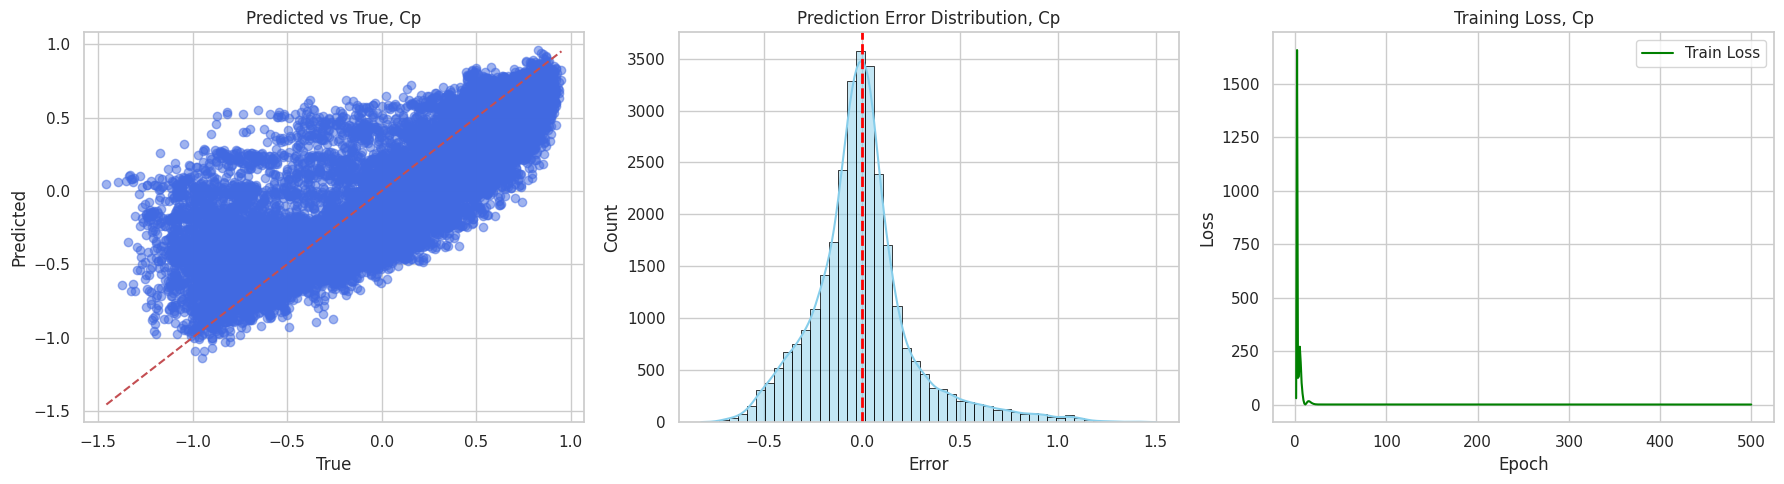

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 44/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 118.21it/s]

Epoch [10/500], Loss: 8.8290
Epoch [20/500], Loss: 0.5235
Epoch [30/500], Loss: 0.2862


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 116.90it/s]

Epoch [40/500], Loss: 0.2348
Epoch [50/500], Loss: 0.2215
Epoch [60/500], Loss: 0.2109


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 116.83it/s]

Epoch [70/500], Loss: 0.2056
Epoch [80/500], Loss: 0.2010
Epoch [90/500], Loss: 0.1965


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 116.39it/s]

Epoch [100/500], Loss: 0.1918
Epoch [110/500], Loss: 0.1877
Epoch [120/500], Loss: 0.1834


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 116.18it/s]

Epoch [130/500], Loss: 0.1779
Epoch [140/500], Loss: 0.1685
Epoch [150/500], Loss: 0.1542


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 115.88it/s]

Epoch [160/500], Loss: 0.1322
Epoch [170/500], Loss: 0.1137
Epoch [180/500], Loss: 0.1073


Epochs:  41%|████      | 206/500 [00:01<00:02, 116.24it/s]

Epoch [190/500], Loss: 0.1033
Epoch [200/500], Loss: 0.1002
Epoch [210/500], Loss: 0.0982


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 116.49it/s]

Epoch [220/500], Loss: 0.0961
Epoch [230/500], Loss: 0.0945
Epoch [240/500], Loss: 0.0935


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 116.42it/s]

Epoch [250/500], Loss: 0.0917
Epoch [260/500], Loss: 0.0901
Epoch [270/500], Loss: 0.0887


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.24it/s]

Epoch [280/500], Loss: 0.0873
Epoch [290/500], Loss: 0.0864
Epoch [300/500], Loss: 0.0851


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.00it/s]

Epoch [310/500], Loss: 0.0842
Epoch [320/500], Loss: 0.0832
Epoch [330/500], Loss: 0.0824


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 115.74it/s]

Epoch [340/500], Loss: 0.0816
Epoch [350/500], Loss: 0.0806
Epoch [360/500], Loss: 0.0798


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 115.90it/s]

Epoch [370/500], Loss: 0.0802
Epoch [380/500], Loss: 0.0787
Epoch [390/500], Loss: 0.0775


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 115.87it/s]

Epoch [400/500], Loss: 0.0771
Epoch [410/500], Loss: 0.0758
Epoch [420/500], Loss: 0.0838


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 115.53it/s]

Epoch [430/500], Loss: 0.0808
Epoch [440/500], Loss: 0.0779
Epoch [450/500], Loss: 0.0762


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 115.70it/s]

Epoch [460/500], Loss: 0.0752
Epoch [470/500], Loss: 0.0742
Epoch [480/500], Loss: 0.0733


Epochs: 100%|██████████| 500/500 [00:04<00:00, 116.16it/s]


Epoch [490/500], Loss: 0.0723
Epoch [500/500], Loss: 0.0714
📈 Evaluation metrics on test set:
MSE: 0.0716
MAE: 0.1857
R2: 0.7083


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 45/50
→ hidden_dim: 128, lr: 0.00800
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 118.77it/s]

Epoch [10/500], Loss: 35.6159
Epoch [20/500], Loss: 4.2088
Epoch [30/500], Loss: 2.3820


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 117.68it/s]

Epoch [40/500], Loss: 0.9903
Epoch [50/500], Loss: 0.4938
Epoch [60/500], Loss: 0.2850


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.39it/s]

Epoch [70/500], Loss: 0.2311
Epoch [80/500], Loss: 0.1951
Epoch [90/500], Loss: 0.1897


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.60it/s]

Epoch [100/500], Loss: 0.1833
Epoch [110/500], Loss: 0.1803
Epoch [120/500], Loss: 0.1763


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.02it/s]

Epoch [130/500], Loss: 0.1727
Epoch [140/500], Loss: 0.1722
Epoch [150/500], Loss: 0.1556


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.01it/s]

Epoch [160/500], Loss: 0.1720
Epoch [170/500], Loss: 0.1631
Epoch [180/500], Loss: 0.1566


Epochs:  41%|████      | 206/500 [00:01<00:02, 116.94it/s]

Epoch [190/500], Loss: 0.1435
Epoch [200/500], Loss: 0.1341
Epoch [210/500], Loss: 0.1433


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 116.88it/s]

Epoch [220/500], Loss: 0.1233
Epoch [230/500], Loss: 0.1063
Epoch [240/500], Loss: 0.0964


Epochs:  53%|█████▎    | 266/500 [00:02<00:02, 116.98it/s]

Epoch [250/500], Loss: 0.0924
Epoch [260/500], Loss: 0.0900
Epoch [270/500], Loss: 0.0887


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.74it/s]

Epoch [280/500], Loss: 0.0874
Epoch [290/500], Loss: 0.0864
Epoch [300/500], Loss: 0.0855


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.54it/s]

Epoch [310/500], Loss: 0.0849
Epoch [320/500], Loss: 0.0841
Epoch [330/500], Loss: 0.0834


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 116.72it/s]

Epoch [340/500], Loss: 0.0829
Epoch [350/500], Loss: 0.0823
Epoch [360/500], Loss: 0.0818


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 117.02it/s]

Epoch [370/500], Loss: 0.0813
Epoch [380/500], Loss: 0.0807
Epoch [390/500], Loss: 0.0801


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.79it/s]

Epoch [400/500], Loss: 0.0797
Epoch [410/500], Loss: 0.0789
Epoch [420/500], Loss: 0.0789


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 116.80it/s]

Epoch [430/500], Loss: 0.0782
Epoch [440/500], Loss: 0.0775
Epoch [450/500], Loss: 0.0765


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 116.74it/s]

Epoch [460/500], Loss: 0.0760
Epoch [470/500], Loss: 0.0753
Epoch [480/500], Loss: 0.0764


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.03it/s]


Epoch [490/500], Loss: 0.0758
Epoch [500/500], Loss: 0.0741
📈 Evaluation metrics on test set:
MSE: 0.0736
MAE: 0.1941
R2: 0.7011


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


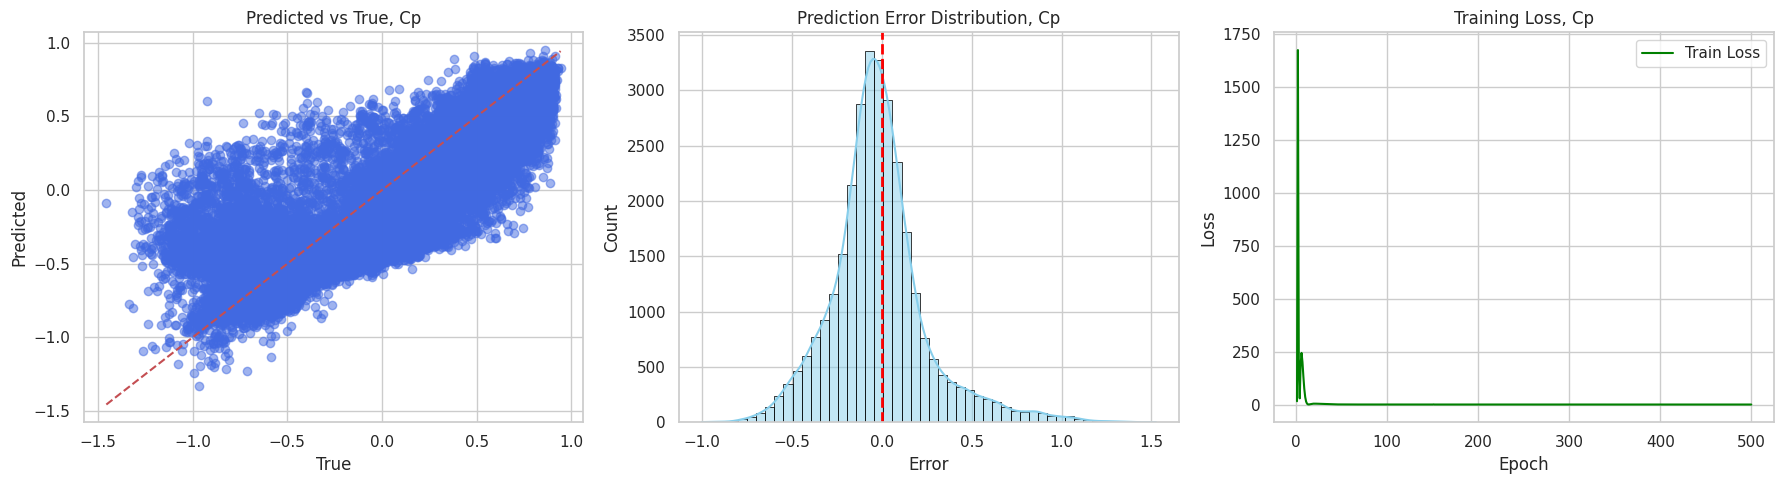

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_8e-03lr_64bs_500ep/loss_plot.png

🔁 Run 46/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 20/500 [00:00<00:05, 94.44it/s]

Epoch [10/500], Loss: 23.3371
Epoch [20/500], Loss: 3.2957
Epoch [30/500], Loss: 0.5718


Epochs:  11%|█         | 56/500 [00:00<00:03, 112.16it/s]

Epoch [40/500], Loss: 0.3858
Epoch [50/500], Loss: 0.2487
Epoch [60/500], Loss: 0.2630


Epochs:  18%|█▊        | 92/500 [00:00<00:03, 115.37it/s]

Epoch [70/500], Loss: 0.2147
Epoch [80/500], Loss: 0.2049
Epoch [90/500], Loss: 0.1953


Epochs:  23%|██▎       | 116/500 [00:01<00:03, 115.93it/s]

Epoch [100/500], Loss: 0.1712
Epoch [110/500], Loss: 0.1413
Epoch [120/500], Loss: 0.1260


Epochs:  30%|███       | 152/500 [00:01<00:02, 117.20it/s]

Epoch [130/500], Loss: 0.1213
Epoch [140/500], Loss: 0.1151
Epoch [150/500], Loss: 0.1108


Epochs:  35%|███▌      | 176/500 [00:01<00:02, 117.26it/s]

Epoch [160/500], Loss: 0.1057
Epoch [170/500], Loss: 0.0998
Epoch [180/500], Loss: 0.0957


Epochs:  42%|████▏     | 212/500 [00:01<00:02, 116.69it/s]

Epoch [190/500], Loss: 0.0926
Epoch [200/500], Loss: 0.0897
Epoch [210/500], Loss: 0.0872


Epochs:  47%|████▋     | 236/500 [00:02<00:02, 117.20it/s]

Epoch [220/500], Loss: 0.0854
Epoch [230/500], Loss: 0.0833
Epoch [240/500], Loss: 0.0814


Epochs:  54%|█████▍    | 272/500 [00:02<00:01, 117.20it/s]

Epoch [250/500], Loss: 0.0799
Epoch [260/500], Loss: 0.0788
Epoch [270/500], Loss: 0.0779


Epochs:  59%|█████▉    | 296/500 [00:02<00:01, 117.01it/s]

Epoch [280/500], Loss: 0.0773
Epoch [290/500], Loss: 0.0764
Epoch [300/500], Loss: 0.0759


Epochs:  66%|██████▋   | 332/500 [00:02<00:01, 116.86it/s]

Epoch [310/500], Loss: 0.0758
Epoch [320/500], Loss: 0.0752
Epoch [330/500], Loss: 0.0758


Epochs:  71%|███████   | 356/500 [00:03<00:01, 117.00it/s]

Epoch [340/500], Loss: 0.0747
Epoch [350/500], Loss: 0.0741
Epoch [360/500], Loss: 0.0737


Epochs:  78%|███████▊  | 392/500 [00:03<00:00, 116.83it/s]

Epoch [370/500], Loss: 0.0732
Epoch [380/500], Loss: 0.0724
Epoch [390/500], Loss: 0.0719


Epochs:  83%|████████▎ | 416/500 [00:03<00:00, 116.66it/s]

Epoch [400/500], Loss: 0.0715
Epoch [410/500], Loss: 0.0710
Epoch [420/500], Loss: 0.0716


Epochs:  90%|█████████ | 452/500 [00:03<00:00, 116.70it/s]

Epoch [430/500], Loss: 0.0704
Epoch [440/500], Loss: 0.0700
Epoch [450/500], Loss: 0.0705


Epochs:  95%|█████████▌| 476/500 [00:04<00:00, 116.87it/s]

Epoch [460/500], Loss: 0.0695
Epoch [470/500], Loss: 0.0695
Epoch [480/500], Loss: 0.0691


Epochs: 100%|██████████| 500/500 [00:04<00:00, 115.81it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0694
Epoch [500/500], Loss: 0.0687
📈 Evaluation metrics on test set:
MSE: 0.0701
MAE: 0.1802
R2: 0.7175


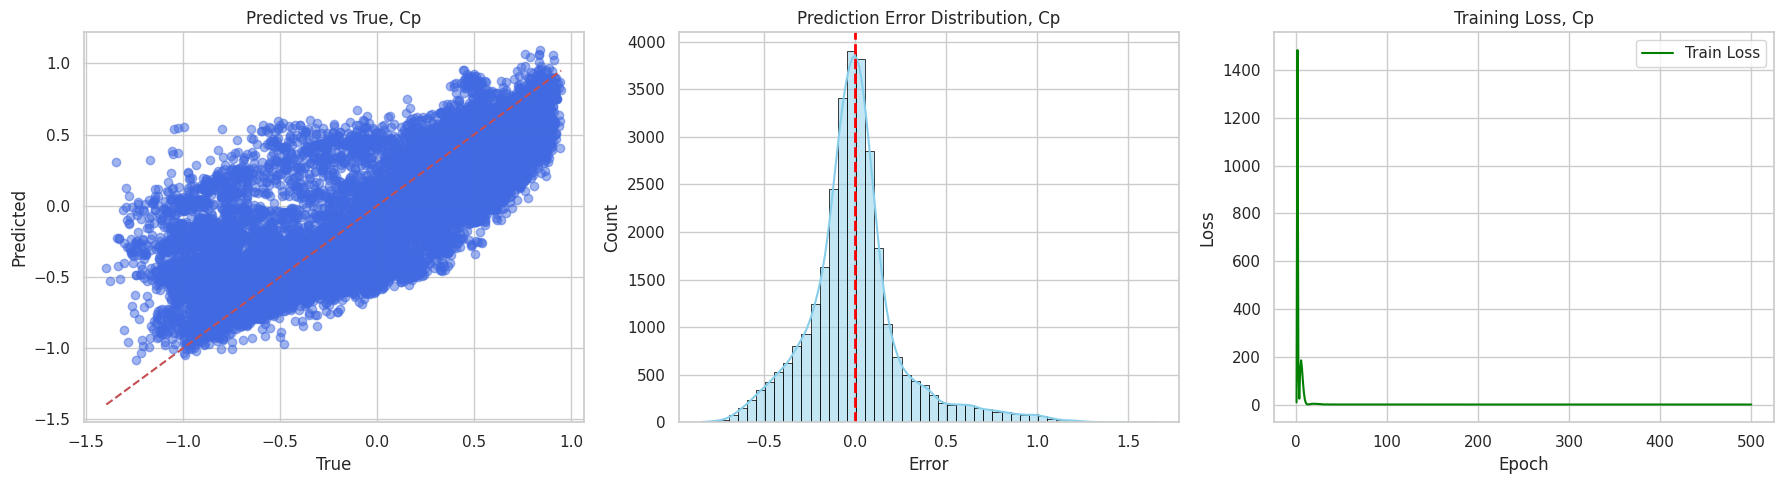

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 47/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 119.64it/s]

Epoch [10/500], Loss: 28.0869
Epoch [20/500], Loss: 1.2062
Epoch [30/500], Loss: 0.3111


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 117.92it/s]

Epoch [40/500], Loss: 0.2755
Epoch [50/500], Loss: 0.2597
Epoch [60/500], Loss: 0.2385


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.34it/s]

Epoch [70/500], Loss: 0.2224
Epoch [80/500], Loss: 0.2113
Epoch [90/500], Loss: 0.2124


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.42it/s]

Epoch [100/500], Loss: 0.2058
Epoch [110/500], Loss: 0.2012
Epoch [120/500], Loss: 0.1876


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.02it/s]

Epoch [130/500], Loss: 0.1646
Epoch [140/500], Loss: 0.1439
Epoch [150/500], Loss: 0.1308


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.02it/s]

Epoch [160/500], Loss: 0.1148
Epoch [170/500], Loss: 0.1047
Epoch [180/500], Loss: 0.0993


Epochs:  41%|████      | 206/500 [00:01<00:02, 117.35it/s]

Epoch [190/500], Loss: 0.0949
Epoch [200/500], Loss: 0.0912
Epoch [210/500], Loss: 0.0895


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 117.81it/s]

Epoch [220/500], Loss: 0.0883
Epoch [230/500], Loss: 0.0872
Epoch [240/500], Loss: 0.0862


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 117.71it/s]

Epoch [250/500], Loss: 0.0855
Epoch [260/500], Loss: 0.0850
Epoch [270/500], Loss: 0.0833


Epochs:  60%|██████    | 302/500 [00:02<00:01, 117.20it/s]

Epoch [280/500], Loss: 0.0824
Epoch [290/500], Loss: 0.0867
Epoch [300/500], Loss: 0.0819


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 117.39it/s]

Epoch [310/500], Loss: 0.0805
Epoch [320/500], Loss: 0.0801
Epoch [330/500], Loss: 0.0871


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 117.09it/s]

Epoch [340/500], Loss: 0.0820
Epoch [350/500], Loss: 0.0810
Epoch [360/500], Loss: 0.0787


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 117.39it/s]

Epoch [370/500], Loss: 0.0775
Epoch [380/500], Loss: 0.0768
Epoch [390/500], Loss: 0.0766


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 117.39it/s]

Epoch [400/500], Loss: 0.0781
Epoch [410/500], Loss: 0.0759
Epoch [420/500], Loss: 0.0752


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 117.32it/s]

Epoch [430/500], Loss: 0.0746
Epoch [440/500], Loss: 0.0744
Epoch [450/500], Loss: 0.0743


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 117.25it/s]

Epoch [460/500], Loss: 0.0748
Epoch [470/500], Loss: 0.0740
Epoch [480/500], Loss: 0.0727


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.43it/s]


Epoch [490/500], Loss: 0.0737
Epoch [500/500], Loss: 0.0732
📈 Evaluation metrics on test set:
MSE: 0.0757
MAE: 0.1870
R2: 0.6949


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 48/50
→ hidden_dim: 128, lr: 0.00900
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   4%|▍         | 21/500 [00:00<00:04, 101.05it/s]

Epoch [10/500], Loss: 15.6972
Epoch [20/500], Loss: 9.1542
Epoch [30/500], Loss: 0.3327


Epochs:  11%|█▏        | 57/500 [00:00<00:03, 112.72it/s]

Epoch [40/500], Loss: 0.4982
Epoch [50/500], Loss: 0.2971
Epoch [60/500], Loss: 0.2505


Epochs:  19%|█▊        | 93/500 [00:00<00:03, 115.69it/s]

Epoch [70/500], Loss: 0.2351
Epoch [80/500], Loss: 0.2249
Epoch [90/500], Loss: 0.2138


Epochs:  23%|██▎       | 117/500 [00:01<00:03, 116.59it/s]

Epoch [100/500], Loss: 0.2055
Epoch [110/500], Loss: 0.1930
Epoch [120/500], Loss: 0.1771


Epochs:  31%|███       | 153/500 [00:01<00:02, 117.16it/s]

Epoch [130/500], Loss: 0.1576
Epoch [140/500], Loss: 0.1274
Epoch [150/500], Loss: 0.1090


Epochs:  35%|███▌      | 177/500 [00:01<00:02, 117.01it/s]

Epoch [160/500], Loss: 0.0983
Epoch [170/500], Loss: 0.0952
Epoch [180/500], Loss: 0.0951


Epochs:  43%|████▎     | 213/500 [00:01<00:02, 116.87it/s]

Epoch [190/500], Loss: 0.0914
Epoch [200/500], Loss: 0.0900
Epoch [210/500], Loss: 0.0885


Epochs:  47%|████▋     | 237/500 [00:02<00:02, 116.69it/s]

Epoch [220/500], Loss: 0.0889
Epoch [230/500], Loss: 0.0867
Epoch [240/500], Loss: 0.0849


Epochs:  55%|█████▍    | 273/500 [00:02<00:01, 116.86it/s]

Epoch [250/500], Loss: 0.0834
Epoch [260/500], Loss: 0.0863
Epoch [270/500], Loss: 0.0836


Epochs:  59%|█████▉    | 297/500 [00:02<00:01, 116.80it/s]

Epoch [280/500], Loss: 0.0821
Epoch [290/500], Loss: 0.0810
Epoch [300/500], Loss: 0.0804


Epochs:  67%|██████▋   | 333/500 [00:02<00:01, 116.95it/s]

Epoch [310/500], Loss: 0.0800
Epoch [320/500], Loss: 0.0811
Epoch [330/500], Loss: 0.0806


Epochs:  71%|███████▏  | 357/500 [00:03<00:01, 117.30it/s]

Epoch [340/500], Loss: 0.0791
Epoch [350/500], Loss: 0.0780
Epoch [360/500], Loss: 0.0772


Epochs:  79%|███████▊  | 393/500 [00:03<00:00, 117.50it/s]

Epoch [370/500], Loss: 0.0765
Epoch [380/500], Loss: 0.0757
Epoch [390/500], Loss: 0.0766


Epochs:  83%|████████▎ | 417/500 [00:03<00:00, 117.32it/s]

Epoch [400/500], Loss: 0.0746
Epoch [410/500], Loss: 0.0770
Epoch [420/500], Loss: 0.0745


Epochs:  91%|█████████ | 453/500 [00:03<00:00, 117.22it/s]

Epoch [430/500], Loss: 0.0724
Epoch [440/500], Loss: 0.0733
Epoch [450/500], Loss: 0.0726


Epochs:  95%|█████████▌| 477/500 [00:04<00:00, 116.92it/s]

Epoch [460/500], Loss: 0.0716
Epoch [470/500], Loss: 0.0699
Epoch [480/500], Loss: 0.0698


Epochs: 100%|██████████| 500/500 [00:04<00:00, 116.12it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [490/500], Loss: 0.0709
Epoch [500/500], Loss: 0.0689
📈 Evaluation metrics on test set:
MSE: 0.0692
MAE: 0.1837
R2: 0.7217


📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 49/50
→ hidden_dim: 128, lr: 0.00850
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:04, 118.42it/s]

Epoch [10/500], Loss: 15.8232
Epoch [20/500], Loss: 2.6747
Epoch [30/500], Loss: 0.3874


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 118.00it/s]

Epoch [40/500], Loss: 0.2544
Epoch [50/500], Loss: 0.2216
Epoch [60/500], Loss: 0.2080


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.54it/s]

Epoch [70/500], Loss: 0.2009
Epoch [80/500], Loss: 0.1956
Epoch [90/500], Loss: 0.1860


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.30it/s]

Epoch [100/500], Loss: 0.1670
Epoch [110/500], Loss: 0.1471
Epoch [120/500], Loss: 0.1341


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.17it/s]

Epoch [130/500], Loss: 0.1855
Epoch [140/500], Loss: 0.2488
Epoch [150/500], Loss: 0.2183


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.35it/s]

Epoch [160/500], Loss: 0.1391
Epoch [170/500], Loss: 0.1278
Epoch [180/500], Loss: 0.1262


Epochs:  41%|████      | 206/500 [00:01<00:02, 116.99it/s]

Epoch [190/500], Loss: 0.1221
Epoch [200/500], Loss: 0.1200
Epoch [210/500], Loss: 0.1184


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 117.19it/s]

Epoch [220/500], Loss: 0.1169
Epoch [230/500], Loss: 0.1163
Epoch [240/500], Loss: 0.1145


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 117.24it/s]

Epoch [250/500], Loss: 0.1165
Epoch [260/500], Loss: 0.1141
Epoch [270/500], Loss: 0.1126


Epochs:  60%|██████    | 302/500 [00:02<00:01, 116.95it/s]

Epoch [280/500], Loss: 0.1113
Epoch [290/500], Loss: 0.1102
Epoch [300/500], Loss: 0.1091


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 116.68it/s]

Epoch [310/500], Loss: 0.1082
Epoch [320/500], Loss: 0.1074
Epoch [330/500], Loss: 0.1066


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 116.76it/s]

Epoch [340/500], Loss: 0.1059
Epoch [350/500], Loss: 0.1053
Epoch [360/500], Loss: 0.1047


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 117.19it/s]

Epoch [370/500], Loss: 0.1041
Epoch [380/500], Loss: 0.1036
Epoch [390/500], Loss: 0.1031


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 116.99it/s]

Epoch [400/500], Loss: 0.1026
Epoch [410/500], Loss: 0.1021
Epoch [420/500], Loss: 0.1016


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 117.30it/s]

Epoch [430/500], Loss: 0.1011
Epoch [440/500], Loss: 0.1007
Epoch [450/500], Loss: 0.1002


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 117.42it/s]

Epoch [460/500], Loss: 0.0998
Epoch [470/500], Loss: 0.0993
Epoch [480/500], Loss: 0.0990


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.20it/s]


Epoch [490/500], Loss: 0.1022
Epoch [500/500], Loss: 0.0982
📈 Evaluation metrics on test set:
MSE: 0.0993
MAE: 0.2248
R2: 0.5957


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


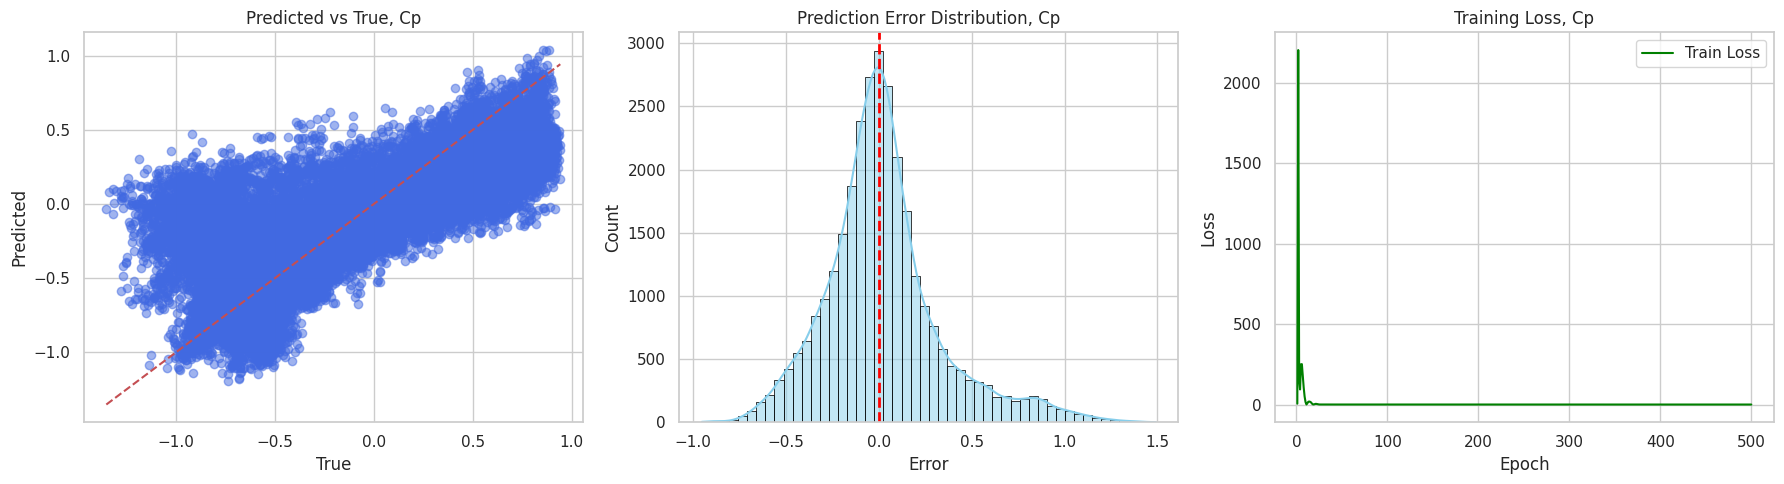

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png

🔁 Run 50/50
→ hidden_dim: 128, lr: 0.00950
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep


Epochs:   5%|▌         | 26/500 [00:00<00:03, 119.67it/s]

Epoch [10/500], Loss: 11.9894
Epoch [20/500], Loss: 0.9042
Epoch [30/500], Loss: 0.3060


Epochs:  12%|█▏        | 62/500 [00:00<00:03, 118.91it/s]

Epoch [40/500], Loss: 0.2664
Epoch [50/500], Loss: 0.2508
Epoch [60/500], Loss: 0.2413


Epochs:  17%|█▋        | 86/500 [00:00<00:03, 117.85it/s]

Epoch [70/500], Loss: 0.2303
Epoch [80/500], Loss: 0.2165
Epoch [90/500], Loss: 0.2081


Epochs:  24%|██▍       | 122/500 [00:01<00:03, 117.35it/s]

Epoch [100/500], Loss: 0.2034
Epoch [110/500], Loss: 0.1918
Epoch [120/500], Loss: 0.1808


Epochs:  29%|██▉       | 146/500 [00:01<00:03, 117.46it/s]

Epoch [130/500], Loss: 0.1706
Epoch [140/500], Loss: 0.1552
Epoch [150/500], Loss: 0.1404


Epochs:  36%|███▋      | 182/500 [00:01<00:02, 117.53it/s]

Epoch [160/500], Loss: 0.1205
Epoch [170/500], Loss: 0.1041
Epoch [180/500], Loss: 0.0958


Epochs:  41%|████      | 206/500 [00:01<00:02, 117.53it/s]

Epoch [190/500], Loss: 0.0921
Epoch [200/500], Loss: 0.0897
Epoch [210/500], Loss: 0.0878


Epochs:  48%|████▊     | 242/500 [00:02<00:02, 117.54it/s]

Epoch [220/500], Loss: 0.0862
Epoch [230/500], Loss: 0.0847
Epoch [240/500], Loss: 0.0833


Epochs:  53%|█████▎    | 266/500 [00:02<00:01, 117.67it/s]

Epoch [250/500], Loss: 0.0819
Epoch [260/500], Loss: 0.0808
Epoch [270/500], Loss: 0.0797


Epochs:  60%|██████    | 302/500 [00:02<00:01, 117.29it/s]

Epoch [280/500], Loss: 0.0788
Epoch [290/500], Loss: 0.0778
Epoch [300/500], Loss: 0.0769


Epochs:  65%|██████▌   | 326/500 [00:02<00:01, 117.54it/s]

Epoch [310/500], Loss: 0.0760
Epoch [320/500], Loss: 0.0759
Epoch [330/500], Loss: 0.0749


Epochs:  72%|███████▏  | 362/500 [00:03<00:01, 117.49it/s]

Epoch [340/500], Loss: 0.0743
Epoch [350/500], Loss: 0.0737
Epoch [360/500], Loss: 0.0731


Epochs:  77%|███████▋  | 386/500 [00:03<00:00, 117.65it/s]

Epoch [370/500], Loss: 0.0727
Epoch [380/500], Loss: 0.0723
Epoch [390/500], Loss: 0.0720


Epochs:  84%|████████▍ | 422/500 [00:03<00:00, 117.48it/s]

Epoch [400/500], Loss: 0.0713
Epoch [410/500], Loss: 0.0711
Epoch [420/500], Loss: 0.0707


Epochs:  89%|████████▉ | 446/500 [00:03<00:00, 117.32it/s]

Epoch [430/500], Loss: 0.0706
Epoch [440/500], Loss: 0.0701
Epoch [450/500], Loss: 0.0694


Epochs:  96%|█████████▋| 482/500 [00:04<00:00, 117.62it/s]

Epoch [460/500], Loss: 0.0691
Epoch [470/500], Loss: 0.0686
Epoch [480/500], Loss: 0.0684


Epochs: 100%|██████████| 500/500 [00:04<00:00, 117.65it/s]


Epoch [490/500], Loss: 0.0677
Epoch [500/500], Loss: 0.0674
📈 Evaluation metrics on test set:
MSE: 0.0681
MAE: 0.1808
R2: 0.7284


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


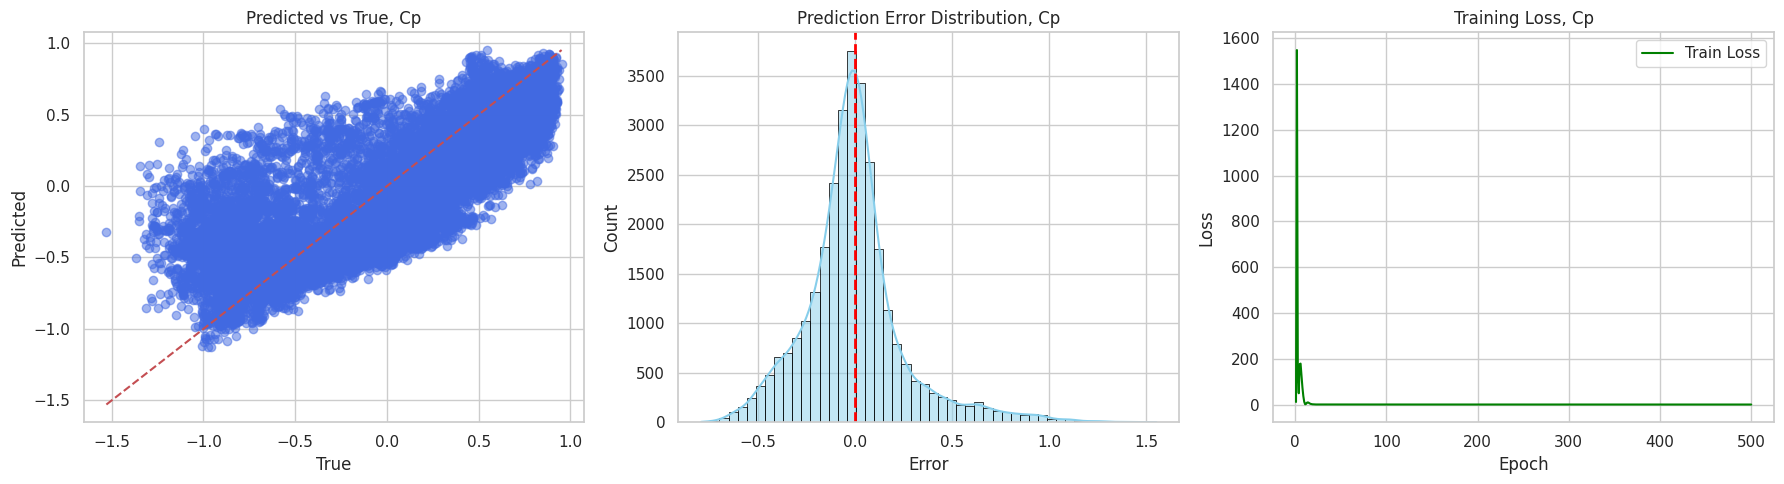

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_128h_9e-03lr_64bs_500ep/loss_plot.png


In [9]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
hidden_dim_choices = [128]
lr_choices = [round(x, 5) for x in list(np.arange(0.007, 0.01, 0.0005))]

#hidden_dim_choices = [128, 264]
#lr_choices = [ 1e-3, 5e-3]

# 📌 Fixed parameters
EPOCHS = 500
BATCH_SIZE = 64
OUTPUT_DIM = 1
#N_RUNS = 10  # Total number of runs
N_RUNS = 50  # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM
    )

In [10]:
# 📁 src/tuning/visualize_search_results.py
# ➤ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📥 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH, header=None)
df_log.columns = ["run_id", "hidden_dim", "lr", "R2", "MAE", "MSE"]

# 📊 Pivot table for heatmap
pivot_table = df_log.pivot_table(
    values="R2",
    index="hidden_dim",
    columns="lr",
    aggfunc="mean"  # handles repeated runs with same params
)

# 🔥 Draw heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Heatmap of R² by hidden_dim and learning rate")
plt.xlabel("Learning Rate")
plt.ylabel("Hidden Dim")
plt.tight_layout()
plt.show()

# 🏆 Show best configuration
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\n🏆 Best result:")
print(f"Run ID      : {best_row['run_id']}")
print(f"Hidden Dim  : {int(best_row['hidden_dim'])}")
print(f"Learning Rate: {best_row['lr']:.5f}")
print(f"R²          : {best_row['R2']:.4f}")
print(f"MAE         : {best_row['MAE']:.4f}")
print(f"MSE         : {best_row['MSE']:.6f}")

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n📌 R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "R2", "MAE", "MSE"]])




🏆 Best result:
Run ID      : mlp_128h_7e-03lr_64bs_500ep
Hidden Dim  : 128
Learning Rate: 0.00700
R²          : 0.7453
MAE         : 0.1735
MSE         : 0.063032

📌 R² threshold (95% of max): 0.7080
🔍 Found 21 stable candidates:

    hidden_dim     lr      R2     MAE       MSE
27         128  0.007  0.7453  0.1735  0.063032
28         128  0.009  0.7446  0.1823  0.064081
4          128  0.009  0.7328  0.1767  0.066152
16         128  0.007  0.7291  0.1794  0.066490
14         128  0.009  0.7286  0.1764  0.066505
49         128  0.009  0.7284  0.1808  0.068139
12         128  0.007  0.7268  0.1825  0.067260
23         128  0.008  0.7260  0.1847  0.067805
5          128  0.009  0.7236  0.1816  0.067811
19         128  0.009  0.7221  0.1869  0.069546
9          128  0.009  0.7218  0.1833  0.068547
47         128  0.009  0.7217  0.1837  0.069237
42         128  0.009  0.7194  0.1817  0.069365
30         128  0.007  0.7193  0.1812  0.069564
1          128  0.008  0.7175  0.1822  0.070066
